# Squishy Autoencoder

In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [122]:
%matplotlib notebook

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Prep data

In [3]:
raw_data = np.loadtxt("../data/shuffled_data/repeat_shuffle_train.csv", delimiter=",", dtype=float)

In [4]:
raw_data = torch.tensor(raw_data).float() # convert to float32

In [74]:
NN = 100
data = raw_data.T[:,:NN] # take first NN neurons for now
data.shape

torch.Size([226814, 100])

In [75]:
# split into training and validation data
np.random.seed(42)
split = int(0.8 * data.shape[0])
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
train_data = data[indices[:split]]
val_data = data[indices[split:]]

In [76]:
non_zero_train_data = train_data[train_data.sum(axis=1)!=0]

In [77]:
BATCH_SIZE = 32
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
non_zero_train_data_loader = torch.utils.data.DataLoader(
    non_zero_train_data,
    batch_size=BATCH_SIZE,
    shuffle=True)
zero_data_loader = torch.utils.data.DataLoader(torch.zeros((100,NN)), batch_size=BATCH_SIZE)

## Define model

In [78]:
def init_weights(layer,fill_bias=0):
    #torch.nn.init.constant_(layer.bias, fill_bias)
    torch.nn.init.orthogonal_(layer.weight,gain=np.sqrt(2))

In [79]:
class round_skip_grad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [80]:
class Encoder(nn.Module):
    def __init__(self, 
                 layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [160,10,2]",
                 squish = 10):
        super(Encoder, self).__init__()
        
        self.squish = squish
        self.layers = nn.ModuleList([])
        
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1]) 
    
    def forward(self, x):
        for layer in self.layers[:-1]: # encode
            x = F.relu(layer(x))
        x =  self.layers[-1](x)
        x = torch.sigmoid(self.squish*x) #squish
        x = round_skip_grad().apply(x) # round
        return x

In [81]:
class Decoder(nn.Module):
    def __init__(self, 
                layer_dims : "list of at least 2 ints specifying input dims for each layer, e.g. [2,4,160]"):
        super(Decoder, self).__init__()
        
        self.layers = nn.ModuleList([])
        for i in range(1,len(layer_dims)):
            self.layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            init_weights(self.layers[-1])
        
    def forward(self, z):
        for layer in self.layers[:-1]: # decode
            z = F.relu(layer(z))
        z = self.layers[-1](z) # don't apply activation on last layer
        z = torch.sigmoid(z) #squish
        return z

In [82]:
class Autoencoder(nn.Module):
    def __init__(self, encoder_layer_dims, decoder_layer_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(encoder_layer_dims)
        self.decoder = Decoder(decoder_layer_dims)
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [83]:
ae = Autoencoder([NN,4,2],[2,4,NN])
batch = next(iter(train_data_loader))
reconstruction = ae(batch)
torch.round(reconstruction)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]], grad_fn=<RoundBackward0>)

## Define training loop

In [84]:
def eucl(x,x_hat):
    return ( (x - x_hat)**2 ).sum()

In [85]:
def train(autoencoder, data_loader, epochs=20, lr=.001, loss_fn=eucl):
    opt = torch.optim.AdamW(autoencoder.parameters(),lr)
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for epoch in range(epochs):
        epoch_loss = 0
        for x in tqdm(data_loader):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = loss_fn(x, x_hat)
            loss.backward()
            opt.step()
            
            epoch_loss += loss
            
        # calculate validation loss
        val_loss = loss_fn( val_data, autoencoder(val_data) )
        # normalise and take local values 
        mean_train_loss = epoch_loss.item() / train_data.shape[0]
        mean_val_loss = val_loss.item() / val_data.shape[0]
        # add to this models train and val loss trajectories
        train_losses[epoch] = mean_train_loss
        train_losses[epoch] = mean_val_loss
        print(f"{epoch}. Train loss: {np.round(mean_train_loss,2)}, Val loss: {np.round(mean_val_loss,2)}")
        
    return autoencoder, train_losses, val_losses

Define model

In [86]:
torch.manual_seed(0)
# define model
NNs = train_data.shape[1]
latent_dims = 20
encoder_layer_dims = [NNs,60,50,40,latent_dims]
decoder_layer_dims = encoder_layer_dims[::-1]
ae = Autoencoder(encoder_layer_dims, decoder_layer_dims).to(device) # GPU

We can choose between the following datasets:

- `train_data_loader` : which comprises a shuffled portion of the observed states
- `non_zero_train_data_loader` : which compresis a shuffled portion of the observed states where at least 1 neuron fired
- `zero_data_loader` : which is just a data-set of empty states

In [87]:
ae, train_loss, val_loss = train(ae, train_data_loader, 3,lr=.0001,loss_fn=eucl)

100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1303.02it/s]


0. Train loss: 3.81, Val loss: 2.82


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1346.71it/s]


1. Train loss: 2.68, Val loss: 2.58


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1328.67it/s]


2. Train loss: 2.49, Val loss: 2.43


## Visualise latent representations

In [88]:
def plot_latent(autoencoder, data):
    """
        Plots the latent representation of states, colouring states by how many neurons fire
        data should be a SxN tensor where S is the number of states and N the number of neurons
    """
    Ks = data.sum(axis=1).detach().numpy() #how many neurons fired in each state
    z = autoencoder.encoder(data).detach().numpy() #SxL where L is the latent dimensions
    cmap = plt.get_cmap('RdBu', np.max(Ks)-np.min(Ks)+1)
    plt.scatter(z[:,0],z[:,3],c=Ks,marker=".",cmap=cmap)
    plt.colorbar()

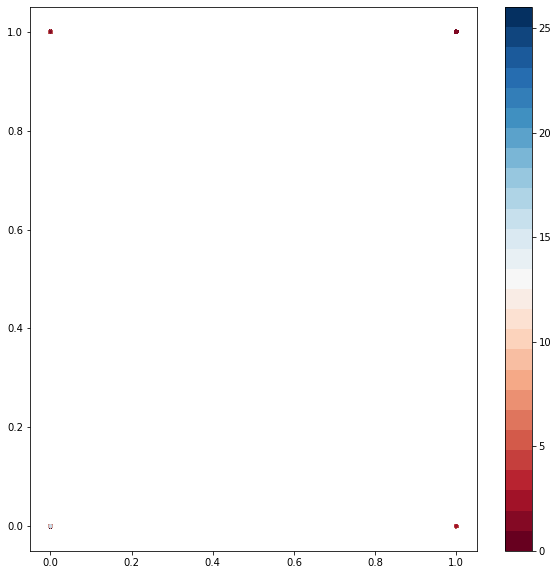

In [89]:
plt.figure(figsize=(10,10))
plot_latent(ae,val_data)
plt.show()

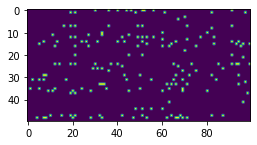

In [90]:
plt.figure(figsize=(4,10))
plt.imshow(val_data.unsqueeze(-1).numpy()[:50])

## Looking at the hamming distance on validation data

In [91]:
def hamming(data, recon):
    XORS = data * (1-recon) + (1-data) * recon
    return XORS.sum(1)

In [92]:
val_data.shape

torch.Size([45363, 100])

In [93]:
Ks = val_data.sum(axis=1)

print("Mean hamming distance: ", np.round(torch.mean(hamming(val_data, torch.round(ae(val_data)))).item(),3))

print("Hamming distances")
print("%2s %5s %4s %4s" % ("K", "obvs", "mean", "max"))

for K in range(int(torch.max(Ks))+1):
    states_K_fire = val_data[Ks==K]
    recon = torch.round(ae(states_K_fire))
    ham_dists = hamming(states_K_fire,recon)
    N_samples = states_K_fire.shape[0]
    print("%2s %5s %.2f %3s" % (K, N_samples, float(torch.mean(ham_dists)), int(torch.max(ham_dists)) ))
    

Mean hamming distance:  2.923
Hamming distances
 K  obvs mean  max
 0 12865 0.00   0
 1  6957 0.63   1
 2  4226 1.40   4
 3  3163 2.15   6
 4  2730 2.97   7
 5  2401 3.73   9
 6  2156 4.51   9
 7  1940 5.34  11
 8  1622 6.20  12
 9  1556 6.87  14
10  1272 7.70  14
11  1001 8.39  15
12   857 9.18  15
13   641 9.96  16
14   535 10.77  20
15   412 11.53  21
16   322 12.59  20
17   242 13.46  21
18   163 14.48  24
19   127 15.41  21
20    73 16.03  22
21    41 17.54  24
22    26 18.62  24
23    23 18.65  25
24     7 19.29  21
25     3 22.67  25
26     2 18.00  20


In [95]:
states_K_fire = val_data[Ks==26]
recons = torch.round(ae(states_K_fire))
for state, recon in zip(states_K_fire, recons):
    print(state.numpy())
    print(recon.detach().numpy())
    print("----")

[1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0.]
----
[1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 

## Model selection
We now consider different model architectures, specifically, various sizes of bottlenecks and see how well 

In [107]:
np.random.seed(42)
torch.manual_seed(0)
NN = train_data.shape[1]
latent_dims = [20,40,60,80] # specifically for 40 cells
shapes = [] #save the combination of hyper-params here
train_losses = [] # save training losses
val_losses = [] #save the validation losses
iterations = 20

In [108]:
for latent_dim in latent_dims:
    print("Latent dimensions:", latent_dim, "=============")
    for i in range(iterations): # explore different architectures with the bottleneck
        
        # randomly define shape of encoder and decoder
        n_layers = np.random.randint(1,6)
        shape = [np.random.randint( latent_dim, int(NN*1.5) ) for _ in range(n_layers)]
        shape.sort(reverse=True)
        shape.insert(0,NN) #first layer input
        shape.append(latent_dim) #bottleneck output
        
        shapes.append(shape)

        # define model
        autoencoder = Autoencoder(shape, shape[::-1]).to(device) # GPU
        print("Model shape:", shape)
        
        # train until validation loss stops decreasing over 3 epochs
        min_loss=1e10
        incr_it=0 # keeps track whether validation loss has increased
        
        # add arrays to keep track of training and validation losses
        train_losses.append([])
        val_losses.append([])

        for epoch in range(100):
            opt = torch.optim.AdamW(autoencoder.parameters(),1e-3)
            epoch_loss = 0
            for x in tqdm(train_data_loader): # go through data training model 
                x = x.to(device) # GPU
                opt.zero_grad()
                x_hat = autoencoder(x)
                loss = eucl(x, x_hat) # use euclidean loss
                loss.backward()
                opt.step()

                epoch_loss += loss
                
            # calculate validation loss
            val_loss = eucl( val_data, autoencoder(val_data) )
            # normalise and take local values 
            mean_train_loss = epoch_loss.item() / train_data.shape[0]
            mean_val_loss = val_loss.item() / val_data.shape[0]
            # add to this models train and val loss trajectories
            train_losses[-1].append(mean_train_loss)
            val_losses[-1].append(mean_val_loss)
            print(f"{epoch}. Train loss: {np.round(train_losses[-1][-1],2)}, Val loss: {np.round(val_losses[-1][-1],2)}")
            
            # check val_loss is still decreasing
            if val_losses[-1][-1] < min_loss:
                min_loss = val_losses[-1][-1]
                incr_it = 0
                continue
            if incr_it == 4:
                break # train a new model with this many latent dims
            incr_it += 1

Latent dimensions: 20 =============
Model shape: [100, 126, 112, 91, 34, 20]


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 248.07it/s]


0. Train loss: 2.7, Val loss: 2.26


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 298.63it/s]


1. Train loss: 2.14, Val loss: 2.05


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.04it/s]


2. Train loss: 2.01, Val loss: 1.98


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.33it/s]


3. Train loss: 1.95, Val loss: 1.95


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.63it/s]


4. Train loss: 1.92, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.11it/s]


5. Train loss: 1.9, Val loss: 1.95


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 257.47it/s]


6. Train loss: 1.88, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.40it/s]


7. Train loss: 1.87, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 255.85it/s]


8. Train loss: 1.86, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 258.61it/s]


9. Train loss: 1.86, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 333.97it/s]


10. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.98it/s]


11. Train loss: 1.85, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.20it/s]


12. Train loss: 1.84, Val loss: 1.86
Model shape: [100, 141, 122, 107, 94, 40, 20]


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 256.41it/s]


0. Train loss: 2.56, Val loss: 2.23


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 200.50it/s]


1. Train loss: 2.13, Val loss: 2.05


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.14it/s]


2. Train loss: 2.02, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 245.18it/s]


3. Train loss: 1.96, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 247.58it/s]


4. Train loss: 1.93, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 259.88it/s]


5. Train loss: 1.9, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 240.92it/s]


6. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 257.79it/s]


7. Train loss: 1.87, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 193.05it/s]


8. Train loss: 1.86, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 256.40it/s]


9. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.40it/s]


10. Train loss: 1.85, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 262.32it/s]


11. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.35it/s]


12. Train loss: 1.83, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 265.44it/s]


13. Train loss: 1.83, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 212.46it/s]


14. Train loss: 1.82, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 251.59it/s]


15. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 229.23it/s]


16. Train loss: 1.82, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 235.94it/s]


17. Train loss: 1.82, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.70it/s]


18. Train loss: 1.81, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 274.02it/s]


19. Train loss: 1.81, Val loss: 1.81


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 287.75it/s]


20. Train loss: 1.81, Val loss: 1.8


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.64it/s]


21. Train loss: 1.81, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 285.61it/s]


22. Train loss: 1.81, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 278.94it/s]


23. Train loss: 1.81, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 266.60it/s]


24. Train loss: 1.8, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 268.38it/s]


25. Train loss: 1.8, Val loss: 1.85
Model shape: [100, 123, 119, 107, 72, 21, 20]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.92it/s]


0. Train loss: 2.61, Val loss: 2.2


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.73it/s]


1. Train loss: 2.11, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 298.92it/s]


2. Train loss: 2.03, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 285.87it/s]


3. Train loss: 1.98, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 338.52it/s]


4. Train loss: 1.94, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 298.90it/s]


5. Train loss: 1.92, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.96it/s]


6. Train loss: 1.9, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 317.13it/s]


7. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 270.92it/s]


8. Train loss: 1.88, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.76it/s]


9. Train loss: 1.87, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.24it/s]


10. Train loss: 1.86, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 299.55it/s]


11. Train loss: 1.86, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 286.09it/s]


12. Train loss: 1.85, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.43it/s]


13. Train loss: 1.85, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.70it/s]


14. Train loss: 1.84, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.42it/s]


15. Train loss: 1.84, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 299.68it/s]


16. Train loss: 1.84, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.45it/s]


17. Train loss: 1.83, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 259.84it/s]


18. Train loss: 1.83, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.03it/s]


19. Train loss: 1.83, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 291.88it/s]


20. Train loss: 1.83, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 200.79it/s]


21. Train loss: 1.83, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 214.80it/s]


22. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 202.22it/s]


23. Train loss: 1.83, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 222.68it/s]


24. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.00it/s]


25. Train loss: 1.82, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.69it/s]


26. Train loss: 1.82, Val loss: 1.86
Model shape: [100, 149, 77, 57, 40, 20]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.77it/s]


0. Train loss: 2.62, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.56it/s]


1. Train loss: 2.06, Val loss: 1.99


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.59it/s]


2. Train loss: 1.93, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 448.01it/s]


3. Train loss: 1.87, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.84it/s]


4. Train loss: 1.83, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.18it/s]


5. Train loss: 1.81, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 283.12it/s]


6. Train loss: 1.8, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 271.38it/s]


7. Train loss: 1.79, Val loss: 1.81


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.38it/s]


8. Train loss: 1.78, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.57it/s]


9. Train loss: 1.76, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 325.89it/s]


10. Train loss: 1.75, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 363.73it/s]


11. Train loss: 1.75, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.23it/s]


12. Train loss: 1.75, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 428.26it/s]


13. Train loss: 1.75, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 384.15it/s]


14. Train loss: 1.75, Val loss: 1.79


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.02it/s]


15. Train loss: 1.75, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 395.46it/s]


16. Train loss: 1.75, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.85it/s]


17. Train loss: 1.75, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 335.71it/s]


18. Train loss: 1.75, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 384.85it/s]


19. Train loss: 1.75, Val loss: 1.74


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.10it/s]


20. Train loss: 1.75, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.87it/s]


21. Train loss: 1.75, Val loss: 1.81


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.48it/s]


22. Train loss: 1.76, Val loss: 1.74


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.04it/s]


23. Train loss: 1.76, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.09it/s]


24. Train loss: 1.76, Val loss: 1.8
Model shape: [100, 108, 78, 70, 68, 34, 20]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.20it/s]


0. Train loss: 2.66, Val loss: 2.25


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 254.94it/s]


1. Train loss: 2.15, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.13it/s]


2. Train loss: 2.06, Val loss: 2.07


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.63it/s]


3. Train loss: 2.01, Val loss: 2.01


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.50it/s]


4. Train loss: 1.98, Val loss: 2.02


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.10it/s]


5. Train loss: 1.96, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 276.26it/s]


6. Train loss: 1.95, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.17it/s]


7. Train loss: 1.94, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 377.87it/s]


8. Train loss: 1.93, Val loss: 1.95


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.89it/s]


9. Train loss: 1.92, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.81it/s]


10. Train loss: 1.92, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.27it/s]


11. Train loss: 1.92, Val loss: 1.98


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.47it/s]


12. Train loss: 1.91, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 295.21it/s]


13. Train loss: 1.91, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.77it/s]


14. Train loss: 1.91, Val loss: 1.93
Model shape: [100, 83, 74, 70, 40, 20]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 473.91it/s]


0. Train loss: 2.59, Val loss: 2.18


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.86it/s]


1. Train loss: 2.06, Val loss: 1.98


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.58it/s]


2. Train loss: 1.94, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.68it/s]


3. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.66it/s]


4. Train loss: 1.86, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.02it/s]


5. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.01it/s]


6. Train loss: 1.83, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 425.53it/s]


7. Train loss: 1.83, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 417.16it/s]


8. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 397.20it/s]


9. Train loss: 1.82, Val loss: 1.8


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.55it/s]


10. Train loss: 1.81, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 528.59it/s]


11. Train loss: 1.81, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.38it/s]


12. Train loss: 1.81, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.46it/s]


13. Train loss: 1.82, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.66it/s]


14. Train loss: 1.82, Val loss: 1.83
Model shape: [100, 37, 20]


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2047.01it/s]


0. Train loss: 2.52, Val loss: 2.04


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1973.53it/s]


1. Train loss: 1.96, Val loss: 1.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1997.50it/s]


2. Train loss: 1.88, Val loss: 1.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2022.25it/s]


3. Train loss: 1.84, Val loss: 1.84


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2019.56it/s]


4. Train loss: 1.81, Val loss: 1.83


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2014.79it/s]


5. Train loss: 1.81, Val loss: 1.81


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2043.38it/s]


6. Train loss: 1.8, Val loss: 1.8


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2086.91it/s]


7. Train loss: 1.8, Val loss: 1.83


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1970.31it/s]


8. Train loss: 1.8, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1993.38it/s]


9. Train loss: 1.8, Val loss: 1.82


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2054.97it/s]


10. Train loss: 1.79, Val loss: 1.8


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2069.99it/s]


11. Train loss: 1.77, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2061.20it/s]


12. Train loss: 1.77, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2056.70it/s]


13. Train loss: 1.77, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1976.90it/s]


14. Train loss: 1.76, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1967.28it/s]


15. Train loss: 1.76, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1851.84it/s]


16. Train loss: 1.76, Val loss: 1.74


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1921.92it/s]


17. Train loss: 1.77, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1982.14it/s]


18. Train loss: 1.76, Val loss: 1.74


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1927.87it/s]


19. Train loss: 1.76, Val loss: 1.75


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1866.90it/s]


20. Train loss: 1.76, Val loss: 1.76


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2003.17it/s]


21. Train loss: 1.76, Val loss: 1.78


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2012.66it/s]


22. Train loss: 1.76, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1895.46it/s]


23. Train loss: 1.77, Val loss: 1.75
Model shape: [100, 108, 79, 33, 28, 20]


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 259.37it/s]


0. Train loss: 2.77, Val loss: 2.36


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.74it/s]


1. Train loss: 2.24, Val loss: 2.16


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 263.32it/s]


2. Train loss: 2.12, Val loss: 2.1


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 240.79it/s]


3. Train loss: 2.07, Val loss: 2.04


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.20it/s]


4. Train loss: 2.02, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.75it/s]


5. Train loss: 1.99, Val loss: 1.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 422.88it/s]


6. Train loss: 1.97, Val loss: 1.98


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.03it/s]


7. Train loss: 1.95, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.74it/s]


8. Train loss: 1.93, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.39it/s]


9. Train loss: 1.92, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.26it/s]


10. Train loss: 1.9, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 330.47it/s]


11. Train loss: 1.89, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.01it/s]


12. Train loss: 1.87, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.06it/s]


13. Train loss: 1.87, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.79it/s]


14. Train loss: 1.86, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 245.39it/s]


15. Train loss: 1.86, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.22it/s]


16. Train loss: 1.86, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 347.89it/s]


17. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.60it/s]


18. Train loss: 1.85, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.50it/s]


19. Train loss: 1.85, Val loss: 1.87
Model shape: [100, 149, 72, 20]


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.36it/s]


0. Train loss: 2.71, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.89it/s]


1. Train loss: 1.98, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 411.23it/s]


2. Train loss: 1.83, Val loss: 1.8


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.75it/s]


3. Train loss: 1.76, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.64it/s]


4. Train loss: 1.74, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.77it/s]


5. Train loss: 1.74, Val loss: 1.74


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 384.35it/s]


6. Train loss: 1.74, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 230.46it/s]


7. Train loss: 1.75, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.81it/s]


8. Train loss: 1.75, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.59it/s]


9. Train loss: 1.77, Val loss: 1.8


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 426.90it/s]


10. Train loss: 1.77, Val loss: 1.82
Model shape: [100, 130, 111, 54, 27, 20]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.64it/s]


0. Train loss: 2.61, Val loss: 2.28


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 265.81it/s]


1. Train loss: 2.16, Val loss: 2.08


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.51it/s]


2. Train loss: 2.03, Val loss: 2.01


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.48it/s]


3. Train loss: 1.97, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.00it/s]


4. Train loss: 1.93, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.30it/s]


5. Train loss: 1.9, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.46it/s]


6. Train loss: 1.89, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 265.07it/s]


7. Train loss: 1.87, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.16it/s]


8. Train loss: 1.86, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.76it/s]


9. Train loss: 1.85, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.13it/s]


10. Train loss: 1.85, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.00it/s]


11. Train loss: 1.84, Val loss: 1.81


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.72it/s]


12. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.45it/s]


13. Train loss: 1.81, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.19it/s]


14. Train loss: 1.8, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.64it/s]


15. Train loss: 1.8, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.12it/s]


16. Train loss: 1.79, Val loss: 1.81
Model shape: [100, 69, 20]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1863.77it/s]


0. Train loss: 2.49, Val loss: 1.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1891.24it/s]


1. Train loss: 1.82, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1857.45it/s]


2. Train loss: 1.78, Val loss: 1.78


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1835.35it/s]


3. Train loss: 1.76, Val loss: 1.75


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1845.87it/s]


4. Train loss: 1.74, Val loss: 1.73


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1876.61it/s]


5. Train loss: 1.74, Val loss: 1.76


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1775.22it/s]


6. Train loss: 1.75, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1838.10it/s]


7. Train loss: 1.78, Val loss: 1.82


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1870.83it/s]


8. Train loss: 1.83, Val loss: 1.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1816.96it/s]


9. Train loss: 1.87, Val loss: 1.91
Model shape: [100, 125, 73, 23, 21, 20]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.67it/s]


0. Train loss: 2.91, Val loss: 2.45


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.04it/s]


1. Train loss: 2.3, Val loss: 2.21


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.22it/s]


2. Train loss: 2.15, Val loss: 2.12


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.80it/s]


3. Train loss: 2.08, Val loss: 2.09


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.03it/s]


4. Train loss: 2.04, Val loss: 2.04


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.35it/s]


5. Train loss: 2.0, Val loss: 1.99


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.91it/s]


6. Train loss: 1.97, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.65it/s]


7. Train loss: 1.95, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 376.95it/s]


8. Train loss: 1.94, Val loss: 1.95


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 395.72it/s]


9. Train loss: 1.93, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 334.32it/s]


10. Train loss: 1.92, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.77it/s]


11. Train loss: 1.91, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.35it/s]


12. Train loss: 1.9, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:48<00:00, 116.47it/s]


13. Train loss: 1.9, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 298.53it/s]


14. Train loss: 1.89, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.57it/s]


15. Train loss: 1.89, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.45it/s]


16. Train loss: 1.89, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 264.99it/s]


17. Train loss: 1.88, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 257.25it/s]


18. Train loss: 1.89, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.81it/s]


19. Train loss: 1.88, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.95it/s]


20. Train loss: 1.87, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.43it/s]


21. Train loss: 1.86, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.86it/s]


22. Train loss: 1.85, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.50it/s]


23. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.22it/s]


24. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 295.59it/s]


25. Train loss: 1.84, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 277.14it/s]


26. Train loss: 1.84, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 287.30it/s]


27. Train loss: 1.84, Val loss: 1.95


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.70it/s]


28. Train loss: 1.84, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.86it/s]


29. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.14it/s]


30. Train loss: 1.84, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.31it/s]


31. Train loss: 1.84, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 256.42it/s]


32. Train loss: 1.84, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 268.52it/s]


33. Train loss: 1.84, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.29it/s]


34. Train loss: 1.84, Val loss: 1.85
Model shape: [100, 114, 67, 63, 34, 33, 20]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 425.51it/s]


0. Train loss: 2.75, Val loss: 2.32


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.12it/s]


1. Train loss: 2.2, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.43it/s]


2. Train loss: 2.08, Val loss: 2.05


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.79it/s]


3. Train loss: 2.02, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.44it/s]


4. Train loss: 1.97, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.54it/s]


5. Train loss: 1.94, Val loss: 1.94


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.95it/s]


6. Train loss: 1.92, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.16it/s]


7. Train loss: 1.9, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.34it/s]


8. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 428.43it/s]


9. Train loss: 1.88, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 457.52it/s]


10. Train loss: 1.87, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 435.54it/s]


11. Train loss: 1.87, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 366.17it/s]


12. Train loss: 1.86, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.04it/s]


13. Train loss: 1.86, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.27it/s]


14. Train loss: 1.86, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 333.12it/s]


15. Train loss: 1.85, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 317.34it/s]


16. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.17it/s]


17. Train loss: 1.85, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.21it/s]


18. Train loss: 1.85, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 386.07it/s]


19. Train loss: 1.85, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.07it/s]


20. Train loss: 1.85, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.30it/s]


21. Train loss: 1.84, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 438.10it/s]


22. Train loss: 1.84, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.57it/s]


23. Train loss: 1.84, Val loss: 1.87
Model shape: [100, 130, 101, 72, 59, 20]


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.81it/s]


0. Train loss: 2.63, Val loss: 2.17


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 363.28it/s]


1. Train loss: 2.07, Val loss: 2.01


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 363.78it/s]


2. Train loss: 1.97, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.03it/s]


3. Train loss: 1.91, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.26it/s]


4. Train loss: 1.87, Val loss: 1.88


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.75it/s]


5. Train loss: 1.85, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 371.05it/s]


6. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.26it/s]


7. Train loss: 1.83, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 333.79it/s]


8. Train loss: 1.83, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.08it/s]


9. Train loss: 1.83, Val loss: 1.85


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.31it/s]


10. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.39it/s]


11. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.38it/s]


12. Train loss: 1.82, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.49it/s]


13. Train loss: 1.82, Val loss: 1.81


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.92it/s]


14. Train loss: 1.82, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.30it/s]


15. Train loss: 1.82, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.85it/s]


16. Train loss: 1.82, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.75it/s]


17. Train loss: 1.82, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.83it/s]


18. Train loss: 1.82, Val loss: 1.83
Model shape: [100, 143, 60, 20]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 464.17it/s]


0. Train loss: 2.54, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.77it/s]


1. Train loss: 2.01, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.11it/s]


2. Train loss: 1.84, Val loss: 1.8


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 475.68it/s]


3. Train loss: 1.77, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.66it/s]


4. Train loss: 1.75, Val loss: 1.74


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 415.82it/s]


5. Train loss: 1.74, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.01it/s]


6. Train loss: 1.74, Val loss: 1.79


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.12it/s]


7. Train loss: 1.74, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 440.93it/s]


8. Train loss: 1.75, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 457.46it/s]


9. Train loss: 1.76, Val loss: 1.78
Model shape: [100, 108, 90, 84, 64, 34, 20]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.29it/s]


0. Train loss: 2.53, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.30it/s]


1. Train loss: 2.09, Val loss: 2.04


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.62it/s]


2. Train loss: 1.98, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.55it/s]


3. Train loss: 1.93, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.89it/s]


4. Train loss: 1.9, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.96it/s]


5. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.72it/s]


6. Train loss: 1.87, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 376.71it/s]


7. Train loss: 1.86, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 329.82it/s]


8. Train loss: 1.85, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 285.60it/s]


9. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 337.72it/s]


10. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 395.66it/s]


11. Train loss: 1.84, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.43it/s]


12. Train loss: 1.83, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.90it/s]


13. Train loss: 1.83, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:40<00:00, 139.49it/s]


14. Train loss: 1.83, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.37it/s]


15. Train loss: 1.83, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.26it/s]


16. Train loss: 1.83, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.41it/s]


17. Train loss: 1.83, Val loss: 1.87
Model shape: [100, 107, 20]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 633.43it/s]


0. Train loss: 2.6, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 590.97it/s]


1. Train loss: 1.93, Val loss: 1.83


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 795.01it/s]


2. Train loss: 1.77, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 805.75it/s]


3. Train loss: 1.75, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 855.41it/s]


4. Train loss: 1.77, Val loss: 1.8


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 815.60it/s]


5. Train loss: 1.85, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 795.70it/s]


6. Train loss: 1.97, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 828.05it/s]


7. Train loss: 2.03, Val loss: 2.03


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 739.17it/s]


8. Train loss: 2.04, Val loss: 2.05
Model shape: [100, 82, 20]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 694.53it/s]


0. Train loss: 2.39, Val loss: 1.99


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 777.82it/s]


1. Train loss: 1.86, Val loss: 1.79


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 776.24it/s]


2. Train loss: 1.77, Val loss: 1.79


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 601.11it/s]


3. Train loss: 1.75, Val loss: 1.75


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 651.30it/s]


4. Train loss: 1.77, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 812.54it/s]


5. Train loss: 1.82, Val loss: 1.87


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 895.29it/s]


6. Train loss: 1.91, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 868.13it/s]


7. Train loss: 2.01, Val loss: 2.04


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 520.09it/s]


8. Train loss: 2.05, Val loss: 2.12
Model shape: [100, 142, 100, 52, 20]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.37it/s]


0. Train loss: 2.43, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.71it/s]


1. Train loss: 1.89, Val loss: 1.84


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.76it/s]


2. Train loss: 1.8, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.11it/s]


3. Train loss: 1.77, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.26it/s]


4. Train loss: 1.75, Val loss: 1.76


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 411.11it/s]


5. Train loss: 1.74, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.03it/s]


6. Train loss: 1.74, Val loss: 1.78


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.41it/s]


7. Train loss: 1.75, Val loss: 1.81


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.30it/s]


8. Train loss: 1.75, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.46it/s]


9. Train loss: 1.76, Val loss: 1.76
Model shape: [100, 91, 60, 52, 47, 31, 20]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.56it/s]


0. Train loss: 2.8, Val loss: 2.38


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 397.72it/s]


1. Train loss: 2.26, Val loss: 2.19


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.53it/s]


2. Train loss: 2.14, Val loss: 2.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.15it/s]


3. Train loss: 2.08, Val loss: 2.07


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.29it/s]


4. Train loss: 2.03, Val loss: 2.02


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.86it/s]


5. Train loss: 1.99, Val loss: 1.98


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 412.24it/s]


6. Train loss: 1.96, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.22it/s]


7. Train loss: 1.94, Val loss: 1.97


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 338.92it/s]


8. Train loss: 1.93, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.48it/s]


9. Train loss: 1.92, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.88it/s]


10. Train loss: 1.91, Val loss: 1.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.28it/s]


11. Train loss: 1.91, Val loss: 1.93


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.36it/s]


12. Train loss: 1.9, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 412.38it/s]


13. Train loss: 1.89, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 300.55it/s]


14. Train loss: 1.89, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 330.05it/s]


15. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.32it/s]


16. Train loss: 1.89, Val loss: 1.89


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.37it/s]


17. Train loss: 1.88, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.93it/s]


18. Train loss: 1.88, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.02it/s]


19. Train loss: 1.88, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.89it/s]


20. Train loss: 1.88, Val loss: 1.92


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.90it/s]


21. Train loss: 1.88, Val loss: 1.92
Latent dimensions: 40 =============
Model shape: [100, 143, 138, 130, 125, 83, 40]


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 183.95it/s]


0. Train loss: 2.28, Val loss: 1.9


100%|██████████████████████████████████████| 5671/5671 [00:32<00:00, 172.26it/s]


1. Train loss: 1.8, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 180.21it/s]


2. Train loss: 1.7, Val loss: 1.69


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 204.83it/s]


3. Train loss: 1.64, Val loss: 1.63


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 199.61it/s]


4. Train loss: 1.59, Val loss: 1.57


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.54it/s]


5. Train loss: 1.56, Val loss: 1.6


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 215.15it/s]


6. Train loss: 1.54, Val loss: 1.53


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 206.39it/s]


7. Train loss: 1.51, Val loss: 1.51


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 214.52it/s]


8. Train loss: 1.5, Val loss: 1.52


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 187.39it/s]


9. Train loss: 1.49, Val loss: 1.5


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 231.10it/s]


10. Train loss: 1.48, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.20it/s]


11. Train loss: 1.47, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 226.90it/s]


12. Train loss: 1.46, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 201.26it/s]


13. Train loss: 1.45, Val loss: 1.47


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 210.62it/s]


14. Train loss: 1.44, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 231.17it/s]


15. Train loss: 1.43, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 203.07it/s]


16. Train loss: 1.43, Val loss: 1.47


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 220.51it/s]


17. Train loss: 1.42, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 187.28it/s]


18. Train loss: 1.42, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 186.87it/s]


19. Train loss: 1.42, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 198.17it/s]


20. Train loss: 1.42, Val loss: 1.46


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 222.41it/s]


21. Train loss: 1.42, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 213.83it/s]


22. Train loss: 1.41, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 197.86it/s]


23. Train loss: 1.41, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 245.56it/s]


24. Train loss: 1.41, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 250.32it/s]


25. Train loss: 1.4, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.96it/s]


26. Train loss: 1.39, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.75it/s]


27. Train loss: 1.39, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 277.29it/s]


28. Train loss: 1.38, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 227.12it/s]


29. Train loss: 1.38, Val loss: 1.37


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 262.87it/s]


30. Train loss: 1.37, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 220.36it/s]


31. Train loss: 1.38, Val loss: 1.38


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 227.47it/s]


32. Train loss: 1.37, Val loss: 1.41


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 224.16it/s]


33. Train loss: 1.37, Val loss: 1.39


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 247.88it/s]


34. Train loss: 1.37, Val loss: 1.38
Model shape: [100, 140, 138, 104, 40]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.30it/s]


0. Train loss: 2.11, Val loss: 1.65


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.19it/s]


1. Train loss: 1.46, Val loss: 1.38


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.20it/s]


2. Train loss: 1.32, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.77it/s]


3. Train loss: 1.26, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.35it/s]


4. Train loss: 1.21, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.15it/s]


5. Train loss: 1.19, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.17it/s]


6. Train loss: 1.17, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.53it/s]


7. Train loss: 1.15, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.27it/s]


8. Train loss: 1.14, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 322.84it/s]


9. Train loss: 1.13, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.32it/s]


10. Train loss: 1.12, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.96it/s]


11. Train loss: 1.11, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 299.27it/s]


12. Train loss: 1.1, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.15it/s]


13. Train loss: 1.1, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.10it/s]


14. Train loss: 1.1, Val loss: 1.14
Model shape: [100, 129, 44, 40, 40]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 613.35it/s]


0. Train loss: 2.23, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 654.06it/s]


1. Train loss: 1.61, Val loss: 1.53


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 502.32it/s]


2. Train loss: 1.46, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.79it/s]


3. Train loss: 1.38, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 613.47it/s]


4. Train loss: 1.34, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 617.22it/s]


5. Train loss: 1.31, Val loss: 1.32


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 625.75it/s]


6. Train loss: 1.29, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 578.67it/s]


7. Train loss: 1.28, Val loss: 1.32


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 603.38it/s]


8. Train loss: 1.27, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.05it/s]


9. Train loss: 1.25, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 539.02it/s]


10. Train loss: 1.25, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.71it/s]


11. Train loss: 1.24, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 642.09it/s]


12. Train loss: 1.23, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 604.64it/s]


13. Train loss: 1.22, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.39it/s]


14. Train loss: 1.21, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 567.95it/s]


15. Train loss: 1.21, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 598.19it/s]


16. Train loss: 1.21, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.76it/s]


17. Train loss: 1.2, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 596.32it/s]


18. Train loss: 1.2, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 616.88it/s]


19. Train loss: 1.2, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.35it/s]


20. Train loss: 1.19, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.10it/s]


21. Train loss: 1.19, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 661.20it/s]


22. Train loss: 1.19, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 547.36it/s]


23. Train loss: 1.18, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.15it/s]


24. Train loss: 1.18, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 573.63it/s]


25. Train loss: 1.18, Val loss: 1.25
Model shape: [100, 118, 54, 48, 40]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.60it/s]


0. Train loss: 2.17, Val loss: 1.72


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 565.27it/s]


1. Train loss: 1.57, Val loss: 1.5


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 602.61it/s]


2. Train loss: 1.4, Val loss: 1.39


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 577.17it/s]


3. Train loss: 1.31, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 566.07it/s]


4. Train loss: 1.27, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 622.26it/s]


5. Train loss: 1.24, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 455.45it/s]


6. Train loss: 1.23, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 564.38it/s]


7. Train loss: 1.21, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 550.86it/s]


8. Train loss: 1.2, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 505.79it/s]


9. Train loss: 1.2, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 598.26it/s]


10. Train loss: 1.19, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 535.39it/s]


11. Train loss: 1.18, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 591.84it/s]


12. Train loss: 1.18, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 516.86it/s]


13. Train loss: 1.17, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.30it/s]


14. Train loss: 1.16, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 657.86it/s]


15. Train loss: 1.16, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 454.06it/s]


16. Train loss: 1.15, Val loss: 1.18
Model shape: [100, 116, 81, 40]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 486.82it/s]


0. Train loss: 1.88, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.55it/s]


1. Train loss: 1.29, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 519.42it/s]


2. Train loss: 1.15, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 536.68it/s]


3. Train loss: 1.1, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 536.80it/s]


4. Train loss: 1.07, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 567.03it/s]


5. Train loss: 1.05, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.41it/s]


6. Train loss: 1.03, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 505.17it/s]


7. Train loss: 1.01, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 481.88it/s]


8. Train loss: 1.0, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 557.09it/s]


9. Train loss: 1.0, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.08it/s]


10. Train loss: 0.98, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 516.65it/s]


11. Train loss: 0.96, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 497.07it/s]


12. Train loss: 0.95, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.91it/s]


13. Train loss: 0.95, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.90it/s]


14. Train loss: 0.94, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.96it/s]


15. Train loss: 0.93, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.94it/s]


16. Train loss: 0.93, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 592.31it/s]


17. Train loss: 0.93, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 587.58it/s]


18. Train loss: 0.92, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 551.82it/s]


19. Train loss: 0.92, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.84it/s]


20. Train loss: 0.92, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 567.70it/s]


21. Train loss: 0.92, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 553.44it/s]


22. Train loss: 0.92, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 448.78it/s]


23. Train loss: 0.91, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.26it/s]


24. Train loss: 0.91, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 480.44it/s]


25. Train loss: 0.91, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.89it/s]


26. Train loss: 0.91, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 395.79it/s]


27. Train loss: 0.9, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 482.83it/s]


28. Train loss: 0.9, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 633.91it/s]


29. Train loss: 0.9, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 594.90it/s]


30. Train loss: 0.9, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 481.06it/s]


31. Train loss: 0.9, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 547.39it/s]


32. Train loss: 0.9, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.81it/s]


33. Train loss: 0.89, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 528.77it/s]


34. Train loss: 0.9, Val loss: 0.9
Model shape: [100, 142, 135, 102, 40]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.71it/s]


0. Train loss: 2.08, Val loss: 1.6


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.65it/s]


1. Train loss: 1.45, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.91it/s]


2. Train loss: 1.3, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.85it/s]


3. Train loss: 1.24, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.30it/s]


4. Train loss: 1.21, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.20it/s]


5. Train loss: 1.19, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.55it/s]


6. Train loss: 1.16, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.83it/s]


7. Train loss: 1.15, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.09it/s]


8. Train loss: 1.13, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.68it/s]


9. Train loss: 1.12, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.80it/s]


10. Train loss: 1.11, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 376.50it/s]


11. Train loss: 1.11, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.98it/s]


12. Train loss: 1.1, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.98it/s]


13. Train loss: 1.1, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 409.15it/s]


14. Train loss: 1.1, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 343.90it/s]


15. Train loss: 1.09, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.50it/s]


16. Train loss: 1.09, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.72it/s]


17. Train loss: 1.09, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 283.49it/s]


18. Train loss: 1.08, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.21it/s]


19. Train loss: 1.08, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.95it/s]


20. Train loss: 1.07, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.61it/s]


21. Train loss: 1.07, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.02it/s]


22. Train loss: 1.06, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.24it/s]


23. Train loss: 1.05, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.11it/s]


24. Train loss: 1.04, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.59it/s]


25. Train loss: 1.04, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.01it/s]


26. Train loss: 1.04, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 295.14it/s]


27. Train loss: 1.04, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 274.99it/s]


28. Train loss: 1.04, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 288.75it/s]


29. Train loss: 1.03, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 325.72it/s]


30. Train loss: 1.03, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.77it/s]


31. Train loss: 1.03, Val loss: 1.08
Model shape: [100, 91, 40]


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 859.03it/s]


0. Train loss: 1.66, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 692.66it/s]


1. Train loss: 1.08, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 783.90it/s]


2. Train loss: 0.97, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 719.92it/s]


3. Train loss: 0.93, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 809.04it/s]


4. Train loss: 0.91, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 656.63it/s]


5. Train loss: 0.89, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 529.59it/s]


6. Train loss: 0.88, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 624.78it/s]


7. Train loss: 0.87, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 744.42it/s]


8. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 903.69it/s]


9. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 680.87it/s]


10. Train loss: 0.87, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 967.29it/s]


11. Train loss: 0.87, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 928.69it/s]


12. Train loss: 0.86, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 784.78it/s]


13. Train loss: 0.86, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 816.04it/s]


14. Train loss: 0.86, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 833.64it/s]


15. Train loss: 0.87, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 704.32it/s]


16. Train loss: 0.88, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 723.51it/s]


17. Train loss: 0.88, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 665.60it/s]


18. Train loss: 0.88, Val loss: 0.88
Model shape: [100, 140, 135, 133, 62, 43, 40]


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 223.44it/s]


0. Train loss: 2.3, Val loss: 1.96


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 242.95it/s]


1. Train loss: 1.81, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.25it/s]


2. Train loss: 1.68, Val loss: 1.66


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 294.20it/s]


3. Train loss: 1.61, Val loss: 1.61


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 215.51it/s]


4. Train loss: 1.56, Val loss: 1.59


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 234.20it/s]


5. Train loss: 1.53, Val loss: 1.54


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.30it/s]


6. Train loss: 1.51, Val loss: 1.52


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 248.74it/s]


7. Train loss: 1.49, Val loss: 1.48


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 182.94it/s]


8. Train loss: 1.47, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 228.72it/s]


9. Train loss: 1.45, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 263.65it/s]


10. Train loss: 1.44, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 270.29it/s]


11. Train loss: 1.43, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.72it/s]


12. Train loss: 1.42, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 239.47it/s]


13. Train loss: 1.41, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.34it/s]


14. Train loss: 1.4, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 235.48it/s]


15. Train loss: 1.39, Val loss: 1.46
Model shape: [100, 82, 75, 68, 54, 52, 40]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 475.22it/s]


0. Train loss: 2.45, Val loss: 2.0


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.29it/s]


1. Train loss: 1.9, Val loss: 1.82


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.03it/s]


2. Train loss: 1.78, Val loss: 1.73


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 465.04it/s]


3. Train loss: 1.71, Val loss: 1.69


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 438.55it/s]


4. Train loss: 1.66, Val loss: 1.67


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 462.80it/s]


5. Train loss: 1.62, Val loss: 1.63


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.56it/s]


6. Train loss: 1.59, Val loss: 1.62


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.39it/s]


7. Train loss: 1.56, Val loss: 1.57


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 510.66it/s]


8. Train loss: 1.54, Val loss: 1.54


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 468.09it/s]


9. Train loss: 1.52, Val loss: 1.58


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.73it/s]


10. Train loss: 1.5, Val loss: 1.54


100%|███████████████████████████████████████| 5671/5671 [15:51<00:00,  5.96it/s]


11. Train loss: 1.49, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.53it/s]


12. Train loss: 1.47, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 606.21it/s]


13. Train loss: 1.46, Val loss: 1.48


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.65it/s]


14. Train loss: 1.46, Val loss: 1.49


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.73it/s]


15. Train loss: 1.45, Val loss: 1.53


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 265.28it/s]


16. Train loss: 1.44, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 262.03it/s]


17. Train loss: 1.43, Val loss: 1.41


100%|███████████████████████████████████████| 5671/5671 [16:28<00:00,  5.74it/s]


18. Train loss: 1.43, Val loss: 1.46


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.36it/s]


19. Train loss: 1.42, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.61it/s]


20. Train loss: 1.42, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.43it/s]


21. Train loss: 1.41, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.92it/s]


22. Train loss: 1.41, Val loss: 1.45
Model shape: [100, 125, 105, 67, 40]


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 229.22it/s]


0. Train loss: 2.14, Val loss: 1.63


100%|███████████████████████████████████████| 5671/5671 [14:43<00:00,  6.42it/s]


1. Train loss: 1.49, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 224.60it/s]


2. Train loss: 1.34, Val loss: 1.38


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 363.82it/s]


3. Train loss: 1.27, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.26it/s]


4. Train loss: 1.23, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 412.66it/s]


5. Train loss: 1.2, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 443.69it/s]


6. Train loss: 1.18, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.51it/s]


7. Train loss: 1.17, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.90it/s]


8. Train loss: 1.16, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 435.99it/s]


9. Train loss: 1.15, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 424.63it/s]


10. Train loss: 1.14, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 422.43it/s]


11. Train loss: 1.13, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 412.35it/s]


12. Train loss: 1.13, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.58it/s]


13. Train loss: 1.12, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.24it/s]


14. Train loss: 1.11, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.49it/s]


15. Train loss: 1.11, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.07it/s]


16. Train loss: 1.1, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.66it/s]


17. Train loss: 1.1, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 432.92it/s]


18. Train loss: 1.1, Val loss: 1.13
Model shape: [100, 101, 84, 40]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 489.66it/s]


0. Train loss: 1.89, Val loss: 1.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 531.68it/s]


1. Train loss: 1.27, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 466.76it/s]


2. Train loss: 1.16, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 485.64it/s]


3. Train loss: 1.11, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.55it/s]


4. Train loss: 1.08, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 484.08it/s]


5. Train loss: 1.06, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.66it/s]


6. Train loss: 1.04, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.49it/s]


7. Train loss: 1.02, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.12it/s]


8. Train loss: 1.01, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.95it/s]


9. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 494.09it/s]


10. Train loss: 1.0, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 468.24it/s]


11. Train loss: 0.98, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 454.41it/s]


12. Train loss: 0.97, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.71it/s]


13. Train loss: 0.97, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.63it/s]


14. Train loss: 0.96, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.65it/s]


15. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.07it/s]


16. Train loss: 0.96, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 343.39it/s]


17. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 380.66it/s]


18. Train loss: 0.96, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 277.84it/s]


19. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.80it/s]


20. Train loss: 0.96, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 464.19it/s]


21. Train loss: 0.95, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.24it/s]


22. Train loss: 0.95, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 417.07it/s]


23. Train loss: 0.95, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.74it/s]


24. Train loss: 0.95, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.66it/s]


25. Train loss: 0.95, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 257.25it/s]


26. Train loss: 0.96, Val loss: 1.02
Model shape: [100, 45, 40]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1868.43it/s]


0. Train loss: 1.91, Val loss: 1.32


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1906.77it/s]


1. Train loss: 1.2, Val loss: 1.14


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1815.55it/s]


2. Train loss: 1.09, Val loss: 1.07


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1875.74it/s]


3. Train loss: 1.03, Val loss: 1.01


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1945.85it/s]


4. Train loss: 0.99, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1794.76it/s]


5. Train loss: 0.96, Val loss: 0.96


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1855.94it/s]


6. Train loss: 0.95, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1627.23it/s]


7. Train loss: 0.94, Val loss: 0.95


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1897.61it/s]


8. Train loss: 0.93, Val loss: 0.93


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1893.86it/s]


9. Train loss: 0.91, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1916.31it/s]


10. Train loss: 0.89, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1928.25it/s]


11. Train loss: 0.89, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1885.54it/s]


12. Train loss: 0.88, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1804.92it/s]


13. Train loss: 0.88, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1848.04it/s]


14. Train loss: 0.87, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1786.14it/s]


15. Train loss: 0.86, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1773.62it/s]


16. Train loss: 0.86, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1848.77it/s]


17. Train loss: 0.86, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2011.63it/s]


18. Train loss: 0.86, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1940.34it/s]


19. Train loss: 0.85, Val loss: 0.88
Model shape: [100, 147, 123, 83, 67, 40]


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 212.59it/s]


0. Train loss: 2.34, Val loss: 1.86


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 257.03it/s]


1. Train loss: 1.73, Val loss: 1.72


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 248.28it/s]


2. Train loss: 1.59, Val loss: 1.55


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 165.15it/s]


3. Train loss: 1.52, Val loss: 1.5


100%|██████████████████████████████████████| 5671/5671 [00:32<00:00, 173.61it/s]


4. Train loss: 1.47, Val loss: 1.48


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 205.75it/s]


5. Train loss: 1.45, Val loss: 1.5


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 233.13it/s]


6. Train loss: 1.43, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 249.66it/s]


7. Train loss: 1.41, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 213.02it/s]


8. Train loss: 1.39, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 219.67it/s]


9. Train loss: 1.38, Val loss: 1.39


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 229.61it/s]


10. Train loss: 1.37, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 230.27it/s]


11. Train loss: 1.36, Val loss: 1.37


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 223.94it/s]


12. Train loss: 1.36, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 201.79it/s]


13. Train loss: 1.35, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 195.56it/s]


14. Train loss: 1.35, Val loss: 1.39


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 189.19it/s]


15. Train loss: 1.35, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 204.16it/s]


16. Train loss: 1.33, Val loss: 1.38


100%|██████████████████████████████████████| 5671/5671 [00:37<00:00, 151.79it/s]


17. Train loss: 1.32, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 185.19it/s]


18. Train loss: 1.32, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 193.73it/s]


19. Train loss: 1.31, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 182.74it/s]


20. Train loss: 1.3, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 166.58it/s]


21. Train loss: 1.3, Val loss: 1.35


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 188.00it/s]


22. Train loss: 1.29, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 184.78it/s]


23. Train loss: 1.29, Val loss: 1.32


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 196.07it/s]


24. Train loss: 1.28, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 160.72it/s]


25. Train loss: 1.28, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 188.30it/s]


26. Train loss: 1.27, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 195.96it/s]


27. Train loss: 1.26, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 196.50it/s]


28. Train loss: 1.26, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 185.44it/s]


29. Train loss: 1.26, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 206.94it/s]


30. Train loss: 1.26, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 218.42it/s]


31. Train loss: 1.25, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 205.84it/s]


32. Train loss: 1.25, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 222.36it/s]


33. Train loss: 1.25, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 226.05it/s]


34. Train loss: 1.25, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 168.87it/s]


35. Train loss: 1.24, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.03it/s]


36. Train loss: 1.24, Val loss: 1.28
Model shape: [100, 142, 131, 128, 40]


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 246.57it/s]


0. Train loss: 2.05, Val loss: 1.55


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 226.87it/s]


1. Train loss: 1.43, Val loss: 1.35


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 189.44it/s]


2. Train loss: 1.3, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:32<00:00, 172.53it/s]


3. Train loss: 1.24, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 197.12it/s]


4. Train loss: 1.21, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 189.91it/s]


5. Train loss: 1.18, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 182.72it/s]


6. Train loss: 1.16, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 166.54it/s]


7. Train loss: 1.15, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:40<00:00, 141.75it/s]


8. Train loss: 1.13, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 183.31it/s]


9. Train loss: 1.12, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 192.00it/s]


10. Train loss: 1.12, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 178.22it/s]


11. Train loss: 1.11, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 190.96it/s]


12. Train loss: 1.11, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 177.80it/s]


13. Train loss: 1.1, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 225.65it/s]


14. Train loss: 1.1, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 225.62it/s]


15. Train loss: 1.1, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 234.57it/s]


16. Train loss: 1.1, Val loss: 1.12
Model shape: [100, 40, 40]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1837.63it/s]


0. Train loss: 1.97, Val loss: 1.32


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1751.77it/s]


1. Train loss: 1.24, Val loss: 1.2


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1835.97it/s]


2. Train loss: 1.14, Val loss: 1.1


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1825.94it/s]


3. Train loss: 1.07, Val loss: 1.07


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1790.18it/s]


4. Train loss: 1.04, Val loss: 1.05


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1766.44it/s]


5. Train loss: 1.02, Val loss: 1.02


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1825.62it/s]


6. Train loss: 1.0, Val loss: 1.03


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1781.06it/s]


7. Train loss: 0.98, Val loss: 0.98


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1812.43it/s]


8. Train loss: 0.97, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1665.42it/s]


9. Train loss: 0.94, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1511.22it/s]


10. Train loss: 0.94, Val loss: 0.95


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1776.59it/s]


11. Train loss: 0.93, Val loss: 0.96


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1561.16it/s]


12. Train loss: 0.92, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1680.90it/s]


13. Train loss: 0.91, Val loss: 0.93


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1621.91it/s]


14. Train loss: 0.9, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1640.82it/s]


15. Train loss: 0.9, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1738.96it/s]


16. Train loss: 0.9, Val loss: 0.94


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1706.08it/s]


17. Train loss: 0.9, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1769.15it/s]


18. Train loss: 0.89, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1721.43it/s]


19. Train loss: 0.89, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1746.06it/s]


20. Train loss: 0.89, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1729.12it/s]


21. Train loss: 0.89, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1781.10it/s]


22. Train loss: 0.89, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1820.28it/s]


23. Train loss: 0.88, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1837.72it/s]


24. Train loss: 0.88, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1783.28it/s]


25. Train loss: 0.88, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1758.85it/s]


26. Train loss: 0.88, Val loss: 0.93


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1640.89it/s]


27. Train loss: 0.88, Val loss: 0.9
Model shape: [100, 66, 40]


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1352.27it/s]


0. Train loss: 1.78, Val loss: 1.23


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1419.58it/s]


1. Train loss: 1.12, Val loss: 1.08


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1351.22it/s]


2. Train loss: 1.03, Val loss: 1.04


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1408.40it/s]


3. Train loss: 0.99, Val loss: 0.99


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1414.62it/s]


4. Train loss: 0.96, Val loss: 0.94


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1448.31it/s]


5. Train loss: 0.94, Val loss: 0.98


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1509.93it/s]


6. Train loss: 0.92, Val loss: 0.95


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1444.48it/s]


7. Train loss: 0.91, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1420.87it/s]


8. Train loss: 0.9, Val loss: 0.94


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1487.27it/s]


9. Train loss: 0.9, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1527.70it/s]


10. Train loss: 0.9, Val loss: 0.94


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1429.31it/s]


11. Train loss: 0.9, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1513.67it/s]


12. Train loss: 0.89, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1517.24it/s]


13. Train loss: 0.89, Val loss: 0.93


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1549.58it/s]


14. Train loss: 0.89, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1526.11it/s]


15. Train loss: 0.87, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1525.22it/s]


16. Train loss: 0.86, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1537.58it/s]


17. Train loss: 0.86, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1529.43it/s]


18. Train loss: 0.86, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1519.97it/s]


19. Train loss: 0.86, Val loss: 0.84


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1571.18it/s]


20. Train loss: 0.86, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1536.69it/s]


21. Train loss: 0.86, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1533.30it/s]


22. Train loss: 0.86, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1554.51it/s]


23. Train loss: 0.86, Val loss: 0.84


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1571.97it/s]


24. Train loss: 0.86, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1545.44it/s]


25. Train loss: 0.85, Val loss: 0.94


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1525.57it/s]


26. Train loss: 0.85, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1527.53it/s]


27. Train loss: 0.85, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1495.35it/s]


28. Train loss: 0.86, Val loss: 0.88
Model shape: [100, 116, 40]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 528.04it/s]


0. Train loss: 1.69, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.22it/s]


1. Train loss: 1.1, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 474.09it/s]


2. Train loss: 1.0, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 504.66it/s]


3. Train loss: 0.95, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 490.47it/s]


4. Train loss: 0.94, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.70it/s]


5. Train loss: 0.93, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 521.30it/s]


6. Train loss: 0.91, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.30it/s]


7. Train loss: 0.91, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 514.86it/s]


8. Train loss: 0.91, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 543.29it/s]


9. Train loss: 0.9, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.84it/s]


10. Train loss: 0.9, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 395.99it/s]


11. Train loss: 0.91, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.06it/s]


12. Train loss: 0.91, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 493.74it/s]


13. Train loss: 0.93, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.47it/s]


14. Train loss: 0.94, Val loss: 0.98
Model shape: [100, 42, 40]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1704.88it/s]


0. Train loss: 1.91, Val loss: 1.35


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1722.02it/s]


1. Train loss: 1.22, Val loss: 1.13


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1781.69it/s]


2. Train loss: 1.09, Val loss: 1.06


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1765.60it/s]


3. Train loss: 1.03, Val loss: 1.03


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1802.83it/s]


4. Train loss: 0.98, Val loss: 0.99


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1737.09it/s]


5. Train loss: 0.94, Val loss: 0.97


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1740.31it/s]


6. Train loss: 0.92, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1744.37it/s]


7. Train loss: 0.91, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1788.51it/s]


8. Train loss: 0.89, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1790.01it/s]


9. Train loss: 0.88, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1763.78it/s]


10. Train loss: 0.88, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1719.58it/s]


11. Train loss: 0.87, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1773.41it/s]


12. Train loss: 0.87, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1750.96it/s]


13. Train loss: 0.87, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1720.00it/s]


14. Train loss: 0.87, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1622.54it/s]


15. Train loss: 0.87, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1793.29it/s]


16. Train loss: 0.86, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1761.19it/s]


17. Train loss: 0.86, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1707.54it/s]


18. Train loss: 0.86, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1431.70it/s]


19. Train loss: 0.86, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1747.39it/s]


20. Train loss: 0.86, Val loss: 0.84


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1755.69it/s]


21. Train loss: 0.85, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1779.03it/s]


22. Train loss: 0.85, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1795.64it/s]


23. Train loss: 0.85, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1807.28it/s]


24. Train loss: 0.85, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1826.10it/s]


25. Train loss: 0.85, Val loss: 0.85
Model shape: [100, 101, 76, 48, 40]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.03it/s]


0. Train loss: 2.02, Val loss: 1.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.32it/s]


1. Train loss: 1.47, Val loss: 1.41


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.44it/s]


2. Train loss: 1.34, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.26it/s]


3. Train loss: 1.29, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.01it/s]


4. Train loss: 1.25, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 329.60it/s]


5. Train loss: 1.22, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.43it/s]


6. Train loss: 1.19, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 433.95it/s]


7. Train loss: 1.17, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.14it/s]


8. Train loss: 1.16, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.64it/s]


9. Train loss: 1.15, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.91it/s]


10. Train loss: 1.14, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.80it/s]


11. Train loss: 1.13, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.88it/s]


12. Train loss: 1.12, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.65it/s]


13. Train loss: 1.12, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.17it/s]


14. Train loss: 1.11, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.39it/s]


15. Train loss: 1.11, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 409.77it/s]


16. Train loss: 1.09, Val loss: 1.13
Model shape: [100, 90, 40]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.01it/s]


0. Train loss: 1.67, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.40it/s]


1. Train loss: 1.11, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 481.96it/s]


2. Train loss: 1.03, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 282.55it/s]


3. Train loss: 0.97, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 297.97it/s]


4. Train loss: 0.92, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.17it/s]


5. Train loss: 0.9, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.90it/s]


6. Train loss: 0.89, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.24it/s]


7. Train loss: 0.88, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 554.02it/s]


8. Train loss: 0.87, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 451.02it/s]


9. Train loss: 0.87, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 526.51it/s]


10. Train loss: 0.87, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 476.00it/s]


11. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 325.70it/s]


12. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 451.02it/s]


13. Train loss: 0.86, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 571.03it/s]


14. Train loss: 0.86, Val loss: 0.87
Latent dimensions: 60 =============
Model shape: [100, 103, 83, 60]


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 201.65it/s]


0. Train loss: 1.63, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 235.86it/s]


1. Train loss: 0.99, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 224.52it/s]


2. Train loss: 0.88, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 291.27it/s]


3. Train loss: 0.82, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.60it/s]


4. Train loss: 0.78, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.32it/s]


5. Train loss: 0.74, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.45it/s]


6. Train loss: 0.72, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.77it/s]


7. Train loss: 0.7, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 297.11it/s]


8. Train loss: 0.69, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.61it/s]


9. Train loss: 0.67, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 281.39it/s]


10. Train loss: 0.66, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 343.43it/s]


11. Train loss: 0.66, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.24it/s]


12. Train loss: 0.66, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.08it/s]


13. Train loss: 0.64, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.26it/s]


14. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.14it/s]


15. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.15it/s]


16. Train loss: 0.63, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.27it/s]


17. Train loss: 0.62, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.33it/s]


18. Train loss: 0.62, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.50it/s]


19. Train loss: 0.61, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.01it/s]


20. Train loss: 0.61, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 277.91it/s]


21. Train loss: 0.61, Val loss: 0.62
Model shape: [100, 147, 111, 91, 60]


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 197.15it/s]


0. Train loss: 1.83, Val loss: 1.37


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 193.41it/s]


1. Train loss: 1.22, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 221.00it/s]


2. Train loss: 1.07, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 234.30it/s]


3. Train loss: 0.99, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 233.22it/s]


4. Train loss: 0.95, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:38<00:00, 149.15it/s]


5. Train loss: 0.92, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 170.05it/s]


6. Train loss: 0.9, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 179.24it/s]


7. Train loss: 0.89, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 205.61it/s]


8. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 194.12it/s]


9. Train loss: 0.86, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 194.14it/s]


10. Train loss: 0.85, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 196.65it/s]


11. Train loss: 0.84, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 224.83it/s]


12. Train loss: 0.83, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 233.78it/s]


13. Train loss: 0.82, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 216.78it/s]


14. Train loss: 0.81, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 211.81it/s]


15. Train loss: 0.81, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 216.43it/s]


16. Train loss: 0.8, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 190.52it/s]


17. Train loss: 0.79, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 237.85it/s]


18. Train loss: 0.78, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 218.21it/s]


19. Train loss: 0.78, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 216.21it/s]


20. Train loss: 0.78, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 244.56it/s]


21. Train loss: 0.77, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.69it/s]


22. Train loss: 0.76, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.76it/s]


23. Train loss: 0.76, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.99it/s]


24. Train loss: 0.76, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 283.37it/s]


25. Train loss: 0.75, Val loss: 0.81
Model shape: [100, 121, 60]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.03it/s]


0. Train loss: 1.34, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 629.85it/s]


1. Train loss: 0.71, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 627.62it/s]


2. Train loss: 0.6, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 546.48it/s]


3. Train loss: 0.54, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 601.76it/s]


4. Train loss: 0.51, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 600.94it/s]


5. Train loss: 0.48, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 626.76it/s]


6. Train loss: 0.47, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 627.06it/s]


7. Train loss: 0.45, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 622.79it/s]


8. Train loss: 0.45, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 441.34it/s]


9. Train loss: 0.44, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.80it/s]


10. Train loss: 0.43, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 580.16it/s]


11. Train loss: 0.43, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 535.76it/s]


12. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 531.49it/s]


13. Train loss: 0.43, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 585.93it/s]


14. Train loss: 0.43, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 638.94it/s]


15. Train loss: 0.43, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 626.90it/s]


16. Train loss: 0.42, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 640.82it/s]


17. Train loss: 0.42, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 599.79it/s]


18. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.42it/s]


19. Train loss: 0.42, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 628.17it/s]


20. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 625.96it/s]


21. Train loss: 0.43, Val loss: 0.48
Model shape: [100, 117, 60]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 606.57it/s]


0. Train loss: 1.24, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 644.19it/s]


1. Train loss: 0.67, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 647.06it/s]


2. Train loss: 0.59, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.89it/s]


3. Train loss: 0.56, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 631.75it/s]


4. Train loss: 0.53, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 669.37it/s]


5. Train loss: 0.5, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 616.18it/s]


6. Train loss: 0.48, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.73it/s]


7. Train loss: 0.47, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.29it/s]


8. Train loss: 0.46, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.31it/s]


9. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.98it/s]


10. Train loss: 0.45, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 624.74it/s]


11. Train loss: 0.44, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 744.32it/s]


12. Train loss: 0.44, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 787.04it/s]


13. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 789.96it/s]


14. Train loss: 0.43, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.33it/s]


15. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 818.39it/s]


16. Train loss: 0.42, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 565.89it/s]


17. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 658.43it/s]


18. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 824.56it/s]


19. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.53it/s]


20. Train loss: 0.41, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 774.88it/s]


21. Train loss: 0.41, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 451.91it/s]


22. Train loss: 0.41, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 492.91it/s]


23. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 605.29it/s]


24. Train loss: 0.41, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 728.08it/s]


25. Train loss: 0.4, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 745.09it/s]


26. Train loss: 0.4, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 667.48it/s]


27. Train loss: 0.4, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 743.92it/s]


28. Train loss: 0.4, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 690.93it/s]


29. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.83it/s]


30. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 567.80it/s]


31. Train loss: 0.4, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 761.18it/s]


32. Train loss: 0.4, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 810.29it/s]


33. Train loss: 0.4, Val loss: 0.44
Model shape: [100, 98, 71, 62, 61, 60]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 537.79it/s]


0. Train loss: 2.17, Val loss: 1.74


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.78it/s]


1. Train loss: 1.54, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.83it/s]


2. Train loss: 1.38, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.84it/s]


3. Train loss: 1.3, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.74it/s]


4. Train loss: 1.25, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 409.36it/s]


5. Train loss: 1.22, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.22it/s]


6. Train loss: 1.2, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 435.43it/s]


7. Train loss: 1.18, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.81it/s]


8. Train loss: 1.16, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 484.71it/s]


9. Train loss: 1.14, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 535.21it/s]


10. Train loss: 1.12, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 505.12it/s]


11. Train loss: 1.11, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 504.62it/s]


12. Train loss: 1.1, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 431.06it/s]


13. Train loss: 1.09, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.01it/s]


14. Train loss: 1.09, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 538.35it/s]


15. Train loss: 1.08, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 439.47it/s]


16. Train loss: 1.07, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.37it/s]


17. Train loss: 1.06, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.75it/s]


18. Train loss: 1.06, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 488.61it/s]


19. Train loss: 1.05, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 528.54it/s]


20. Train loss: 1.05, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 522.49it/s]


21. Train loss: 1.04, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 487.16it/s]


22. Train loss: 1.03, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.00it/s]


23. Train loss: 1.03, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.55it/s]


24. Train loss: 1.03, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 496.01it/s]


25. Train loss: 1.02, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.90it/s]


26. Train loss: 1.01, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 483.47it/s]


27. Train loss: 1.01, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 426.79it/s]


28. Train loss: 1.01, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.33it/s]


29. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 427.65it/s]


30. Train loss: 1.0, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.71it/s]


31. Train loss: 1.0, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.73it/s]


32. Train loss: 1.0, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.55it/s]


33. Train loss: 0.99, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.61it/s]


34. Train loss: 0.98, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.87it/s]


35. Train loss: 0.98, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.61it/s]


36. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.64it/s]


37. Train loss: 0.97, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.18it/s]


38. Train loss: 0.97, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.10it/s]


39. Train loss: 0.97, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 457.26it/s]


40. Train loss: 0.96, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 458.24it/s]


41. Train loss: 0.96, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 437.35it/s]


42. Train loss: 0.96, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.60it/s]


43. Train loss: 0.95, Val loss: 0.98
Model shape: [100, 115, 60]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 572.92it/s]


0. Train loss: 1.28, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 494.22it/s]


1. Train loss: 0.7, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 685.28it/s]


2. Train loss: 0.59, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 692.89it/s]


3. Train loss: 0.53, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 703.89it/s]


4. Train loss: 0.51, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 606.18it/s]


5. Train loss: 0.49, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 686.29it/s]


6. Train loss: 0.48, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 740.96it/s]


7. Train loss: 0.47, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 660.60it/s]


8. Train loss: 0.46, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 692.26it/s]


9. Train loss: 0.46, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 634.97it/s]


10. Train loss: 0.44, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 654.54it/s]


11. Train loss: 0.43, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.91it/s]


12. Train loss: 0.43, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.18it/s]


13. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 615.29it/s]


14. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 708.71it/s]


15. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 759.09it/s]


16. Train loss: 0.42, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 657.31it/s]


17. Train loss: 0.42, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 650.97it/s]


18. Train loss: 0.43, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 691.37it/s]


19. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.15it/s]


20. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 765.65it/s]


21. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 763.45it/s]


22. Train loss: 0.43, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 598.46it/s]


23. Train loss: 0.42, Val loss: 0.45
Model shape: [100, 118, 60]


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 669.01it/s]


0. Train loss: 1.27, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 739.35it/s]


1. Train loss: 0.7, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 714.18it/s]


2. Train loss: 0.6, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 697.30it/s]


3. Train loss: 0.55, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 658.16it/s]


4. Train loss: 0.52, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 650.35it/s]


5. Train loss: 0.49, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 741.15it/s]


6. Train loss: 0.47, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 749.45it/s]


7. Train loss: 0.47, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 736.08it/s]


8. Train loss: 0.46, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 760.74it/s]


9. Train loss: 0.45, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 726.48it/s]


10. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 659.32it/s]


11. Train loss: 0.44, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 717.60it/s]


12. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 746.58it/s]


13. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 758.87it/s]


14. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 748.14it/s]


15. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 716.52it/s]


16. Train loss: 0.43, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 660.96it/s]


17. Train loss: 0.43, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 665.59it/s]


18. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 689.40it/s]


19. Train loss: 0.42, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 651.20it/s]


20. Train loss: 0.42, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 740.63it/s]


21. Train loss: 0.42, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 768.00it/s]


22. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 742.89it/s]


23. Train loss: 0.41, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 742.26it/s]


24. Train loss: 0.41, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 739.00it/s]


25. Train loss: 0.41, Val loss: 0.45
Model shape: [100, 61, 60]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1655.64it/s]


0. Train loss: 1.44, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1644.38it/s]


1. Train loss: 0.78, Val loss: 0.74


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1696.36it/s]


2. Train loss: 0.69, Val loss: 0.68


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1663.22it/s]


3. Train loss: 0.64, Val loss: 0.63


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1632.78it/s]


4. Train loss: 0.61, Val loss: 0.61


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1578.88it/s]


5. Train loss: 0.58, Val loss: 0.58


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1630.16it/s]


6. Train loss: 0.56, Val loss: 0.56


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1604.66it/s]


7. Train loss: 0.55, Val loss: 0.56


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1635.87it/s]


8. Train loss: 0.54, Val loss: 0.53


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1615.19it/s]


9. Train loss: 0.52, Val loss: 0.54


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1612.45it/s]


10. Train loss: 0.51, Val loss: 0.52


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1587.68it/s]


11. Train loss: 0.5, Val loss: 0.53


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1627.11it/s]


12. Train loss: 0.5, Val loss: 0.51


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1610.99it/s]


13. Train loss: 0.49, Val loss: 0.52


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1655.88it/s]


14. Train loss: 0.48, Val loss: 0.51


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1667.23it/s]


15. Train loss: 0.48, Val loss: 0.49


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1646.69it/s]


16. Train loss: 0.48, Val loss: 0.51


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1676.97it/s]


17. Train loss: 0.47, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1672.22it/s]


18. Train loss: 0.47, Val loss: 0.49


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1652.80it/s]


19. Train loss: 0.47, Val loss: 0.49


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1598.53it/s]


20. Train loss: 0.46, Val loss: 0.48


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1631.32it/s]


21. Train loss: 0.45, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1633.22it/s]


22. Train loss: 0.44, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1695.03it/s]


23. Train loss: 0.44, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1555.09it/s]


24. Train loss: 0.43, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1575.94it/s]


25. Train loss: 0.43, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1703.39it/s]


26. Train loss: 0.43, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1690.71it/s]


27. Train loss: 0.43, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1640.27it/s]


28. Train loss: 0.43, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1653.60it/s]


29. Train loss: 0.44, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1663.64it/s]


30. Train loss: 0.44, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1672.35it/s]


31. Train loss: 0.44, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1718.10it/s]


32. Train loss: 0.43, Val loss: 0.44
Model shape: [100, 146, 113, 60]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.32it/s]


0. Train loss: 1.53, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.45it/s]


1. Train loss: 0.97, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.27it/s]


2. Train loss: 0.83, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.27it/s]


3. Train loss: 0.75, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.83it/s]


4. Train loss: 0.71, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.01it/s]


5. Train loss: 0.67, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.83it/s]


6. Train loss: 0.66, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 396.19it/s]


7. Train loss: 0.65, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.87it/s]


8. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.65it/s]


9. Train loss: 0.63, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.35it/s]


10. Train loss: 0.63, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.90it/s]


11. Train loss: 0.62, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.07it/s]


12. Train loss: 0.62, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.96it/s]


13. Train loss: 0.62, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.68it/s]


14. Train loss: 0.61, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.62it/s]


15. Train loss: 0.61, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.12it/s]


16. Train loss: 0.61, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.41it/s]


17. Train loss: 0.6, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.45it/s]


18. Train loss: 0.6, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 433.28it/s]


19. Train loss: 0.6, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 458.18it/s]


20. Train loss: 0.6, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 421.05it/s]


21. Train loss: 0.59, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 426.82it/s]


22. Train loss: 0.59, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.86it/s]


23. Train loss: 0.59, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.64it/s]


24. Train loss: 0.58, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.15it/s]


25. Train loss: 0.58, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.90it/s]


26. Train loss: 0.58, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.29it/s]


27. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 461.38it/s]


28. Train loss: 0.58, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.33it/s]


29. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 417.19it/s]


30. Train loss: 0.57, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.55it/s]


31. Train loss: 0.56, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.78it/s]


32. Train loss: 0.57, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.79it/s]


33. Train loss: 0.57, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 447.28it/s]


34. Train loss: 0.56, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 449.64it/s]


35. Train loss: 0.56, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.07it/s]


36. Train loss: 0.56, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 440.67it/s]


37. Train loss: 0.56, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 442.54it/s]


38. Train loss: 0.56, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.27it/s]


39. Train loss: 0.56, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 266.91it/s]


40. Train loss: 0.55, Val loss: 0.56
Model shape: [100, 112, 103, 78, 61, 60, 60]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.14it/s]


0. Train loss: 2.35, Val loss: 1.91


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 299.25it/s]


1. Train loss: 1.76, Val loss: 1.66


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.61it/s]


2. Train loss: 1.6, Val loss: 1.56


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.04it/s]


3. Train loss: 1.52, Val loss: 1.53


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.35it/s]


4. Train loss: 1.47, Val loss: 1.48


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 300.63it/s]


5. Train loss: 1.42, Val loss: 1.41


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.42it/s]


6. Train loss: 1.39, Val loss: 1.4


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 168.40it/s]


7. Train loss: 1.37, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.15it/s]


8. Train loss: 1.35, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 281.36it/s]


9. Train loss: 1.34, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.49it/s]


10. Train loss: 1.32, Val loss: 1.35


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 297.01it/s]


11. Train loss: 1.31, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.46it/s]


12. Train loss: 1.3, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 244.10it/s]


13. Train loss: 1.3, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 212.00it/s]


14. Train loss: 1.29, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 246.79it/s]


15. Train loss: 1.28, Val loss: 1.32


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.02it/s]


16. Train loss: 1.28, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 261.36it/s]


17. Train loss: 1.27, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 257.75it/s]


18. Train loss: 1.27, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 262.03it/s]


19. Train loss: 1.26, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 254.15it/s]


20. Train loss: 1.26, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 244.04it/s]


21. Train loss: 1.26, Val loss: 1.29
Model shape: [100, 129, 91, 60]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 335.65it/s]


0. Train loss: 1.58, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.56it/s]


1. Train loss: 1.0, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.54it/s]


2. Train loss: 0.86, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.90it/s]


3. Train loss: 0.8, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 578.74it/s]


4. Train loss: 0.77, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 567.14it/s]


5. Train loss: 0.73, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.81it/s]


6. Train loss: 0.71, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.63it/s]


7. Train loss: 0.69, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 542.32it/s]


8. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 513.39it/s]


9. Train loss: 0.65, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.26it/s]


10. Train loss: 0.64, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.75it/s]


11. Train loss: 0.63, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 565.49it/s]


12. Train loss: 0.63, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 573.97it/s]


13. Train loss: 0.62, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.29it/s]


14. Train loss: 0.61, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 554.30it/s]


15. Train loss: 0.61, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 563.35it/s]


16. Train loss: 0.6, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 568.53it/s]


17. Train loss: 0.6, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 556.55it/s]


18. Train loss: 0.59, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.01it/s]


19. Train loss: 0.59, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.88it/s]


20. Train loss: 0.59, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.87it/s]


21. Train loss: 0.58, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 556.59it/s]


22. Train loss: 0.58, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 547.28it/s]


23. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.82it/s]


24. Train loss: 0.57, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 560.80it/s]


25. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 574.61it/s]


26. Train loss: 0.56, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.40it/s]


27. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 561.49it/s]


28. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 543.54it/s]


29. Train loss: 0.55, Val loss: 0.58
Model shape: [100, 134, 115, 114, 76, 60]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.14it/s]


0. Train loss: 2.11, Val loss: 1.63


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 302.57it/s]


1. Train loss: 1.52, Val loss: 1.52


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.60it/s]


2. Train loss: 1.4, Val loss: 1.37


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.66it/s]


3. Train loss: 1.33, Val loss: 1.32


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 271.56it/s]


4. Train loss: 1.28, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.17it/s]


5. Train loss: 1.24, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.19it/s]


6. Train loss: 1.21, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 283.17it/s]


7. Train loss: 1.19, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.59it/s]


8. Train loss: 1.17, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.41it/s]


9. Train loss: 1.15, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 298.89it/s]


10. Train loss: 1.14, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.10it/s]


11. Train loss: 1.12, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.67it/s]


12. Train loss: 1.11, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 217.74it/s]


13. Train loss: 1.1, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 186.50it/s]


14. Train loss: 1.08, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 153.74it/s]


15. Train loss: 1.07, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 159.01it/s]


16. Train loss: 1.06, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:44<00:00, 127.32it/s]


17. Train loss: 1.05, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 168.83it/s]


18. Train loss: 1.04, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 177.96it/s]


19. Train loss: 1.03, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 158.45it/s]


20. Train loss: 1.03, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:37<00:00, 151.47it/s]


21. Train loss: 1.02, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 193.87it/s]


22. Train loss: 1.02, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 161.27it/s]


23. Train loss: 1.01, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 185.41it/s]


24. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 166.28it/s]


25. Train loss: 1.0, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:40<00:00, 141.68it/s]


26. Train loss: 0.99, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:40<00:00, 140.25it/s]


27. Train loss: 0.98, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 155.96it/s]


28. Train loss: 0.98, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 186.50it/s]


29. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 181.68it/s]


30. Train loss: 0.97, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 201.13it/s]


31. Train loss: 0.97, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 192.16it/s]


32. Train loss: 0.97, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 169.00it/s]


33. Train loss: 0.96, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:38<00:00, 148.67it/s]


34. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 153.48it/s]


35. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:32<00:00, 175.15it/s]


36. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 164.33it/s]


37. Train loss: 0.96, Val loss: 1.02
Model shape: [100, 145, 132, 129, 75, 70, 60]


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 154.93it/s]


0. Train loss: 2.13, Val loss: 1.77


100%|██████████████████████████████████████| 5671/5671 [00:40<00:00, 138.77it/s]


1. Train loss: 1.67, Val loss: 1.72


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 156.82it/s]


2. Train loss: 1.56, Val loss: 1.55


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 164.34it/s]


3. Train loss: 1.49, Val loss: 1.47


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 154.73it/s]


4. Train loss: 1.44, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 158.66it/s]


5. Train loss: 1.4, Val loss: 1.45


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 160.41it/s]


6. Train loss: 1.38, Val loss: 1.37


100%|██████████████████████████████████████| 5671/5671 [00:35<00:00, 159.13it/s]


7. Train loss: 1.36, Val loss: 1.38


100%|██████████████████████████████████████| 5671/5671 [00:38<00:00, 145.71it/s]


8. Train loss: 1.34, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 153.65it/s]


9. Train loss: 1.33, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 164.03it/s]


10. Train loss: 1.31, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 153.51it/s]


11. Train loss: 1.31, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:37<00:00, 152.97it/s]


12. Train loss: 1.29, Val loss: 1.32


100%|██████████████████████████████████████| 5671/5671 [00:43<00:00, 131.38it/s]


13. Train loss: 1.28, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 167.04it/s]


14. Train loss: 1.28, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:44<00:00, 126.17it/s]


15. Train loss: 1.27, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 163.30it/s]


16. Train loss: 1.26, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:31<00:00, 178.05it/s]


17. Train loss: 1.26, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 168.16it/s]


18. Train loss: 1.25, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 164.25it/s]


19. Train loss: 1.24, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:38<00:00, 148.94it/s]


20. Train loss: 1.23, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:42<00:00, 133.04it/s]


21. Train loss: 1.23, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 155.66it/s]


22. Train loss: 1.22, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:41<00:00, 137.90it/s]


23. Train loss: 1.21, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:41<00:00, 138.09it/s]


24. Train loss: 1.21, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 153.47it/s]


25. Train loss: 1.21, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 168.49it/s]


26. Train loss: 1.2, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 166.44it/s]


27. Train loss: 1.2, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:42<00:00, 134.34it/s]


28. Train loss: 1.19, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 168.80it/s]


29. Train loss: 1.19, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 163.63it/s]


30. Train loss: 1.18, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:32<00:00, 172.90it/s]


31. Train loss: 1.18, Val loss: 1.22
Model shape: [100, 139, 129, 118, 62, 60]


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.72it/s]


0. Train loss: 2.04, Val loss: 1.66


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 217.75it/s]


1. Train loss: 1.52, Val loss: 1.44


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 215.52it/s]


2. Train loss: 1.37, Val loss: 1.33


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 188.39it/s]


3. Train loss: 1.29, Val loss: 1.29


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 208.62it/s]


4. Train loss: 1.24, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 211.19it/s]


5. Train loss: 1.2, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 205.79it/s]


6. Train loss: 1.17, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 193.17it/s]


7. Train loss: 1.15, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:26<00:00, 211.84it/s]


8. Train loss: 1.13, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:28<00:00, 198.57it/s]


9. Train loss: 1.11, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:30<00:00, 185.51it/s]


10. Train loss: 1.1, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.68it/s]


11. Train loss: 1.09, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 203.38it/s]


12. Train loss: 1.08, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:34<00:00, 163.09it/s]


13. Train loss: 1.06, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:36<00:00, 156.32it/s]


14. Train loss: 1.05, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:33<00:00, 167.29it/s]


15. Train loss: 1.04, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 190.93it/s]


16. Train loss: 1.04, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 382.26it/s]


17. Train loss: 1.03, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.46it/s]


18. Train loss: 1.02, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.99it/s]


19. Train loss: 1.01, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.94it/s]


20. Train loss: 1.01, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 411.21it/s]


21. Train loss: 1.0, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 409.03it/s]


22. Train loss: 0.99, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.07it/s]


23. Train loss: 0.99, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.95it/s]


24. Train loss: 0.99, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.57it/s]


25. Train loss: 0.98, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.99it/s]


26. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.61it/s]


27. Train loss: 0.98, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 225.79it/s]


28. Train loss: 0.99, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.36it/s]


29. Train loss: 0.99, Val loss: 1.03
Model shape: [100, 149, 118, 95, 78, 60]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 403.09it/s]


0. Train loss: 2.09, Val loss: 1.67


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 397.72it/s]


1. Train loss: 1.51, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.01it/s]


2. Train loss: 1.36, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.05it/s]


3. Train loss: 1.29, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 396.96it/s]


4. Train loss: 1.24, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.23it/s]


5. Train loss: 1.2, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.85it/s]


6. Train loss: 1.17, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.26it/s]


7. Train loss: 1.15, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 366.69it/s]


8. Train loss: 1.13, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 384.19it/s]


9. Train loss: 1.11, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.35it/s]


10. Train loss: 1.09, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.19it/s]


11. Train loss: 1.08, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 383.37it/s]


12. Train loss: 1.06, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.37it/s]


13. Train loss: 1.05, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.53it/s]


14. Train loss: 1.04, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.59it/s]


15. Train loss: 1.03, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.15it/s]


16. Train loss: 1.02, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.34it/s]


17. Train loss: 1.01, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.16it/s]


18. Train loss: 1.01, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 383.22it/s]


19. Train loss: 1.01, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.81it/s]


20. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.95it/s]


21. Train loss: 1.0, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 377.49it/s]


22. Train loss: 1.0, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.92it/s]


23. Train loss: 0.99, Val loss: 1.05
Model shape: [100, 130, 79, 78, 60]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 552.03it/s]


0. Train loss: 1.84, Val loss: 1.47


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.70it/s]


1. Train loss: 1.28, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.67it/s]


2. Train loss: 1.16, Val loss: 1.11


100%|███████████████████████████████████████| 5671/5671 [14:08<00:00,  6.69it/s]


3. Train loss: 1.1, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.41it/s]


4. Train loss: 1.06, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 338.68it/s]


5. Train loss: 1.03, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 462.88it/s]


6. Train loss: 1.01, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.17it/s]


7. Train loss: 0.99, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.89it/s]


8. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.80it/s]


9. Train loss: 0.96, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.40it/s]


10. Train loss: 0.94, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 501.40it/s]


11. Train loss: 0.94, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 626.77it/s]


12. Train loss: 0.92, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 630.72it/s]


13. Train loss: 0.91, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 619.72it/s]


14. Train loss: 0.9, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 627.21it/s]


15. Train loss: 0.9, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 523.35it/s]


16. Train loss: 0.89, Val loss: 0.96
Model shape: [100, 141, 99, 98, 92, 60]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.79it/s]


0. Train loss: 2.04, Val loss: 1.64


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.93it/s]


1. Train loss: 1.5, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 383.22it/s]


2. Train loss: 1.35, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.80it/s]


3. Train loss: 1.28, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 374.20it/s]


4. Train loss: 1.23, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.24it/s]


5. Train loss: 1.2, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 330.95it/s]


6. Train loss: 1.18, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.53it/s]


7. Train loss: 1.16, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.99it/s]


8. Train loss: 1.14, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.84it/s]


9. Train loss: 1.13, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.42it/s]


10. Train loss: 1.12, Val loss: 1.17


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.19it/s]


11. Train loss: 1.11, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.86it/s]


12. Train loss: 1.09, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.45it/s]


13. Train loss: 1.08, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.15it/s]


14. Train loss: 1.07, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.50it/s]


15. Train loss: 1.06, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.00it/s]


16. Train loss: 1.06, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 302.28it/s]


17. Train loss: 1.05, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.16it/s]


18. Train loss: 1.04, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 334.91it/s]


19. Train loss: 1.04, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.41it/s]


20. Train loss: 1.03, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.90it/s]


21. Train loss: 1.03, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.37it/s]


22. Train loss: 1.02, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 375.15it/s]


23. Train loss: 1.02, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.44it/s]


24. Train loss: 1.02, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 266.93it/s]


25. Train loss: 1.02, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.70it/s]


26. Train loss: 1.02, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.68it/s]


27. Train loss: 1.01, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.88it/s]


28. Train loss: 1.01, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 364.17it/s]


29. Train loss: 1.01, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.08it/s]


30. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.30it/s]


31. Train loss: 1.0, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.07it/s]


32. Train loss: 1.0, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 368.81it/s]


33. Train loss: 1.0, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.94it/s]


34. Train loss: 1.0, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.43it/s]


35. Train loss: 1.0, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.98it/s]


36. Train loss: 1.0, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.81it/s]


37. Train loss: 1.0, Val loss: 1.01
Model shape: [100, 70, 60]


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1681.24it/s]


0. Train loss: 1.38, Val loss: 0.84


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1725.57it/s]


1. Train loss: 0.73, Val loss: 0.73


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1684.33it/s]


2. Train loss: 0.63, Val loss: 0.61


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1719.38it/s]


3. Train loss: 0.58, Val loss: 0.59


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1743.98it/s]


4. Train loss: 0.54, Val loss: 0.53


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1743.34it/s]


5. Train loss: 0.51, Val loss: 0.51


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1811.54it/s]


6. Train loss: 0.49, Val loss: 0.49


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1773.74it/s]


7. Train loss: 0.48, Val loss: 0.5


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1803.72it/s]


8. Train loss: 0.47, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1760.83it/s]


9. Train loss: 0.46, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1746.66it/s]


10. Train loss: 0.45, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1782.41it/s]


11. Train loss: 0.44, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1765.10it/s]


12. Train loss: 0.43, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1730.29it/s]


13. Train loss: 0.43, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1829.71it/s]


14. Train loss: 0.42, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1800.73it/s]


15. Train loss: 0.42, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1803.91it/s]


16. Train loss: 0.42, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1788.68it/s]


17. Train loss: 0.41, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1751.36it/s]


18. Train loss: 0.41, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1798.86it/s]


19. Train loss: 0.4, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1784.40it/s]


20. Train loss: 0.4, Val loss: 0.39


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1821.52it/s]


21. Train loss: 0.39, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1777.13it/s]


22. Train loss: 0.39, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1805.41it/s]


23. Train loss: 0.38, Val loss: 0.39


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1828.65it/s]


24. Train loss: 0.38, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1802.21it/s]


25. Train loss: 0.38, Val loss: 0.41
Model shape: [100, 148, 116, 109, 82, 60]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.45it/s]


0. Train loss: 2.04, Val loss: 1.61


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.13it/s]


1. Train loss: 1.48, Val loss: 1.37


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.49it/s]


2. Train loss: 1.34, Val loss: 1.34


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.94it/s]


3. Train loss: 1.26, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.95it/s]


4. Train loss: 1.22, Val loss: 1.22


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.52it/s]


5. Train loss: 1.19, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 300.05it/s]


6. Train loss: 1.17, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.42it/s]


7. Train loss: 1.15, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.12it/s]


8. Train loss: 1.14, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.12it/s]


9. Train loss: 1.12, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.71it/s]


10. Train loss: 1.11, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.73it/s]


11. Train loss: 1.1, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.79it/s]


12. Train loss: 1.09, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.67it/s]


13. Train loss: 1.08, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.23it/s]


14. Train loss: 1.07, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 204.83it/s]


15. Train loss: 1.06, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 248.44it/s]


16. Train loss: 1.06, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 282.20it/s]


17. Train loss: 1.05, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 333.98it/s]


18. Train loss: 1.05, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.26it/s]


19. Train loss: 1.04, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.51it/s]


20. Train loss: 1.03, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 257.81it/s]


21. Train loss: 1.03, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.61it/s]


22. Train loss: 1.02, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 218.58it/s]


23. Train loss: 1.01, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.27it/s]


24. Train loss: 1.01, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.39it/s]


25. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.44it/s]


26. Train loss: 0.99, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.56it/s]


27. Train loss: 0.98, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.43it/s]


28. Train loss: 0.98, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.83it/s]


29. Train loss: 0.98, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.91it/s]


30. Train loss: 0.97, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.67it/s]


31. Train loss: 0.97, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 228.16it/s]


32. Train loss: 0.97, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 268.79it/s]


33. Train loss: 0.97, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 259.83it/s]


34. Train loss: 0.98, Val loss: 0.98
Model shape: [100, 75, 66, 60]


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1177.24it/s]


0. Train loss: 1.66, Val loss: 1.14


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1198.01it/s]


1. Train loss: 1.01, Val loss: 0.95


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1170.46it/s]


2. Train loss: 0.91, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1189.61it/s]


3. Train loss: 0.84, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1201.81it/s]


4. Train loss: 0.8, Val loss: 0.79


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1221.47it/s]


5. Train loss: 0.78, Val loss: 0.79


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1223.82it/s]


6. Train loss: 0.76, Val loss: 0.79


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1231.00it/s]


7. Train loss: 0.73, Val loss: 0.72


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1201.25it/s]


8. Train loss: 0.72, Val loss: 0.74


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1191.32it/s]


9. Train loss: 0.71, Val loss: 0.78


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1257.57it/s]


10. Train loss: 0.71, Val loss: 0.7


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1096.33it/s]


11. Train loss: 0.69, Val loss: 0.74


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1152.92it/s]


12. Train loss: 0.69, Val loss: 0.7


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1139.61it/s]


13. Train loss: 0.68, Val loss: 0.73


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1153.25it/s]


14. Train loss: 0.68, Val loss: 0.69


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1112.76it/s]


15. Train loss: 0.67, Val loss: 0.67


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1125.11it/s]


16. Train loss: 0.67, Val loss: 0.7


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1106.45it/s]


17. Train loss: 0.67, Val loss: 0.74


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1119.53it/s]


18. Train loss: 0.67, Val loss: 0.75


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1135.14it/s]


19. Train loss: 0.66, Val loss: 0.66


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1154.84it/s]


20. Train loss: 0.65, Val loss: 0.67


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1141.43it/s]


21. Train loss: 0.64, Val loss: 0.7


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1145.00it/s]


22. Train loss: 0.64, Val loss: 0.68


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1150.40it/s]


23. Train loss: 0.63, Val loss: 0.7


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1123.13it/s]


24. Train loss: 0.63, Val loss: 0.63


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1150.21it/s]


25. Train loss: 0.63, Val loss: 0.64


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1252.49it/s]


26. Train loss: 0.63, Val loss: 0.69


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1184.26it/s]


27. Train loss: 0.62, Val loss: 0.66


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1224.84it/s]


28. Train loss: 0.62, Val loss: 0.62


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1238.65it/s]


29. Train loss: 0.62, Val loss: 0.61


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1220.48it/s]


30. Train loss: 0.62, Val loss: 0.64


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1180.13it/s]


31. Train loss: 0.61, Val loss: 0.69


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1243.43it/s]


32. Train loss: 0.61, Val loss: 0.63


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1240.90it/s]


33. Train loss: 0.61, Val loss: 0.63


100%|█████████████████████████████████████| 5671/5671 [00:04<00:00, 1213.62it/s]


34. Train loss: 0.61, Val loss: 0.61
Latent dimensions: 80 =============
Model shape: [100, 139, 81, 80]


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 568.15it/s]


0. Train loss: 1.17, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 526.04it/s]


1. Train loss: 0.7, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 628.93it/s]


2. Train loss: 0.62, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 645.87it/s]


3. Train loss: 0.58, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 645.00it/s]


4. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 630.77it/s]


5. Train loss: 0.53, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 587.15it/s]


6. Train loss: 0.53, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 491.47it/s]


7. Train loss: 0.51, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 549.88it/s]


8. Train loss: 0.5, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 612.45it/s]


9. Train loss: 0.49, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 584.43it/s]


10. Train loss: 0.47, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 577.67it/s]


11. Train loss: 0.46, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 573.41it/s]


12. Train loss: 0.44, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 624.00it/s]


13. Train loss: 0.44, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 638.84it/s]


14. Train loss: 0.43, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 630.78it/s]


15. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 617.89it/s]


16. Train loss: 0.43, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 534.67it/s]


17. Train loss: 0.42, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 483.63it/s]


18. Train loss: 0.42, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 603.91it/s]


19. Train loss: 0.41, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 514.75it/s]


20. Train loss: 0.41, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.67it/s]


21. Train loss: 0.4, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.40it/s]


22. Train loss: 0.4, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 579.67it/s]


23. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 644.30it/s]


24. Train loss: 0.39, Val loss: 0.43


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.44it/s]


25. Train loss: 0.39, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 510.43it/s]


26. Train loss: 0.39, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 525.92it/s]


27. Train loss: 0.39, Val loss: 0.4
Model shape: [100, 127, 80]


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 556.14it/s]


0. Train loss: 1.02, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 731.61it/s]


1. Train loss: 0.51, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 542.34it/s]


2. Train loss: 0.44, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.24it/s]


3. Train loss: 0.39, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 617.82it/s]


4. Train loss: 0.37, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 716.41it/s]


5. Train loss: 0.36, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 753.64it/s]


6. Train loss: 0.34, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 733.71it/s]


7. Train loss: 0.33, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 515.39it/s]


8. Train loss: 0.32, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.84it/s]


9. Train loss: 0.3, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 532.66it/s]


10. Train loss: 0.29, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.02it/s]


11. Train loss: 0.28, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 480.85it/s]


12. Train loss: 0.27, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 519.00it/s]


13. Train loss: 0.26, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.13it/s]


14. Train loss: 0.25, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.48it/s]


15. Train loss: 0.24, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.98it/s]


16. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 479.49it/s]


17. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 501.88it/s]


18. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 566.62it/s]


19. Train loss: 0.23, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 671.77it/s]


20. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 536.38it/s]


21. Train loss: 0.22, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 515.39it/s]


22. Train loss: 0.22, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 599.51it/s]


23. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.34it/s]


24. Train loss: 0.22, Val loss: 0.24
Model shape: [100, 148, 116, 111, 88, 80]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.52it/s]


0. Train loss: 1.92, Val loss: 1.46


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.75it/s]


1. Train loss: 1.36, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 309.14it/s]


2. Train loss: 1.22, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 276.92it/s]


3. Train loss: 1.16, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.14it/s]


4. Train loss: 1.11, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.19it/s]


5. Train loss: 1.07, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 226.31it/s]


6. Train loss: 1.04, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 294.89it/s]


7. Train loss: 1.02, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.62it/s]


8. Train loss: 1.01, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 297.05it/s]


9. Train loss: 0.99, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.40it/s]


10. Train loss: 0.98, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.62it/s]


11. Train loss: 0.96, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 238.25it/s]


12. Train loss: 0.95, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.98it/s]


13. Train loss: 0.94, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 297.40it/s]


14. Train loss: 0.93, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.00it/s]


15. Train loss: 0.92, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.29it/s]


16. Train loss: 0.91, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.98it/s]


17. Train loss: 0.9, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 329.01it/s]


18. Train loss: 0.89, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.35it/s]


19. Train loss: 0.89, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.16it/s]


20. Train loss: 0.88, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.18it/s]


21. Train loss: 0.88, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 323.52it/s]


22. Train loss: 0.87, Val loss: 0.84


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 280.72it/s]


23. Train loss: 0.86, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.73it/s]


24. Train loss: 0.86, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 290.05it/s]


25. Train loss: 0.85, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.63it/s]


26. Train loss: 0.85, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 242.73it/s]


27. Train loss: 0.84, Val loss: 0.85
Model shape: [100, 98, 80]


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 969.48it/s]


0. Train loss: 1.02, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 881.90it/s]


1. Train loss: 0.48, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 935.10it/s]


2. Train loss: 0.4, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 870.74it/s]


3. Train loss: 0.37, Val loss: 0.38


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 828.89it/s]


4. Train loss: 0.34, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 746.60it/s]


5. Train loss: 0.32, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 893.56it/s]


6. Train loss: 0.31, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 958.04it/s]


7. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 768.21it/s]


8. Train loss: 0.28, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 855.99it/s]


9. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 758.85it/s]


10. Train loss: 0.26, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 821.67it/s]


11. Train loss: 0.25, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 715.65it/s]


12. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 693.68it/s]


13. Train loss: 0.24, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 844.36it/s]


14. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 963.82it/s]


15. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 951.75it/s]


16. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 964.20it/s]


17. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 956.01it/s]


18. Train loss: 0.22, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 956.24it/s]


19. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 977.19it/s]


20. Train loss: 0.22, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 873.90it/s]


21. Train loss: 0.22, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 940.23it/s]


22. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 999.48it/s]


23. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:06<00:00, 928.95it/s]


24. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:05<00:00, 979.25it/s]


25. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 643.38it/s]


26. Train loss: 0.2, Val loss: 0.21


100%|█████████████████████████████████████| 5671/5671 [00:05<00:00, 1025.82it/s]


27. Train loss: 0.2, Val loss: 0.21
Model shape: [100, 133, 103, 99, 80]


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.13it/s]


0. Train loss: 1.67, Val loss: 1.18


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 425.74it/s]


1. Train loss: 1.07, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.14it/s]


2. Train loss: 0.94, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.96it/s]


3. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 441.95it/s]


4. Train loss: 0.83, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.48it/s]


5. Train loss: 0.8, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 441.45it/s]


6. Train loss: 0.77, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.66it/s]


7. Train loss: 0.75, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.10it/s]


8. Train loss: 0.74, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 372.75it/s]


9. Train loss: 0.72, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 415.27it/s]


10. Train loss: 0.72, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 433.18it/s]


11. Train loss: 0.71, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 238.10it/s]


12. Train loss: 0.7, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 430.13it/s]


13. Train loss: 0.69, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 425.17it/s]


14. Train loss: 0.68, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.22it/s]


15. Train loss: 0.67, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.32it/s]


16. Train loss: 0.67, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.67it/s]


17. Train loss: 0.66, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.55it/s]


18. Train loss: 0.65, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.21it/s]


19. Train loss: 0.65, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 343.09it/s]


20. Train loss: 0.64, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.34it/s]


21. Train loss: 0.64, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.73it/s]


22. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 420.34it/s]


23. Train loss: 0.63, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 381.16it/s]


24. Train loss: 0.62, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 443.00it/s]


25. Train loss: 0.62, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 388.45it/s]


26. Train loss: 0.61, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.29it/s]


27. Train loss: 0.61, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 379.24it/s]


28. Train loss: 0.61, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 406.49it/s]


29. Train loss: 0.6, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 381.48it/s]


30. Train loss: 0.6, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.72it/s]


31. Train loss: 0.6, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 329.24it/s]


32. Train loss: 0.59, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 436.44it/s]


33. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.36it/s]


34. Train loss: 0.59, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 407.55it/s]


35. Train loss: 0.58, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 373.22it/s]


36. Train loss: 0.58, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 366.76it/s]


37. Train loss: 0.58, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 402.51it/s]


38. Train loss: 0.57, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 329.76it/s]


39. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 352.72it/s]


40. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.85it/s]


41. Train loss: 0.57, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.34it/s]


42. Train loss: 0.57, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.43it/s]


43. Train loss: 0.56, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.15it/s]


44. Train loss: 0.56, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 446.66it/s]


45. Train loss: 0.55, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.15it/s]


46. Train loss: 0.55, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.04it/s]


47. Train loss: 0.54, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.83it/s]


48. Train loss: 0.54, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 424.60it/s]


49. Train loss: 0.54, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 435.59it/s]


50. Train loss: 0.54, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.74it/s]


51. Train loss: 0.54, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.92it/s]


52. Train loss: 0.54, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.91it/s]


53. Train loss: 0.54, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 414.87it/s]


54. Train loss: 0.53, Val loss: 0.5


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 443.64it/s]


55. Train loss: 0.53, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 432.02it/s]


56. Train loss: 0.53, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.74it/s]


57. Train loss: 0.53, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.17it/s]


58. Train loss: 0.53, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.48it/s]


59. Train loss: 0.52, Val loss: 0.59
Model shape: [100, 103, 80]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 740.27it/s]


0. Train loss: 1.03, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 638.89it/s]


1. Train loss: 0.45, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 635.32it/s]


2. Train loss: 0.38, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 724.33it/s]


3. Train loss: 0.35, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 692.00it/s]


4. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 746.40it/s]


5. Train loss: 0.3, Val loss: 0.32


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.28it/s]


6. Train loss: 0.28, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 726.45it/s]


7. Train loss: 0.27, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 742.39it/s]


8. Train loss: 0.26, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 624.35it/s]


9. Train loss: 0.26, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.66it/s]


10. Train loss: 0.25, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 757.70it/s]


11. Train loss: 0.25, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 706.08it/s]


12. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 767.09it/s]


13. Train loss: 0.24, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 752.89it/s]


14. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 617.22it/s]


15. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 682.36it/s]


16. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 633.96it/s]


17. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.16it/s]


18. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.56it/s]


19. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 639.82it/s]


20. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 532.98it/s]


21. Train loss: 0.2, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 463.82it/s]


22. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 569.61it/s]


23. Train loss: 0.2, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 625.96it/s]


24. Train loss: 0.19, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 649.92it/s]


25. Train loss: 0.19, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 620.75it/s]


26. Train loss: 0.19, Val loss: 0.19


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.88it/s]


27. Train loss: 0.19, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.83it/s]


28. Train loss: 0.19, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 694.17it/s]


29. Train loss: 0.19, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 635.63it/s]


30. Train loss: 0.18, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 656.45it/s]


31. Train loss: 0.18, Val loss: 0.19
Model shape: [100, 117, 115, 104, 97, 80]


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 226.92it/s]


0. Train loss: 1.94, Val loss: 1.46


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.67it/s]


1. Train loss: 1.34, Val loss: 1.26


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.18it/s]


2. Train loss: 1.19, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.04it/s]


3. Train loss: 1.11, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.47it/s]


4. Train loss: 1.06, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 298.54it/s]


5. Train loss: 1.03, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 304.57it/s]


6. Train loss: 1.0, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.19it/s]


7. Train loss: 0.97, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.53it/s]


8. Train loss: 0.96, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 295.80it/s]


9. Train loss: 0.95, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.79it/s]


10. Train loss: 0.93, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.63it/s]


11. Train loss: 0.92, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.27it/s]


12. Train loss: 0.91, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 287.77it/s]


13. Train loss: 0.9, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.21it/s]


14. Train loss: 0.89, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 233.07it/s]


15. Train loss: 0.88, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 325.56it/s]


16. Train loss: 0.87, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.76it/s]


17. Train loss: 0.85, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 291.68it/s]


18. Train loss: 0.85, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 327.39it/s]


19. Train loss: 0.84, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.46it/s]


20. Train loss: 0.83, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 262.86it/s]


21. Train loss: 0.83, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 286.63it/s]


22. Train loss: 0.82, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.16it/s]


23. Train loss: 0.82, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 302.02it/s]


24. Train loss: 0.81, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.80it/s]


25. Train loss: 0.81, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 269.80it/s]


26. Train loss: 0.8, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 278.59it/s]


27. Train loss: 0.8, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 234.93it/s]


28. Train loss: 0.8, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 270.54it/s]


29. Train loss: 0.79, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 244.88it/s]


30. Train loss: 0.79, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.41it/s]


31. Train loss: 0.79, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 279.68it/s]


32. Train loss: 0.79, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 288.57it/s]


33. Train loss: 0.79, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 283.29it/s]


34. Train loss: 0.78, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 275.50it/s]


35. Train loss: 0.78, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.77it/s]


36. Train loss: 0.78, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 249.18it/s]


37. Train loss: 0.77, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 278.22it/s]


38. Train loss: 0.77, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 265.48it/s]


39. Train loss: 0.76, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.89it/s]


40. Train loss: 0.76, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 276.10it/s]


41. Train loss: 0.76, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 287.42it/s]


42. Train loss: 0.76, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 232.04it/s]


43. Train loss: 0.75, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 248.97it/s]


44. Train loss: 0.75, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 305.77it/s]


45. Train loss: 0.75, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 229.73it/s]


46. Train loss: 0.75, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 294.27it/s]


47. Train loss: 0.75, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 261.37it/s]


48. Train loss: 0.75, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 294.22it/s]


49. Train loss: 0.75, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 291.82it/s]


50. Train loss: 0.75, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 258.77it/s]


51. Train loss: 0.74, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 282.95it/s]


52. Train loss: 0.74, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 261.86it/s]


53. Train loss: 0.73, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 209.11it/s]


54. Train loss: 0.73, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 295.88it/s]


55. Train loss: 0.73, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.44it/s]


56. Train loss: 0.73, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.55it/s]


57. Train loss: 0.72, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 227.73it/s]


58. Train loss: 0.73, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.74it/s]


59. Train loss: 0.73, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.06it/s]


60. Train loss: 0.73, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 268.43it/s]


61. Train loss: 0.73, Val loss: 0.77


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 261.35it/s]


62. Train loss: 0.73, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 221.28it/s]


63. Train loss: 0.73, Val loss: 0.77
Model shape: [100, 145, 133, 80]


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.95it/s]


0. Train loss: 1.29, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 318.11it/s]


1. Train loss: 0.75, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.16it/s]


2. Train loss: 0.64, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 378.35it/s]


3. Train loss: 0.58, Val loss: 0.62


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 419.31it/s]


4. Train loss: 0.54, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.64it/s]


5. Train loss: 0.52, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.31it/s]


6. Train loss: 0.5, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.07it/s]


7. Train loss: 0.49, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.16it/s]


8. Train loss: 0.47, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 317.98it/s]


9. Train loss: 0.46, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.50it/s]


10. Train loss: 0.46, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.17it/s]


11. Train loss: 0.45, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 471.19it/s]


12. Train loss: 0.45, Val loss: 0.48
Model shape: [100, 140, 120, 112, 80]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.80it/s]


0. Train loss: 1.59, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 264.92it/s]


1. Train loss: 1.01, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.36it/s]


2. Train loss: 0.9, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 282.71it/s]


3. Train loss: 0.84, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.41it/s]


4. Train loss: 0.79, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 244.46it/s]


5. Train loss: 0.76, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 313.85it/s]


6. Train loss: 0.74, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.29it/s]


7. Train loss: 0.73, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 386.85it/s]


8. Train loss: 0.7, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 390.72it/s]


9. Train loss: 0.69, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.85it/s]


10. Train loss: 0.68, Val loss: 0.73


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 389.33it/s]


11. Train loss: 0.67, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 364.91it/s]


12. Train loss: 0.66, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.80it/s]


13. Train loss: 0.66, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 308.19it/s]


14. Train loss: 0.65, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 294.65it/s]


15. Train loss: 0.65, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 388.28it/s]


16. Train loss: 0.64, Val loss: 0.67


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.69it/s]


17. Train loss: 0.64, Val loss: 0.68
Model shape: [100, 127, 112, 100, 93, 80]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 331.18it/s]


0. Train loss: 1.92, Val loss: 1.57


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 360.10it/s]


1. Train loss: 1.33, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.49it/s]


2. Train loss: 1.18, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 272.40it/s]


3. Train loss: 1.1, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 285.81it/s]


4. Train loss: 1.05, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.18it/s]


5. Train loss: 1.02, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.76it/s]


6. Train loss: 1.0, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.89it/s]


7. Train loss: 0.97, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 355.22it/s]


8. Train loss: 0.95, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 354.16it/s]


9. Train loss: 0.94, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.05it/s]


10. Train loss: 0.93, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.59it/s]


11. Train loss: 0.91, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.19it/s]


12. Train loss: 0.91, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 300.23it/s]


13. Train loss: 0.9, Val loss: 0.9


100%|███████████████████████████████████████| 5671/5671 [16:58<00:00,  5.57it/s]


14. Train loss: 0.89, Val loss: 0.92


100%|███████████████████████████████████████| 5671/5671 [15:35<00:00,  6.06it/s]


15. Train loss: 0.88, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.75it/s]


16. Train loss: 0.87, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 324.23it/s]


17. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.07it/s]


18. Train loss: 0.86, Val loss: 0.83


100%|███████████████████████████████████████| 5671/5671 [17:26<00:00,  5.42it/s]


19. Train loss: 0.85, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.39it/s]


20. Train loss: 0.85, Val loss: 0.87


100%|███████████████████████████████████████| 5671/5671 [16:04<00:00,  5.88it/s]


21. Train loss: 0.84, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 334.91it/s]


22. Train loss: 0.83, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.21it/s]


23. Train loss: 0.83, Val loss: 0.93


100%|███████████████████████████████████████| 5671/5671 [15:29<00:00,  6.10it/s]


24. Train loss: 0.82, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 362.66it/s]


25. Train loss: 0.82, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 370.10it/s]


26. Train loss: 0.81, Val loss: 0.86


100%|███████████████████████████████████████| 5671/5671 [15:36<00:00,  6.06it/s]


27. Train loss: 0.81, Val loss: 0.85


100%|███████████████████████████████████████| 5671/5671 [16:02<00:00,  5.89it/s]


28. Train loss: 0.8, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 293.33it/s]


29. Train loss: 0.8, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 349.12it/s]


30. Train loss: 0.8, Val loss: 0.78


100%|███████████████████████████████████████| 5671/5671 [17:38<00:00,  5.36it/s]


31. Train loss: 0.8, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 386.40it/s]


32. Train loss: 0.79, Val loss: 0.83


100%|███████████████████████████████████████| 5671/5671 [15:25<00:00,  6.13it/s]


33. Train loss: 0.79, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 344.32it/s]


34. Train loss: 0.79, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 381.83it/s]


35. Train loss: 0.79, Val loss: 0.83
Model shape: [100, 146, 96, 87, 86, 80]


100%|███████████████████████████████████████| 5671/5671 [16:06<00:00,  5.87it/s]


0. Train loss: 1.91, Val loss: 1.56


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 383.15it/s]


1. Train loss: 1.34, Val loss: 1.35


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 444.20it/s]


2. Train loss: 1.18, Val loss: 1.13


100%|███████████████████████████████████████| 5671/5671 [17:28<00:00,  5.41it/s]


3. Train loss: 1.1, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.16it/s]


4. Train loss: 1.06, Val loss: 1.04


100%|███████████████████████████████████████| 5671/5671 [16:43<00:00,  5.65it/s]


5. Train loss: 1.03, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 400.26it/s]


6. Train loss: 1.01, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 428.96it/s]


7. Train loss: 0.98, Val loss: 1.0


100%|███████████████████████████████████████| 5671/5671 [15:45<00:00,  6.00it/s]


8. Train loss: 0.96, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 396.31it/s]


9. Train loss: 0.95, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.70it/s]


10. Train loss: 0.93, Val loss: 0.95


100%|███████████████████████████████████████| 5671/5671 [15:36<00:00,  6.06it/s]


11. Train loss: 0.92, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 387.46it/s]


12. Train loss: 0.91, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 455.40it/s]


13. Train loss: 0.9, Val loss: 0.93


100%|███████████████████████████████████████| 5671/5671 [17:13<00:00,  5.49it/s]


14. Train loss: 0.89, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.41it/s]


15. Train loss: 0.89, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 394.38it/s]


16. Train loss: 0.88, Val loss: 0.93


100%|███████████████████████████████████████| 5671/5671 [04:25<00:00, 21.36it/s]


17. Train loss: 0.87, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 252.23it/s]


18. Train loss: 0.87, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.71it/s]


19. Train loss: 0.86, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.32it/s]


20. Train loss: 0.85, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 329.83it/s]


21. Train loss: 0.85, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 317.68it/s]


22. Train loss: 0.85, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 236.67it/s]


23. Train loss: 0.84, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 353.45it/s]


24. Train loss: 0.84, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.38it/s]


25. Train loss: 0.83, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 472.21it/s]


26. Train loss: 0.83, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 451.63it/s]


27. Train loss: 0.83, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 345.78it/s]


28. Train loss: 0.82, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.06it/s]


29. Train loss: 0.82, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 455.62it/s]


30. Train loss: 0.82, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 416.39it/s]


31. Train loss: 0.81, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 460.88it/s]


32. Train loss: 0.81, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 454.98it/s]


33. Train loss: 0.81, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.46it/s]


34. Train loss: 0.8, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.52it/s]


35. Train loss: 0.8, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 296.20it/s]


36. Train loss: 0.79, Val loss: 0.78


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 339.89it/s]


37. Train loss: 0.8, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 441.81it/s]


38. Train loss: 0.79, Val loss: 0.8


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.57it/s]


39. Train loss: 0.79, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 436.07it/s]


40. Train loss: 0.78, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 426.13it/s]


41. Train loss: 0.78, Val loss: 0.84
Model shape: [100, 127, 80]


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 764.68it/s]


0. Train loss: 1.0, Val loss: 0.55


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 769.13it/s]


1. Train loss: 0.46, Val loss: 0.44


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 772.52it/s]


2. Train loss: 0.41, Val loss: 0.4


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 688.97it/s]


3. Train loss: 0.37, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 539.90it/s]


4. Train loss: 0.34, Val loss: 0.37


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 541.17it/s]


5. Train loss: 0.32, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 676.09it/s]


6. Train loss: 0.3, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 761.21it/s]


7. Train loss: 0.29, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 694.52it/s]


8. Train loss: 0.27, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 651.93it/s]


9. Train loss: 0.26, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 758.56it/s]


10. Train loss: 0.25, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 742.32it/s]


11. Train loss: 0.24, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 588.00it/s]


12. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.00it/s]


13. Train loss: 0.23, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 569.91it/s]


14. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 602.55it/s]


15. Train loss: 0.22, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 793.65it/s]


16. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 809.69it/s]


17. Train loss: 0.21, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 672.64it/s]


18. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 773.16it/s]


19. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 773.78it/s]


20. Train loss: 0.2, Val loss: 0.23
Model shape: [100, 138, 117, 109, 101, 80]


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 351.94it/s]


0. Train loss: 1.81, Val loss: 1.41


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.25it/s]


1. Train loss: 1.25, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 348.17it/s]


2. Train loss: 1.14, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 350.92it/s]


3. Train loss: 1.08, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.26it/s]


4. Train loss: 1.04, Val loss: 1.02


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 367.94it/s]


5. Train loss: 1.01, Val loss: 1.01


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 265.86it/s]


6. Train loss: 0.98, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 289.97it/s]


7. Train loss: 0.95, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 242.32it/s]


8. Train loss: 0.93, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 239.39it/s]


9. Train loss: 0.92, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 263.07it/s]


10. Train loss: 0.9, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 223.46it/s]


11. Train loss: 0.89, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 307.08it/s]


12. Train loss: 0.88, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.19it/s]


13. Train loss: 0.87, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.45it/s]


14. Train loss: 0.86, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 365.36it/s]


15. Train loss: 0.85, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.99it/s]


16. Train loss: 0.85, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.58it/s]


17. Train loss: 0.84, Val loss: 0.92


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.72it/s]


18. Train loss: 0.83, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.42it/s]


19. Train loss: 0.83, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 358.42it/s]


20. Train loss: 0.82, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 326.50it/s]


21. Train loss: 0.81, Val loss: 0.89
Model shape: [100, 133, 130, 106, 106, 87, 80]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 302.76it/s]


0. Train loss: 2.16, Val loss: 1.74


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.13it/s]


1. Train loss: 1.62, Val loss: 1.52


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 273.83it/s]


2. Train loss: 1.47, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 243.81it/s]


3. Train loss: 1.39, Val loss: 1.43


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.58it/s]


4. Train loss: 1.35, Val loss: 1.36


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 220.32it/s]


5. Train loss: 1.31, Val loss: 1.3


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.84it/s]


6. Train loss: 1.29, Val loss: 1.31


100%|██████████████████████████████████████| 5671/5671 [00:37<00:00, 153.10it/s]


7. Train loss: 1.26, Val loss: 1.27


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 236.90it/s]


8. Train loss: 1.24, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:27<00:00, 203.49it/s]


9. Train loss: 1.22, Val loss: 1.21


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 245.47it/s]


10. Train loss: 1.2, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 233.11it/s]


11. Train loss: 1.19, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 246.93it/s]


12. Train loss: 1.18, Val loss: 1.23


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 256.14it/s]


13. Train loss: 1.17, Val loss: 1.15


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 262.23it/s]


14. Train loss: 1.16, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 227.59it/s]


15. Train loss: 1.15, Val loss: 1.19


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 249.12it/s]


16. Train loss: 1.14, Val loss: 1.2


100%|██████████████████████████████████████| 5671/5671 [00:29<00:00, 191.47it/s]


17. Train loss: 1.13, Val loss: 1.16


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 255.63it/s]


18. Train loss: 1.12, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 252.41it/s]


19. Train loss: 1.12, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:21<00:00, 267.94it/s]


20. Train loss: 1.11, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 235.17it/s]


21. Train loss: 1.1, Val loss: 1.09


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 240.65it/s]


22. Train loss: 1.09, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 241.93it/s]


23. Train loss: 1.09, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 237.09it/s]


24. Train loss: 1.09, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 246.04it/s]


25. Train loss: 1.07, Val loss: 1.12


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 226.06it/s]


26. Train loss: 1.07, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 249.28it/s]


27. Train loss: 1.07, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.15it/s]


28. Train loss: 1.06, Val loss: 1.08


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 237.71it/s]


29. Train loss: 1.06, Val loss: 1.08
Model shape: [100, 109, 100, 80]


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.90it/s]


0. Train loss: 1.38, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.24it/s]


1. Train loss: 0.78, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.95it/s]


2. Train loss: 0.65, Val loss: 0.64


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.51it/s]


3. Train loss: 0.59, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 496.49it/s]


4. Train loss: 0.56, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 271.19it/s]


5. Train loss: 0.54, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 445.40it/s]


6. Train loss: 0.52, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.53it/s]


7. Train loss: 0.51, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 398.96it/s]


8. Train loss: 0.49, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 482.97it/s]


9. Train loss: 0.48, Val loss: 0.53


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 526.15it/s]


10. Train loss: 0.48, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.55it/s]


11. Train loss: 0.46, Val loss: 0.47


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 530.75it/s]


12. Train loss: 0.46, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 486.96it/s]


13. Train loss: 0.45, Val loss: 0.49


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 509.39it/s]


14. Train loss: 0.45, Val loss: 0.48


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.58it/s]


15. Train loss: 0.44, Val loss: 0.46


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.76it/s]


16. Train loss: 0.44, Val loss: 0.52


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 507.63it/s]


17. Train loss: 0.43, Val loss: 0.46
Model shape: [100, 107, 80]


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 508.76it/s]


0. Train loss: 1.01, Val loss: 0.51


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 616.18it/s]


1. Train loss: 0.46, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 611.71it/s]


2. Train loss: 0.4, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 597.45it/s]


3. Train loss: 0.36, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 622.33it/s]


4. Train loss: 0.33, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 641.59it/s]


5. Train loss: 0.31, Val loss: 0.33


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 620.41it/s]


6. Train loss: 0.3, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 647.09it/s]


7. Train loss: 0.29, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.12it/s]


8. Train loss: 0.27, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 615.98it/s]


9. Train loss: 0.26, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.59it/s]


10. Train loss: 0.25, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.15it/s]


11. Train loss: 0.25, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 494.16it/s]


12. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 675.14it/s]


13. Train loss: 0.24, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 236.25it/s]


14. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 627.99it/s]


15. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 652.50it/s]


16. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.69it/s]


17. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 574.04it/s]


18. Train loss: 0.22, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 545.04it/s]


19. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 579.11it/s]


20. Train loss: 0.22, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 589.08it/s]


21. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 592.16it/s]


22. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 571.51it/s]


23. Train loss: 0.21, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 663.59it/s]


24. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 634.98it/s]


25. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 622.56it/s]


26. Train loss: 0.2, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 614.47it/s]


27. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 625.78it/s]


28. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 674.09it/s]


29. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 547.91it/s]


30. Train loss: 0.19, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 542.19it/s]


31. Train loss: 0.19, Val loss: 0.2
Model shape: [100, 148, 80]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 442.91it/s]


0. Train loss: 0.97, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.85it/s]


1. Train loss: 0.47, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 638.59it/s]


2. Train loss: 0.41, Val loss: 0.41


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 535.52it/s]


3. Train loss: 0.37, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 418.61it/s]


4. Train loss: 0.35, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 590.17it/s]


5. Train loss: 0.32, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 572.56it/s]


6. Train loss: 0.31, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 600.75it/s]


7. Train loss: 0.3, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 558.36it/s]


8. Train loss: 0.29, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 553.33it/s]


9. Train loss: 0.28, Val loss: 0.29


100%|██████████████████████████████████████| 5671/5671 [00:25<00:00, 219.55it/s]


10. Train loss: 0.27, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.39it/s]


11. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 519.37it/s]


12. Train loss: 0.26, Val loss: 0.3


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 499.35it/s]


13. Train loss: 0.25, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 549.64it/s]


14. Train loss: 0.24, Val loss: 0.26


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 578.31it/s]


15. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 574.84it/s]


16. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 569.90it/s]


17. Train loss: 0.24, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 718.53it/s]


18. Train loss: 0.23, Val loss: 0.27


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 723.90it/s]


19. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 714.20it/s]


20. Train loss: 0.22, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 729.10it/s]


21. Train loss: 0.22, Val loss: 0.25


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 735.41it/s]


22. Train loss: 0.22, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 726.97it/s]


23. Train loss: 0.21, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 741.01it/s]


24. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 700.53it/s]


25. Train loss: 0.21, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 615.73it/s]


26. Train loss: 0.2, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 715.20it/s]


27. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 726.19it/s]


28. Train loss: 0.2, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 699.92it/s]


29. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:08<00:00, 701.26it/s]


30. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 712.44it/s]


31. Train loss: 0.19, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 713.04it/s]


32. Train loss: 0.2, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:07<00:00, 712.95it/s]


33. Train loss: 0.19, Val loss: 0.21
Model shape: [100, 140, 127, 98, 83, 80]


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 319.55it/s]


0. Train loss: 1.92, Val loss: 1.48


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.71it/s]


1. Train loss: 1.37, Val loss: 1.39


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.92it/s]


2. Train loss: 1.23, Val loss: 1.28


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 371.90it/s]


3. Train loss: 1.14, Val loss: 1.14


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.48it/s]


4. Train loss: 1.09, Val loss: 1.07


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.65it/s]


5. Train loss: 1.05, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 336.81it/s]


6. Train loss: 1.02, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 297.90it/s]


7. Train loss: 1.0, Val loss: 1.04


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 335.03it/s]


8. Train loss: 0.99, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 328.34it/s]


9. Train loss: 0.97, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.29it/s]


10. Train loss: 0.95, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 284.36it/s]


11. Train loss: 0.94, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 332.64it/s]


12. Train loss: 0.93, Val loss: 0.93


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 303.11it/s]


13. Train loss: 0.92, Val loss: 0.98


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 254.13it/s]


14. Train loss: 0.92, Val loss: 0.95


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 320.20it/s]


15. Train loss: 0.91, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 292.53it/s]


16. Train loss: 0.9, Val loss: 0.96


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 292.34it/s]


17. Train loss: 0.89, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 369.58it/s]


18. Train loss: 0.88, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.12it/s]


19. Train loss: 0.88, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 405.71it/s]


20. Train loss: 0.87, Val loss: 0.91


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.83it/s]


21. Train loss: 0.86, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 399.84it/s]


22. Train loss: 0.86, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 413.57it/s]


23. Train loss: 0.85, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 401.59it/s]


24. Train loss: 0.85, Val loss: 0.88


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 312.01it/s]


25. Train loss: 0.84, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 408.38it/s]


26. Train loss: 0.83, Val loss: 0.89


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 404.71it/s]


27. Train loss: 0.83, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 393.99it/s]


28. Train loss: 0.82, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.27it/s]


29. Train loss: 0.82, Val loss: 0.85


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 392.08it/s]


30. Train loss: 0.81, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 247.67it/s]


31. Train loss: 0.81, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 361.51it/s]


32. Train loss: 0.81, Val loss: 0.84


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 396.88it/s]


33. Train loss: 0.81, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 286.72it/s]


34. Train loss: 0.81, Val loss: 0.83


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 340.80it/s]


35. Train loss: 0.8, Val loss: 0.82
Model shape: [100, 143, 128, 96, 80]


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.42it/s]


0. Train loss: 1.56, Val loss: 1.11


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 346.29it/s]


1. Train loss: 0.97, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 359.51it/s]


2. Train loss: 0.86, Val loss: 0.81


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 429.86it/s]


3. Train loss: 0.8, Val loss: 0.82


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 315.33it/s]


4. Train loss: 0.76, Val loss: 0.76


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 385.90it/s]


5. Train loss: 0.73, Val loss: 0.74


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 409.10it/s]


6. Train loss: 0.72, Val loss: 0.72


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 402.19it/s]


7. Train loss: 0.7, Val loss: 0.79


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 357.31it/s]


8. Train loss: 0.69, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 434.89it/s]


9. Train loss: 0.67, Val loss: 0.7


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.71it/s]


10. Train loss: 0.67, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.31it/s]


11. Train loss: 0.66, Val loss: 0.75


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 410.59it/s]


12. Train loss: 0.65, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 469.11it/s]


13. Train loss: 0.64, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 450.92it/s]


14. Train loss: 0.63, Val loss: 0.69


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.19it/s]


15. Train loss: 0.63, Val loss: 0.68


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 459.33it/s]


16. Train loss: 0.62, Val loss: 0.71


100%|██████████████████████████████████████| 5671/5671 [00:24<00:00, 235.13it/s]


17. Train loss: 0.62, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 423.95it/s]


18. Train loss: 0.61, Val loss: 0.63


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.28it/s]


19. Train loss: 0.6, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 462.27it/s]


20. Train loss: 0.6, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 341.96it/s]


21. Train loss: 0.6, Val loss: 0.66


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 470.69it/s]


22. Train loss: 0.59, Val loss: 0.61


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 455.76it/s]


23. Train loss: 0.59, Val loss: 0.65


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 456.39it/s]


24. Train loss: 0.58, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 460.23it/s]


25. Train loss: 0.58, Val loss: 0.57


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 452.03it/s]


26. Train loss: 0.57, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 473.00it/s]


27. Train loss: 0.57, Val loss: 0.56


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 466.33it/s]


28. Train loss: 0.56, Val loss: 0.6


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 453.21it/s]


29. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.32it/s]


30. Train loss: 0.56, Val loss: 0.59


100%|██████████████████████████████████████| 5671/5671 [00:13<00:00, 412.57it/s]


31. Train loss: 0.56, Val loss: 0.58


100%|██████████████████████████████████████| 5671/5671 [00:14<00:00, 391.17it/s]


32. Train loss: 0.56, Val loss: 0.57
Model shape: [100, 125, 116, 109, 85, 80]


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 306.27it/s]


0. Train loss: 1.88, Val loss: 1.42


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 314.20it/s]


1. Train loss: 1.3, Val loss: 1.25


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 292.49it/s]


2. Train loss: 1.17, Val loss: 1.24


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 310.40it/s]


3. Train loss: 1.1, Val loss: 1.13


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 287.99it/s]


4. Train loss: 1.06, Val loss: 1.1


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 278.32it/s]


5. Train loss: 1.03, Val loss: 1.06


100%|██████████████████████████████████████| 5671/5671 [00:22<00:00, 253.66it/s]


6. Train loss: 1.01, Val loss: 1.03


100%|██████████████████████████████████████| 5671/5671 [00:23<00:00, 244.84it/s]


7. Train loss: 0.99, Val loss: 1.05


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 300.14it/s]


8. Train loss: 0.98, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 278.62it/s]


9. Train loss: 0.97, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 300.81it/s]


10. Train loss: 0.95, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 316.59it/s]


11. Train loss: 0.94, Val loss: 0.99


100%|██████████████████████████████████████| 5671/5671 [00:19<00:00, 295.88it/s]


12. Train loss: 0.93, Val loss: 0.94


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.43it/s]


13. Train loss: 0.92, Val loss: 1.0


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.19it/s]


14. Train loss: 0.91, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 311.01it/s]


15. Train loss: 0.9, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:18<00:00, 301.52it/s]


16. Train loss: 0.89, Val loss: 0.86


100%|██████████████████████████████████████| 5671/5671 [00:16<00:00, 342.90it/s]


17. Train loss: 0.88, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:17<00:00, 321.12it/s]


18. Train loss: 0.87, Val loss: 0.87


100%|██████████████████████████████████████| 5671/5671 [00:20<00:00, 276.21it/s]


19. Train loss: 0.87, Val loss: 0.97


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 356.29it/s]


20. Train loss: 0.86, Val loss: 0.9


100%|██████████████████████████████████████| 5671/5671 [00:15<00:00, 354.72it/s]


21. Train loss: 0.86, Val loss: 0.96


In [109]:
def save_array(array,name):
    np.save(f'../data/hyperparam/{name}.npy', array)
    return True

def load_array(name):
    return np.load(f'../data/hyperparam/{name}.npy', allow_pickle=True)

In [110]:
# format squish_shapes_NN_iterations
save_array(shapes, f"squish_shapes_{NN}_{iterations}")
save_array(train_losses, f"squish_train_losses_{NN}_{iterations}")
save_array(val_losses, f"squish_val_losses_{NN}_{iterations}")

/opt/homebrew/Caskroom/miniforge/base/envs/maxent/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


True

## Visualise results of model selection
Plot results of hyper parameter tuning

In [111]:
shapes_load = load_array(f"squish_shapes_{NN}_{iterations}")
train_losses_load = load_array(f"squish_train_losses_{NN}_{iterations}")
val_losses_load = load_array(f"squish_val_losses_{NN}_{iterations}")

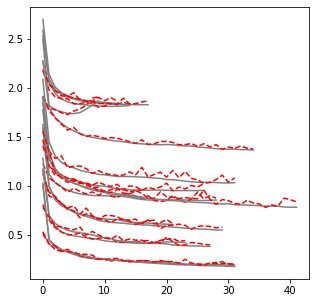

In [112]:
# look at some of the training and vlaidation trajectories
plt.figure(figsize=(5,5) )
for train_loss,val_loss in zip(train_losses_load[::5],val_losses_load[::5]):
    plt.plot(train_loss,color="gray")
    plt.plot(val_loss, "--",color="red")

[100, 126, 112, 91, 34, 20] 0


<IPython.core.display.Javascript object>


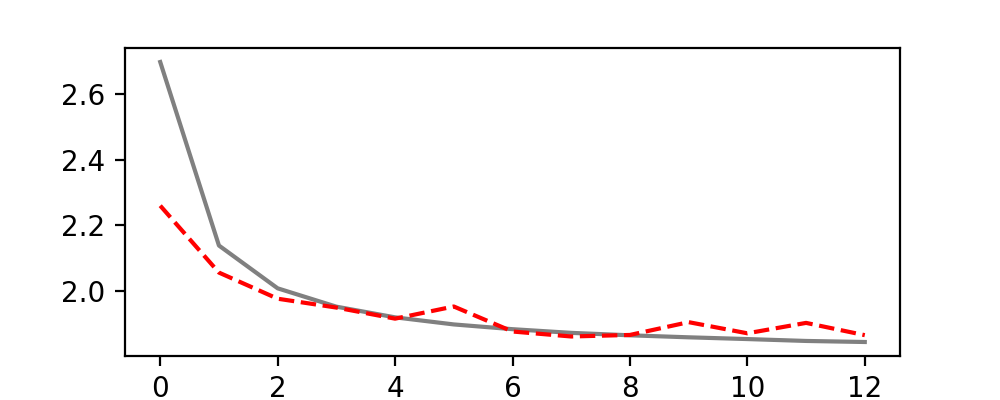

[100, 141, 122, 107, 94, 40, 20] 1


<IPython.core.display.Javascript object>


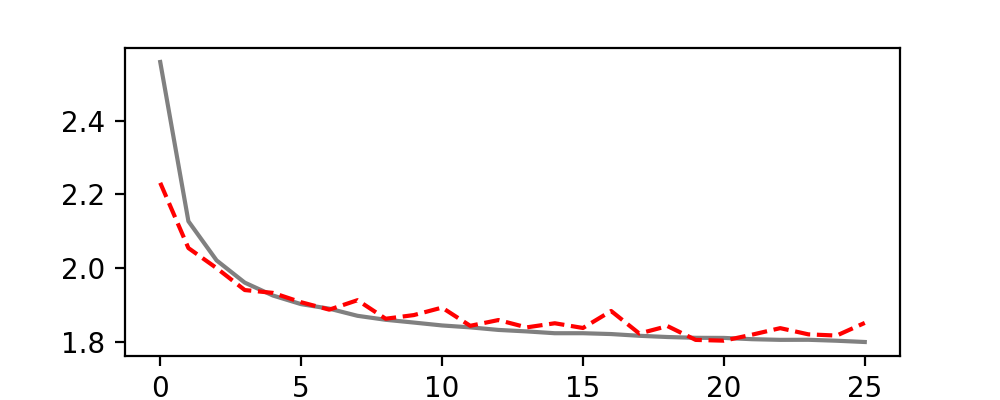

[100, 123, 119, 107, 72, 21, 20] 2


<IPython.core.display.Javascript object>


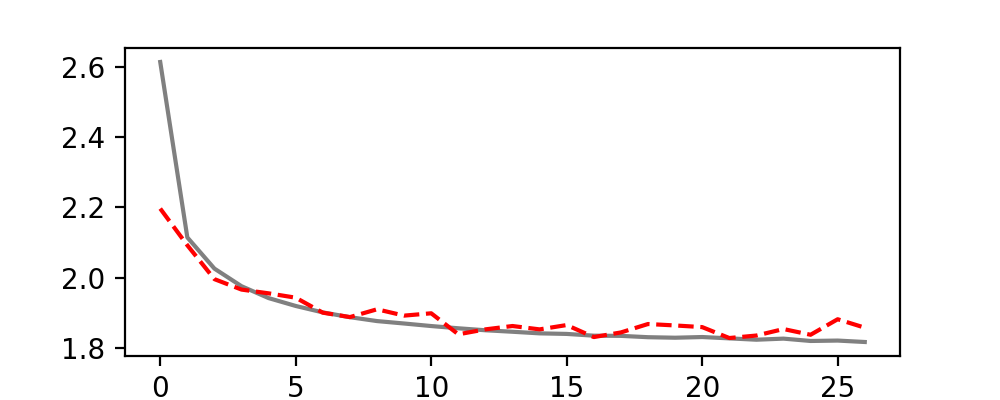

[100, 149, 77, 57, 40, 20] 3


<IPython.core.display.Javascript object>


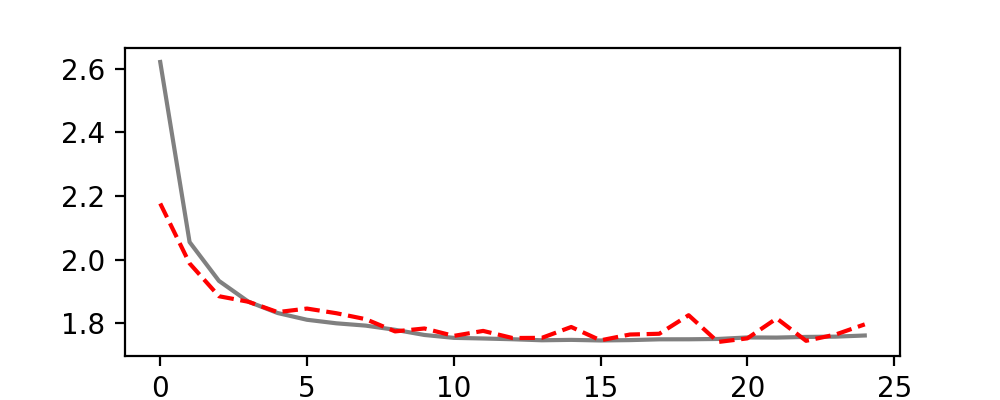

[100, 108, 78, 70, 68, 34, 20] 4


<IPython.core.display.Javascript object>


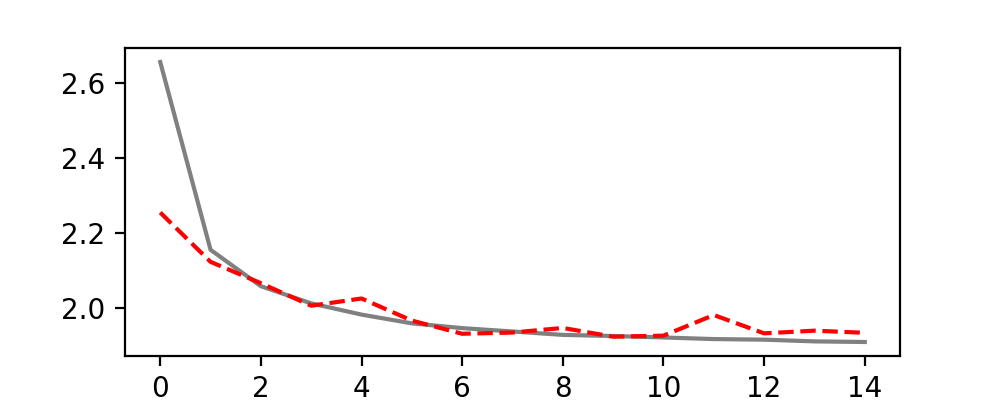

[100, 83, 74, 70, 40, 20] 5


<IPython.core.display.Javascript object>


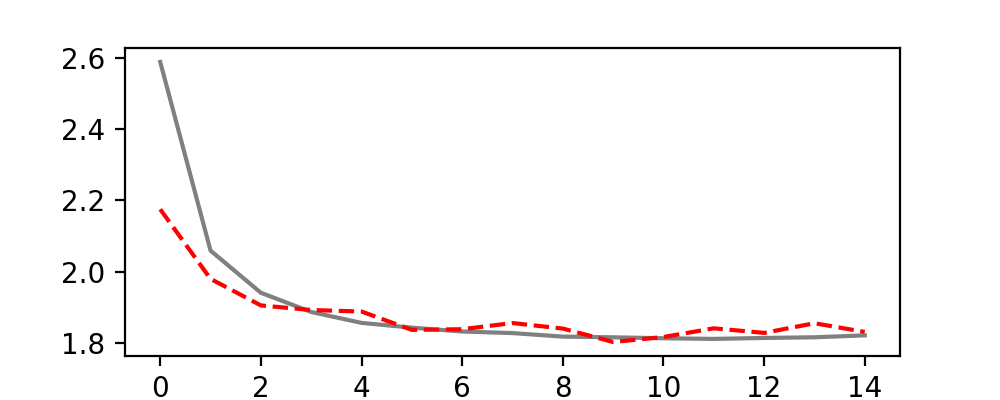

[100, 37, 20] 6


<IPython.core.display.Javascript object>


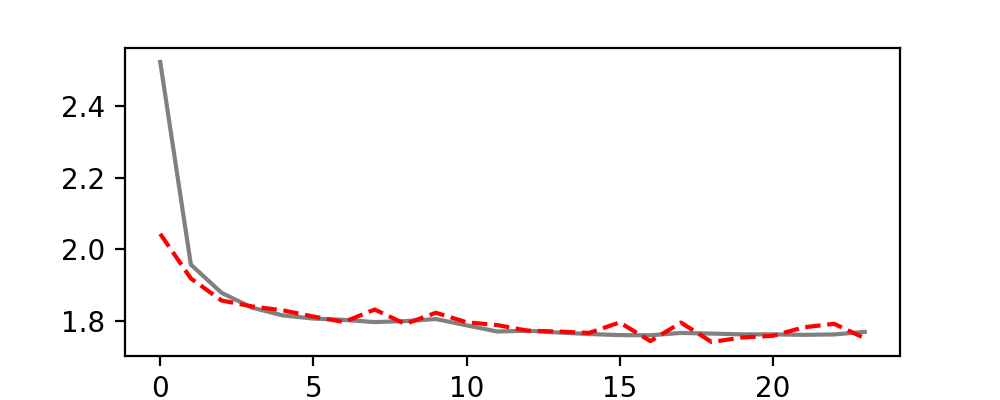

[100, 108, 79, 33, 28, 20] 7


<IPython.core.display.Javascript object>


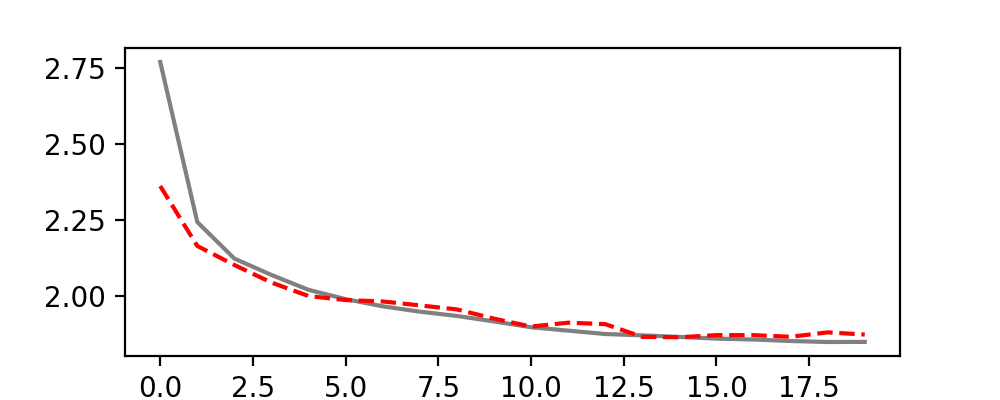

[100, 149, 72, 20] 8


<IPython.core.display.Javascript object>


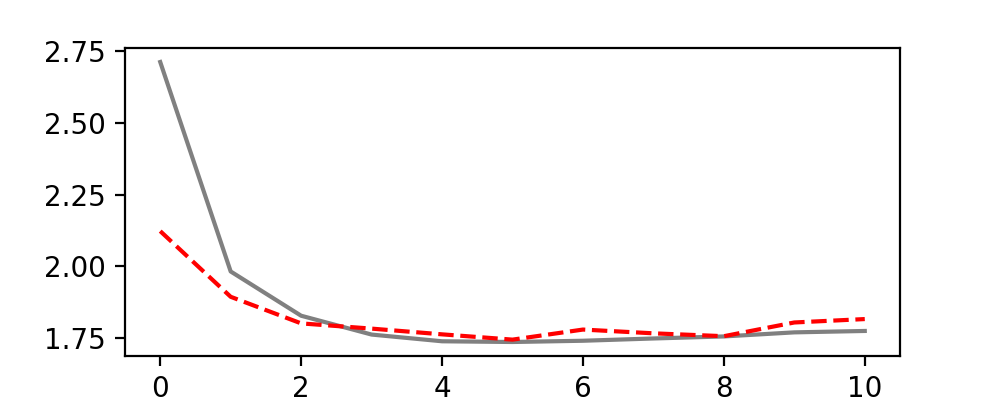

[100, 130, 111, 54, 27, 20] 9


<IPython.core.display.Javascript object>


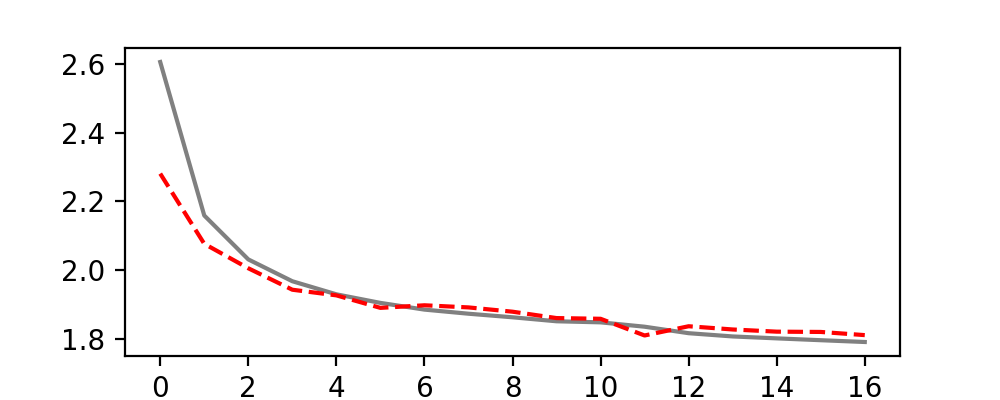

[100, 69, 20] 10


<IPython.core.display.Javascript object>


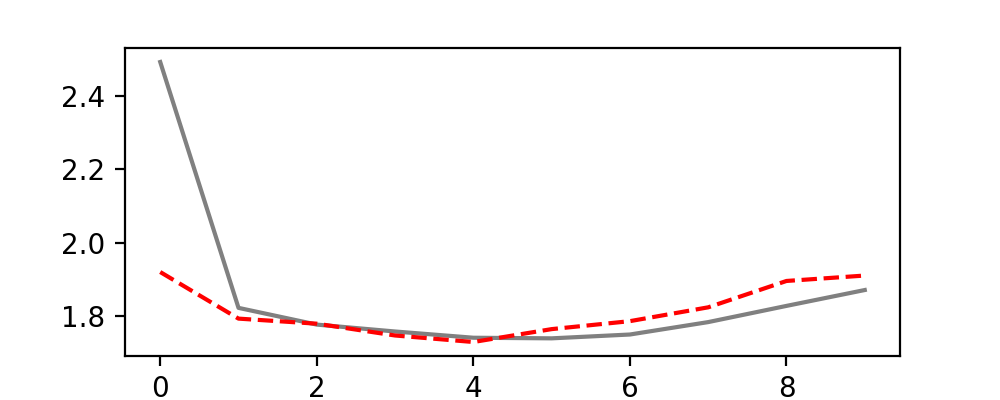

[100, 125, 73, 23, 21, 20] 11


<IPython.core.display.Javascript object>


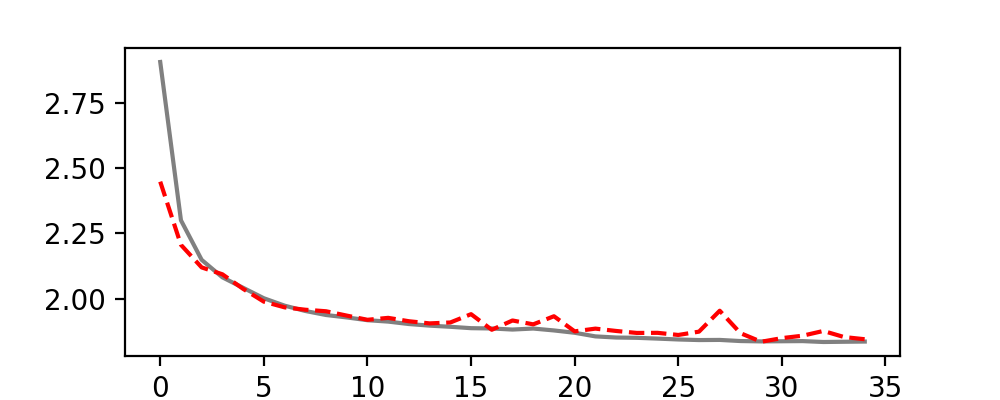

[100, 114, 67, 63, 34, 33, 20] 12


<IPython.core.display.Javascript object>


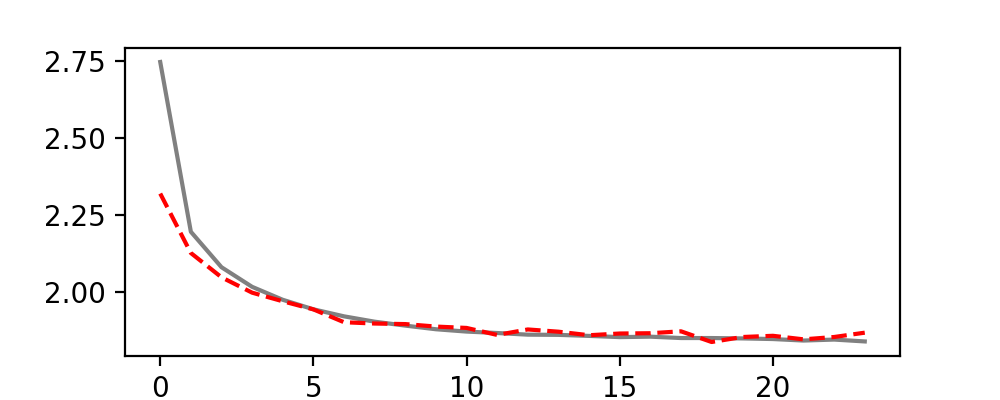

[100, 130, 101, 72, 59, 20] 13


<IPython.core.display.Javascript object>


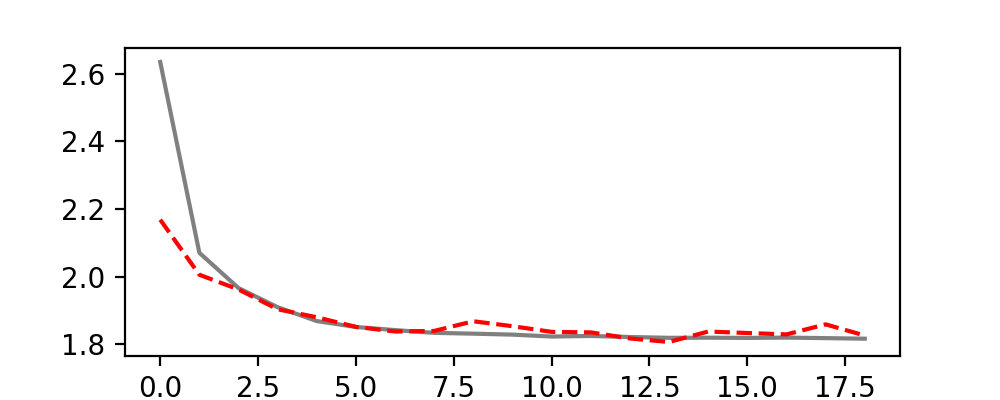

[100, 143, 60, 20] 14


<IPython.core.display.Javascript object>


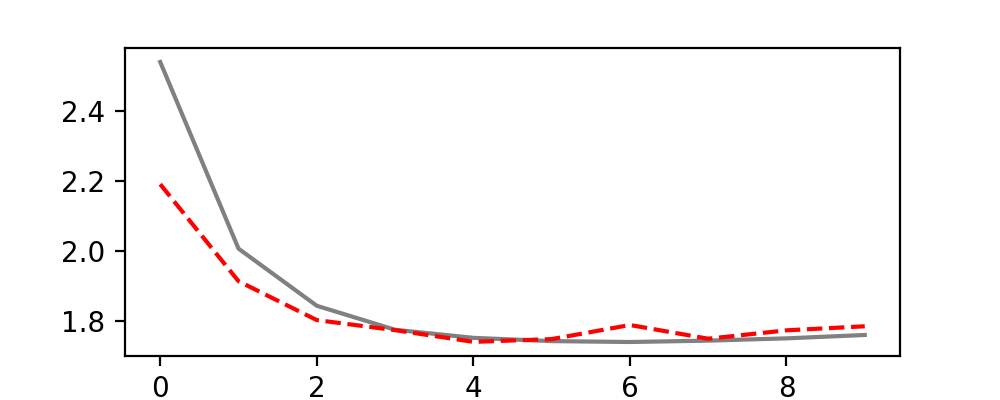

[100, 108, 90, 84, 64, 34, 20] 15


<IPython.core.display.Javascript object>


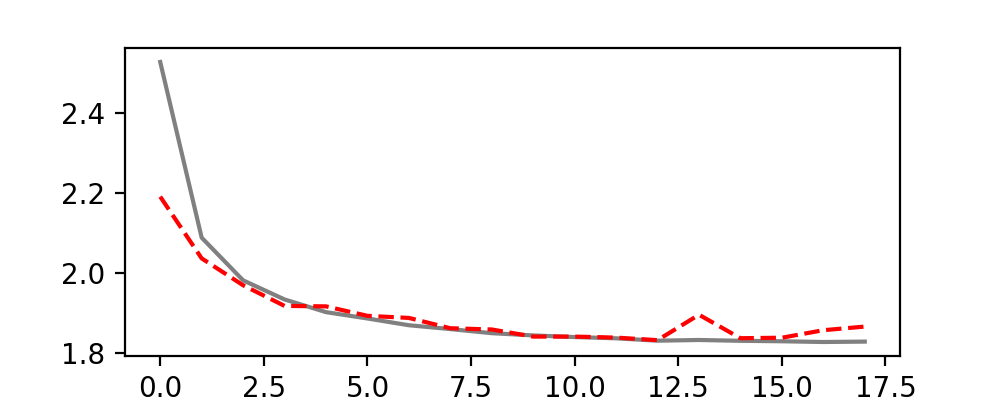

[100, 107, 20] 16


<IPython.core.display.Javascript object>


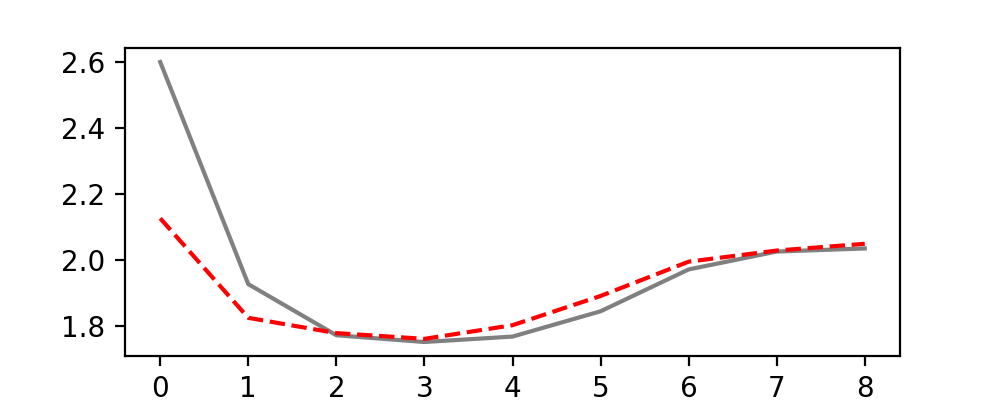

[100, 82, 20] 17


<IPython.core.display.Javascript object>


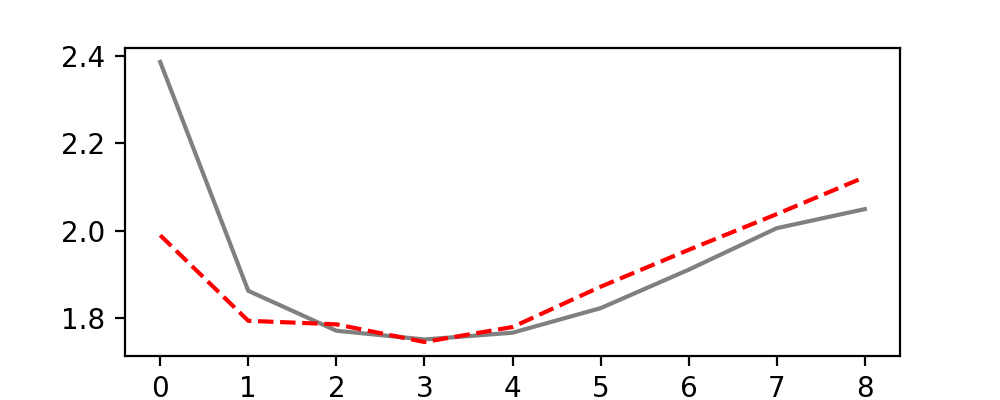

[100, 142, 100, 52, 20] 18


<IPython.core.display.Javascript object>


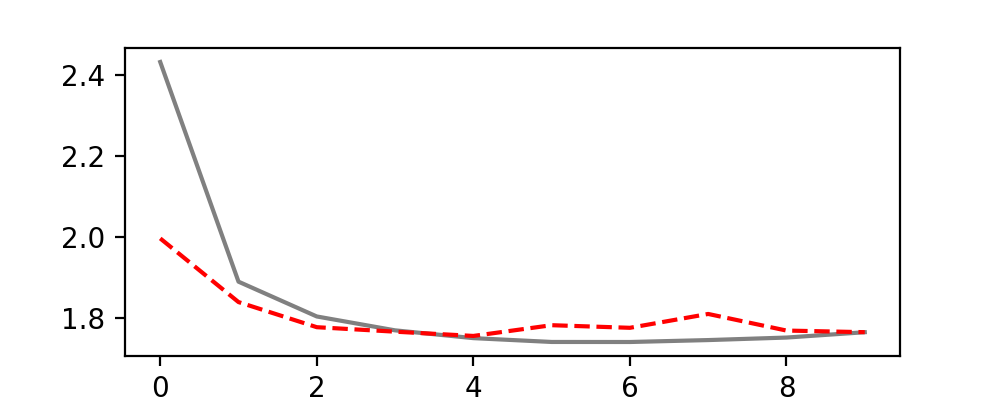

[100, 91, 60, 52, 47, 31, 20] 19


<IPython.core.display.Javascript object>


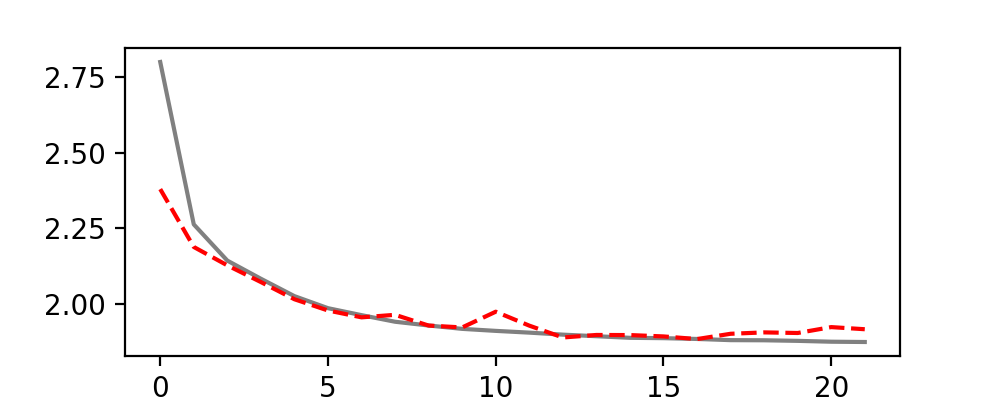

In [139]:
# scrutinse further
num = 20
for train_loss,val_loss, shape in zip(train_losses_load[:num],val_losses_load[:num], shapes):
    print(shape)
    plt.figure(figsize=(5,5) )
    plt.plot(train_loss,color="gray")
    plt.plot(val_loss, "--",color="red")
    plt.show()

In [113]:
depths = np.array([len(arr) for arr in shapes_load]) # get number of layers
mean_widths = np.array([sum(arr)/len(arr) for arr in shapes_load]) # get mean width
final_val_loss = np.array([val_traj[-1] for val_traj in val_losses_load]) # get los validation loss

<IPython.core.display.Javascript object>


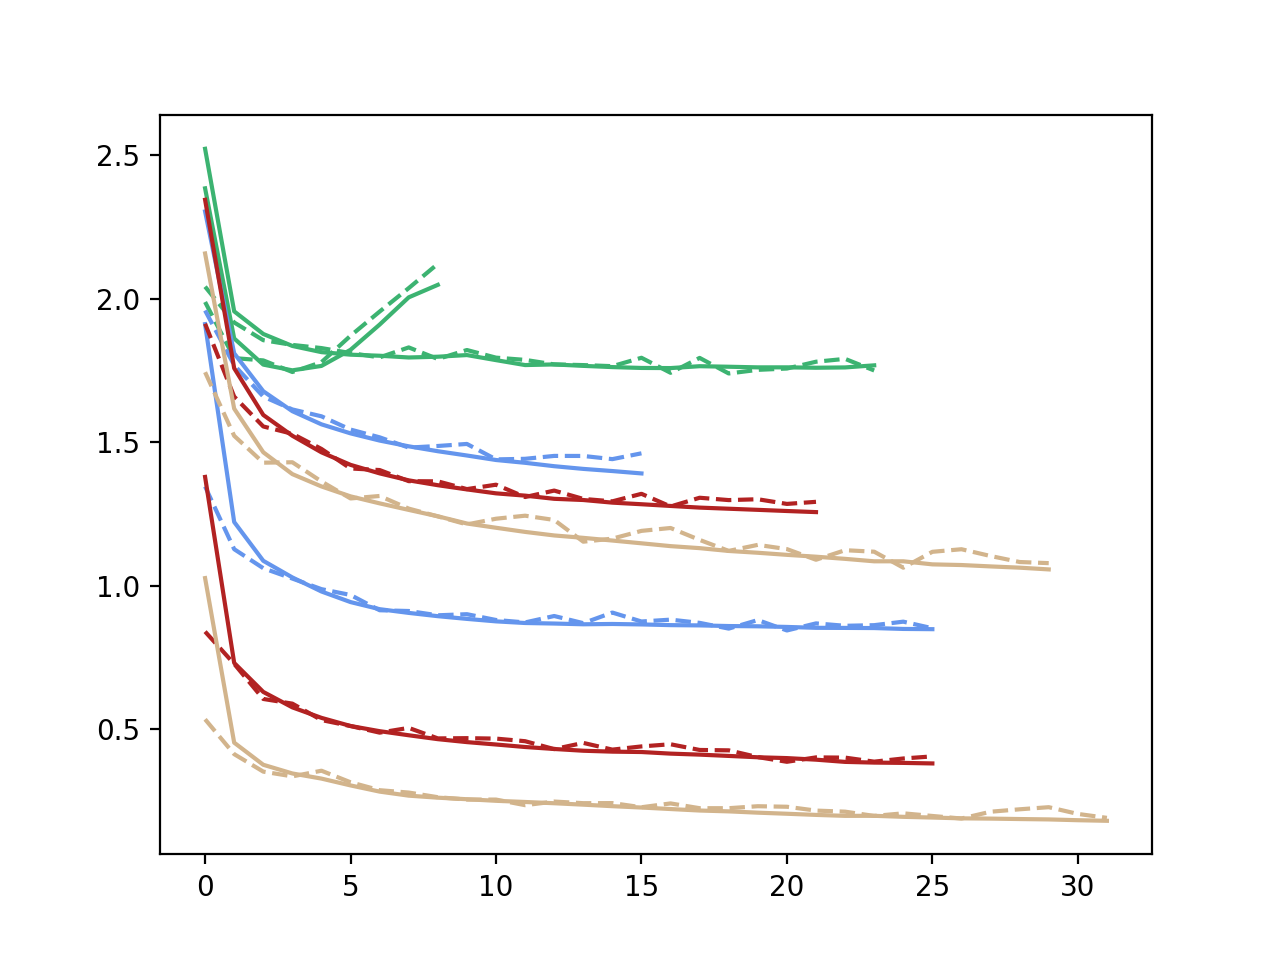

In [127]:
plt.figure()
cols = ["mediumseagreen", "cornflowerblue", "firebrick", "tan", "black"]
for b in range(4):
    temp_losses = final_val_loss[b*iterations:(b+1)*iterations]
    # get index of best and worse architecture
    best_ind = np.argmin(temp_losses)
    worst_ind = np.argmax(temp_losses)
    plt.plot(train_losses_load[b*iterations:(b+1)*iterations][best_ind],color=cols[b])
    plt.plot(val_losses_load[b*iterations:(b+1)*iterations][best_ind], "--",color=cols[b])
    plt.plot(train_losses_load[b*iterations:(b+1)*iterations][worst_ind],color=cols[b])
    plt.plot(val_losses_load[b*iterations:(b+1)*iterations][worst_ind], "--",color=cols[b])
plt.show()

In [128]:
def plot_quartiles(data, color="black", top_K=None,offset=0):
    if top_K == None:
        top_K = data.shape[0]
    mins, low_qs, meds, upp_qs, maxs = np.percentile(data[:top_K], [0,25,50,75,100],axis=1)
    low_diffs = low_qs - mins # from min to lower quartile
    upp_diffs = maxs - upp_qs # from upper quartile to max
    Ks = np.arange(top_K)
    # plot upper quartile
    plt.errorbar(Ks+offset, upp_qs, yerr=np.stack(( np.zeros(top_K), upp_diffs )), #yerr is (below error, above error)
                 fmt="none",ecolor=color,elinewidth=0.8)
    # plot median
    plt.plot(Ks+offset, meds, "_", color=color)
    # plot upper quartile
    plt.errorbar(Ks+offset, low_qs, yerr=np.stack(( low_diffs, np.zeros(top_K) )), #yerr is (below error, above error)
                 fmt="none",ecolor=color,elinewidth=0.8)

In [129]:
bottle_neck_losses = final_val_loss.reshape((4,-1))

<IPython.core.display.Javascript object>


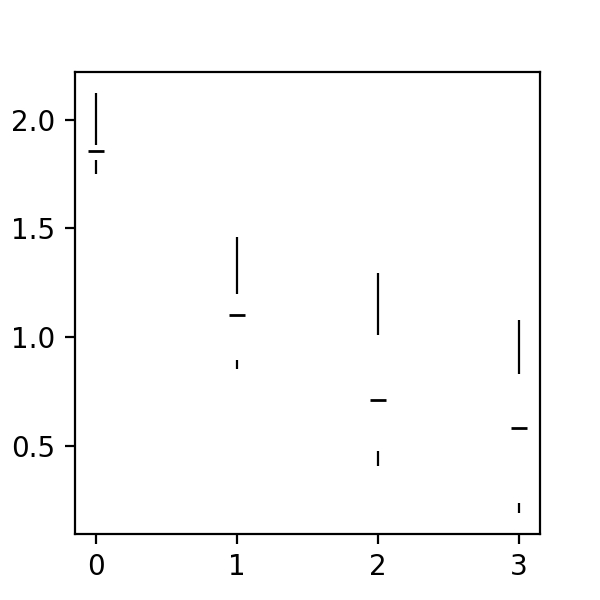

In [132]:
plt.figure(figsize=(3,3))
plot_quartiles(bottle_neck_losses)

<IPython.core.display.Javascript object>


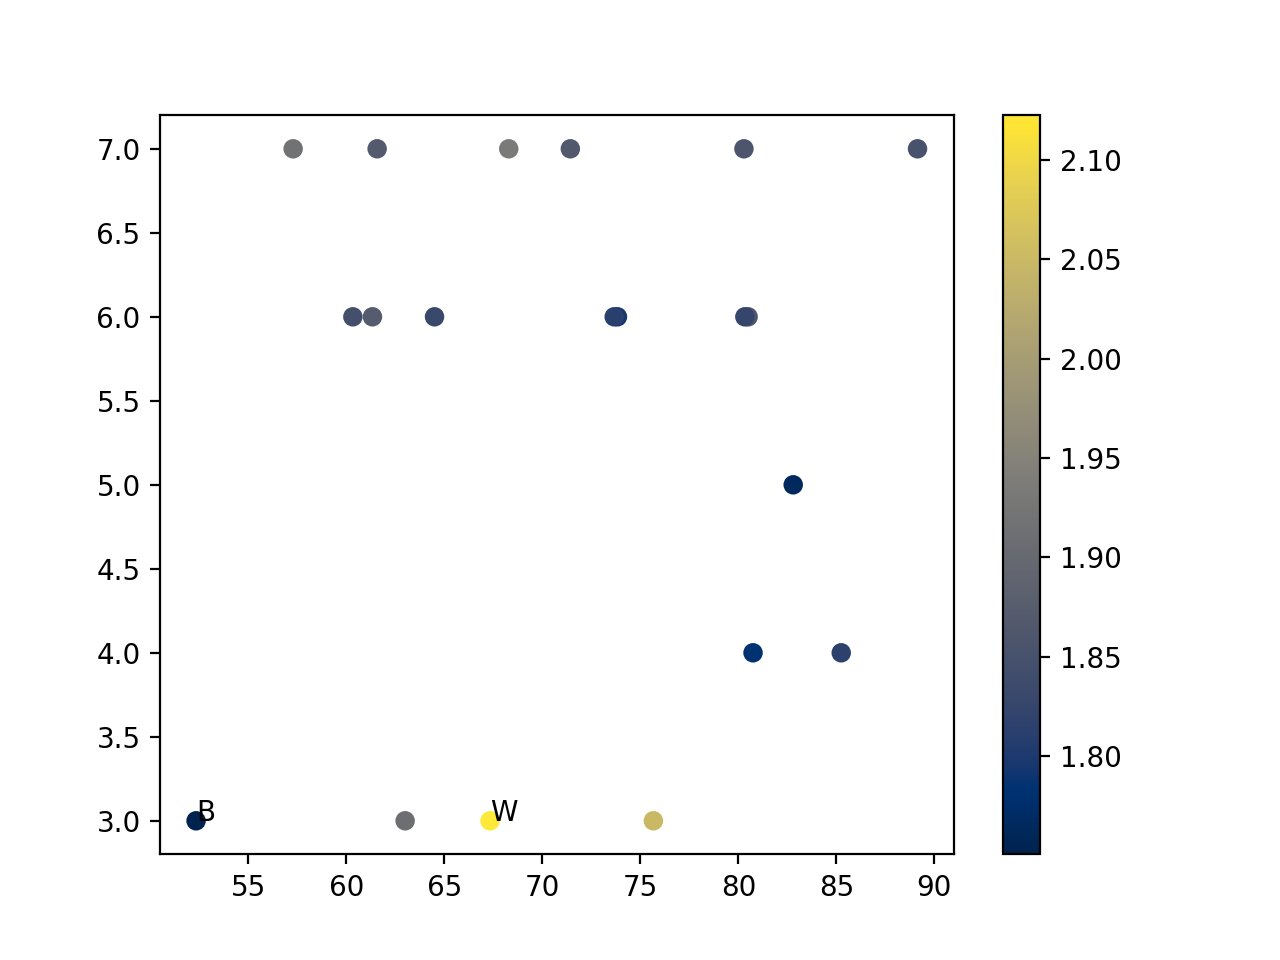

Best [100, 37, 20]
Worst [100, 82, 20]


<IPython.core.display.Javascript object>


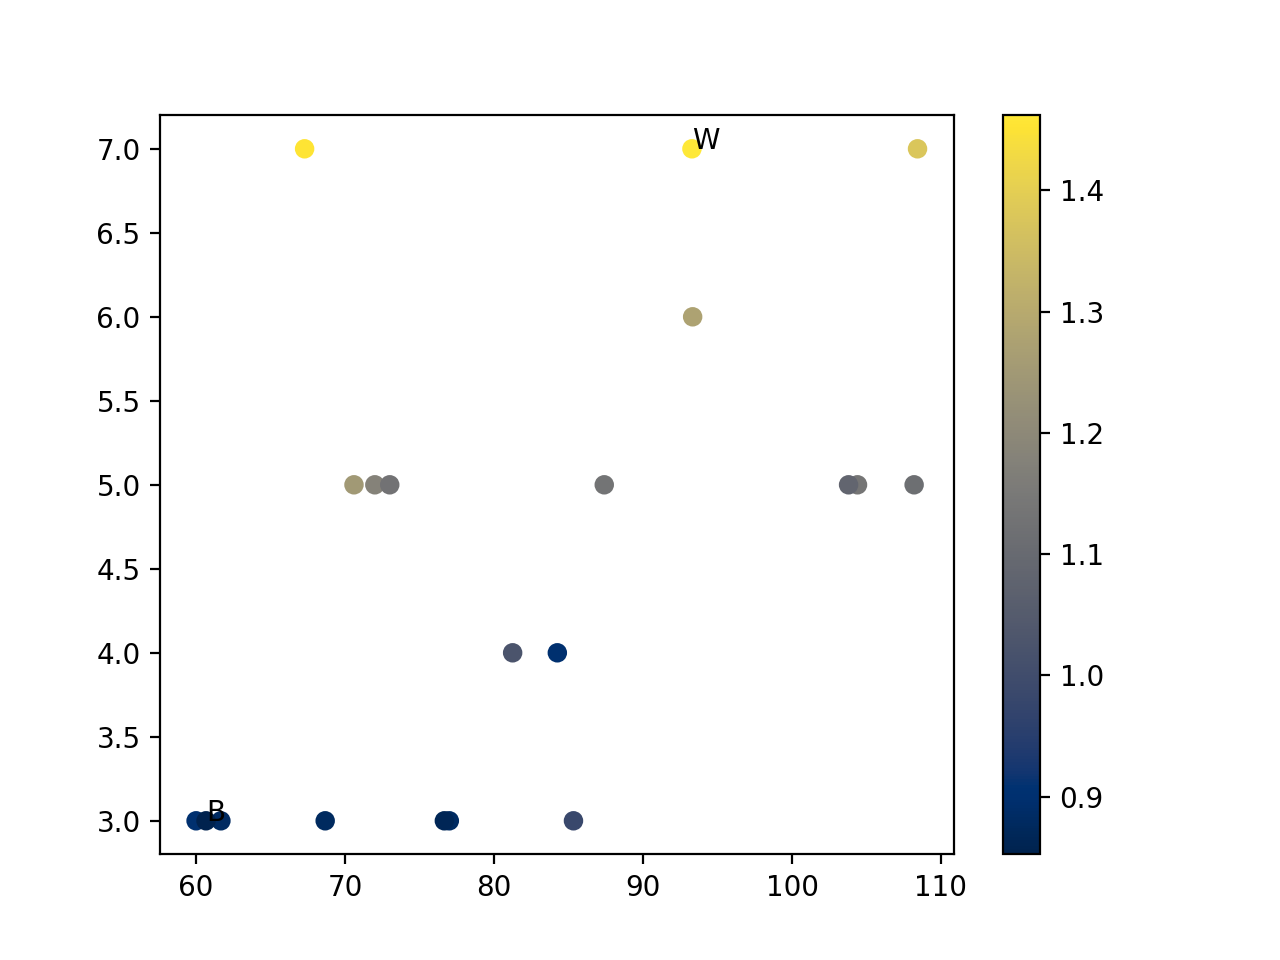

Best [100, 42, 40]
Worst [100, 140, 135, 133, 62, 43, 40]


<IPython.core.display.Javascript object>


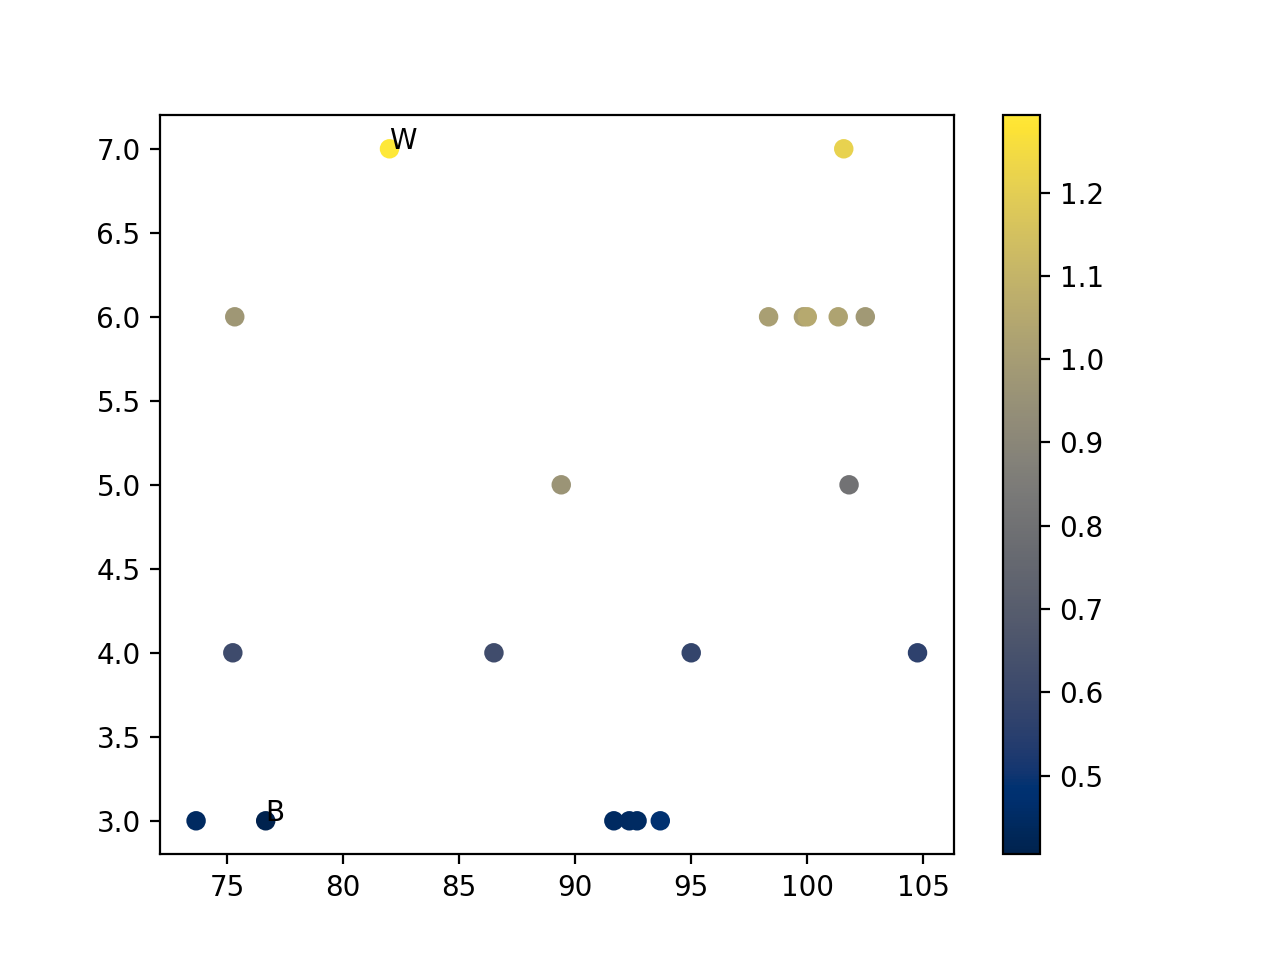

Best [100, 70, 60]
Worst [100, 112, 103, 78, 61, 60, 60]


<IPython.core.display.Javascript object>


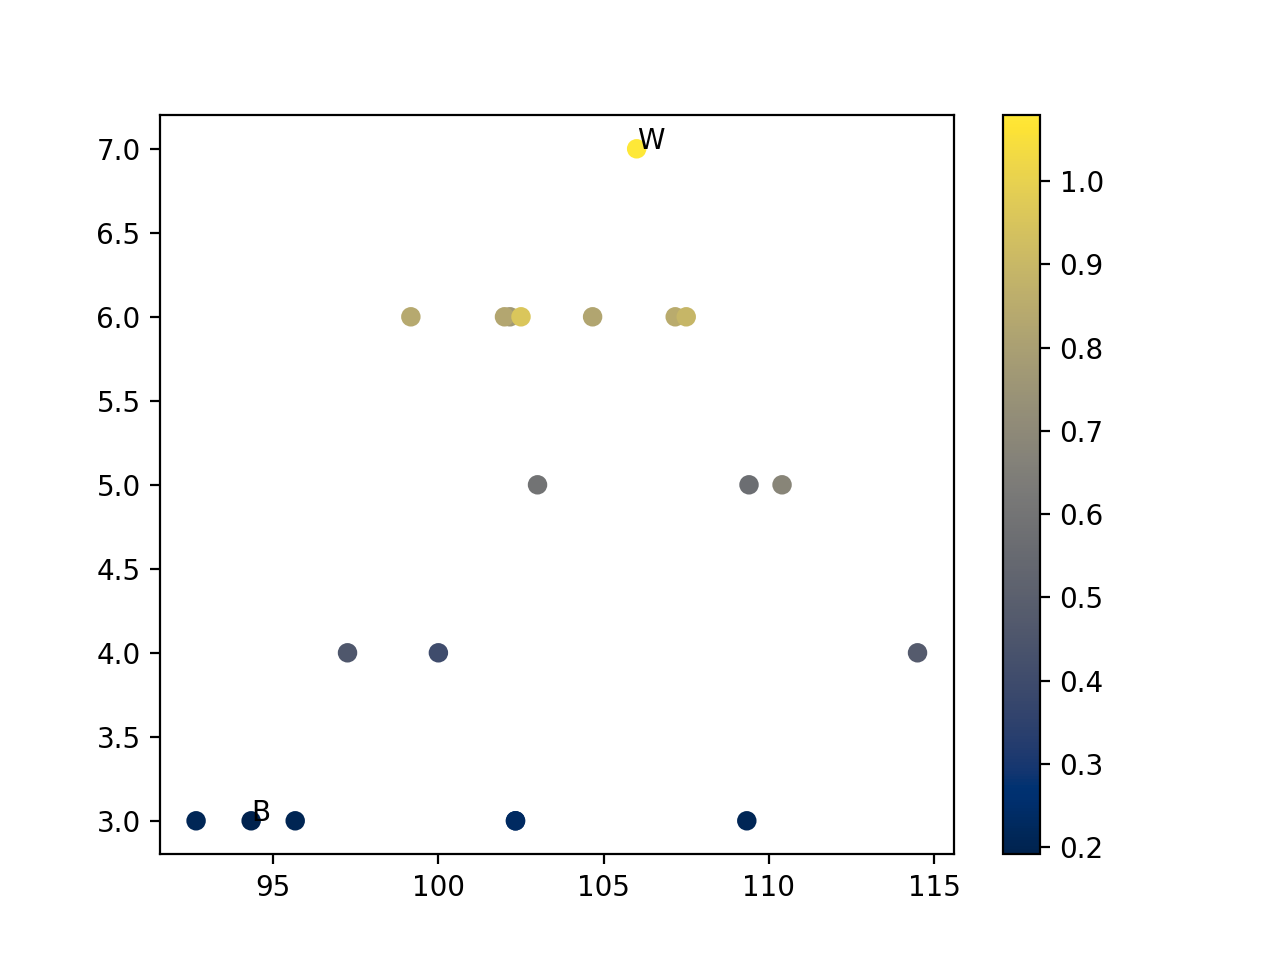

Best [100, 103, 80]
Worst [100, 133, 130, 106, 106, 87, 80]


In [133]:
for b in range(4):
    plt.figure()
    cmap = plt.get_cmap("cividis")
    temp_widths = mean_widths[b*iterations:(b+1)*iterations]
    temp_depths = depths[b*iterations:(b+1)*iterations]
    temp_losses = final_val_loss[b*iterations:(b+1)*iterations]
    plt.scatter(temp_widths,temp_depths, c=temp_losses, cmap=cmap)
    plt.colorbar()
    # get index of best and worse architecture
    best_ind = np.argmin(temp_losses)
    worst_ind = np.argmax(temp_losses)
    print("Best", str(shapes[b*iterations:(b+1)*iterations][best_ind]) )
    print("Worst", str(shapes[b*iterations:(b+1)*iterations][worst_ind]))
          
    plt.annotate("B", (temp_widths[best_ind], temp_depths[best_ind]) )
    plt.annotate("W", (temp_widths[worst_ind], temp_depths[worst_ind]) )
    plt.show()

## Retrain best models and report hamming distances, etc.

In [119]:
np.random.seed(43)
torch.manual_seed(1)
models = []
for b in range(4):
    temp_losses = final_val_loss[b*iterations:(b+1)*iterations]
    best_ind = np.argmin(temp_losses)
    best_shape = shapes_load[b*iterations:(b+1)*iterations][best_ind] 
    encoder_layer_dims = best_shape
    decoder_layer_dims = encoder_layer_dims[::-1]
    models.append(Autoencoder(encoder_layer_dims, decoder_layer_dims).to(device))
    print("Model with shape", best_shape, "added." )

Model with shape [100, 37, 20] added.
Model with shape [100, 42, 40] added.
Model with shape [100, 70, 60] added.
Model with shape [100, 103, 80] added.


In [120]:
train_losses = []
val_losses = []
for i in range(4):
    # check it trains
    models[i], train_loss, val_loss = train(models[i], train_data_loader, 30,lr=1e-3,loss_fn=eucl)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2233.93it/s]


0. Train loss: 2.54, Val loss: 2.03


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2072.61it/s]


1. Train loss: 1.95, Val loss: 1.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2290.32it/s]


2. Train loss: 1.86, Val loss: 1.83


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2335.15it/s]


3. Train loss: 1.79, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2328.01it/s]


4. Train loss: 1.76, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2238.56it/s]


5. Train loss: 1.76, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2093.90it/s]


6. Train loss: 1.77, Val loss: 1.8


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2147.73it/s]


7. Train loss: 1.78, Val loss: 1.8


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2173.26it/s]


8. Train loss: 1.79, Val loss: 1.9


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2193.13it/s]


9. Train loss: 1.79, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2145.73it/s]


10. Train loss: 1.79, Val loss: 1.83


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2192.41it/s]


11. Train loss: 1.78, Val loss: 1.78


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2170.88it/s]


12. Train loss: 1.78, Val loss: 1.78


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2272.65it/s]


13. Train loss: 1.78, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2319.62it/s]


14. Train loss: 1.78, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2343.71it/s]


15. Train loss: 1.78, Val loss: 1.8


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2346.50it/s]


16. Train loss: 1.78, Val loss: 1.77


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2333.53it/s]


17. Train loss: 1.78, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2363.56it/s]


18. Train loss: 1.78, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2344.98it/s]


19. Train loss: 1.78, Val loss: 1.8


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2347.21it/s]


20. Train loss: 1.78, Val loss: 1.81


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2340.37it/s]


21. Train loss: 1.78, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2158.97it/s]


22. Train loss: 1.78, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2192.68it/s]


23. Train loss: 1.79, Val loss: 1.85


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2151.35it/s]


24. Train loss: 1.8, Val loss: 1.83


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2233.95it/s]


25. Train loss: 1.8, Val loss: 1.79


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2182.23it/s]


26. Train loss: 1.81, Val loss: 1.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2129.46it/s]


27. Train loss: 1.82, Val loss: 1.82


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2158.85it/s]


28. Train loss: 1.83, Val loss: 1.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2115.07it/s]


29. Train loss: 1.84, Val loss: 1.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2137.68it/s]


0. Train loss: 1.88, Val loss: 1.26


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2138.45it/s]


1. Train loss: 1.16, Val loss: 1.12


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2196.04it/s]


2. Train loss: 1.07, Val loss: 1.03


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2262.92it/s]


3. Train loss: 1.01, Val loss: 1.0


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2135.20it/s]


4. Train loss: 0.98, Val loss: 0.98


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2239.45it/s]


5. Train loss: 0.95, Val loss: 0.95


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2025.70it/s]


6. Train loss: 0.93, Val loss: 0.93


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2085.22it/s]


7. Train loss: 0.92, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2262.50it/s]


8. Train loss: 0.9, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2259.69it/s]


9. Train loss: 0.89, Val loss: 0.92


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2260.56it/s]


10. Train loss: 0.88, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2083.77it/s]


11. Train loss: 0.88, Val loss: 0.91


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2132.82it/s]


12. Train loss: 0.88, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2060.09it/s]


13. Train loss: 0.87, Val loss: 0.9


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2067.79it/s]


14. Train loss: 0.87, Val loss: 0.89


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2223.35it/s]


15. Train loss: 0.86, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2253.50it/s]


16. Train loss: 0.86, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2260.97it/s]


17. Train loss: 0.85, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2269.12it/s]


18. Train loss: 0.85, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2254.98it/s]


19. Train loss: 0.85, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2272.57it/s]


20. Train loss: 0.85, Val loss: 0.87


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2261.18it/s]


21. Train loss: 0.85, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2195.82it/s]


22. Train loss: 0.85, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2257.52it/s]


23. Train loss: 0.84, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2257.59it/s]


24. Train loss: 0.84, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2252.06it/s]


25. Train loss: 0.84, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2247.89it/s]


26. Train loss: 0.84, Val loss: 0.88


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2198.52it/s]


27. Train loss: 0.84, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2101.37it/s]


28. Train loss: 0.84, Val loss: 0.86


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 2123.17it/s]


29. Train loss: 0.84, Val loss: 0.85


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1642.22it/s]


0. Train loss: 1.33, Val loss: 0.77


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1528.49it/s]


1. Train loss: 0.69, Val loss: 0.66


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1736.27it/s]


2. Train loss: 0.61, Val loss: 0.58


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1843.61it/s]


3. Train loss: 0.57, Val loss: 0.56


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1875.27it/s]


4. Train loss: 0.53, Val loss: 0.54


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1869.49it/s]


5. Train loss: 0.51, Val loss: 0.49


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1873.36it/s]


6. Train loss: 0.49, Val loss: 0.5


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1839.59it/s]


7. Train loss: 0.48, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1856.07it/s]


8. Train loss: 0.47, Val loss: 0.47


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1870.69it/s]


9. Train loss: 0.45, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1855.21it/s]


10. Train loss: 0.44, Val loss: 0.45


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1873.32it/s]


11. Train loss: 0.43, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1866.87it/s]


12. Train loss: 0.43, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1877.41it/s]


13. Train loss: 0.42, Val loss: 0.46


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1880.28it/s]


14. Train loss: 0.41, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1815.37it/s]


15. Train loss: 0.41, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1875.25it/s]


16. Train loss: 0.4, Val loss: 0.43


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1862.78it/s]


17. Train loss: 0.4, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1864.54it/s]


18. Train loss: 0.4, Val loss: 0.41


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1872.26it/s]


19. Train loss: 0.4, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1879.55it/s]


20. Train loss: 0.4, Val loss: 0.44


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1872.62it/s]


21. Train loss: 0.4, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1839.05it/s]


22. Train loss: 0.39, Val loss: 0.42


100%|█████████████████████████████████████| 5671/5671 [00:02<00:00, 1898.35it/s]


23. Train loss: 0.39, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1873.60it/s]


24. Train loss: 0.39, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1880.39it/s]


25. Train loss: 0.39, Val loss: 0.38


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1831.33it/s]


26. Train loss: 0.39, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1825.66it/s]


27. Train loss: 0.38, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1789.52it/s]


28. Train loss: 0.38, Val loss: 0.4


100%|█████████████████████████████████████| 5671/5671 [00:03<00:00, 1865.88it/s]


29. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 548.42it/s]


0. Train loss: 1.05, Val loss: 0.54


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 562.13it/s]


1. Train loss: 0.47, Val loss: 0.45


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 526.92it/s]


2. Train loss: 0.41, Val loss: 0.42


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 559.24it/s]


3. Train loss: 0.38, Val loss: 0.39


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 555.39it/s]


4. Train loss: 0.36, Val loss: 0.35


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 549.59it/s]


5. Train loss: 0.33, Val loss: 0.34


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 609.81it/s]


6. Train loss: 0.33, Val loss: 0.36


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.63it/s]


7. Train loss: 0.31, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 544.60it/s]


8. Train loss: 0.29, Val loss: 0.31


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 528.58it/s]


9. Train loss: 0.28, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 570.37it/s]


10. Train loss: 0.27, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.19it/s]


11. Train loss: 0.26, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 571.90it/s]


12. Train loss: 0.25, Val loss: 0.28


100%|██████████████████████████████████████| 5671/5671 [00:11<00:00, 507.80it/s]


13. Train loss: 0.24, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 604.83it/s]


14. Train loss: 0.24, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 585.78it/s]


15. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 593.01it/s]


16. Train loss: 0.23, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 586.87it/s]


17. Train loss: 0.23, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 587.58it/s]


18. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 613.07it/s]


19. Train loss: 0.22, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 458.54it/s]


20. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 590.13it/s]


21. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 599.01it/s]


22. Train loss: 0.21, Val loss: 0.24


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 625.97it/s]


23. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 591.95it/s]


24. Train loss: 0.21, Val loss: 0.23


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 605.58it/s]


25. Train loss: 0.21, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:12<00:00, 467.74it/s]


26. Train loss: 0.2, Val loss: 0.22


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 527.45it/s]


27. Train loss: 0.2, Val loss: 0.21


100%|██████████████████████████████████████| 5671/5671 [00:10<00:00, 518.26it/s]


28. Train loss: 0.2, Val loss: 0.2


100%|██████████████████████████████████████| 5671/5671 [00:09<00:00, 584.05it/s]


29. Train loss: 0.2, Val loss: 0.2


In [121]:
for ae in models:
    print("Mean hamming distance: ", np.round(torch.mean(hamming(val_data, torch.round(ae(val_data)))).item(),3))

    print("Hamming distances")
    print("%2s %5s %4s %4s" % ("K", "obvs", "mean", "max"))

    for K in range(int(torch.max(Ks))+1):
        states_K_fire = val_data[Ks==K]
        recon = torch.round(ae(states_K_fire))
        ham_dists = hamming(states_K_fire,recon)
        N_samples = states_K_fire.shape[0]
        print("%2s %5s %.2f %3s" % (K, N_samples, float(torch.mean(ham_dists)), int(torch.max(ham_dists)) ))

Mean hamming distance:  2.334
Hamming distances
 K  obvs mean  max
 0 12865 0.00   0
 1  6957 0.19   1
 2  4226 0.84   6
 3  3163 1.50   6
 4  2730 2.20   7
 5  2401 2.92  10
 6  2156 3.61   9
 7  1940 4.36  11
 8  1622 5.16  13
 9  1556 5.78  12
10  1272 6.56  14
11  1001 7.10  15
12   857 7.90  15
13   641 8.56  16
14   535 9.41  17
15   412 10.01  17
16   322 11.02  19
17   242 11.79  19
18   163 12.70  18
19   127 13.49  22
20    73 13.78  19
21    41 15.05  21
22    26 16.73  20
23    23 16.22  21
24     7 18.71  23
25     3 22.33  24
26     2 18.50  19
Mean hamming distance:  1.056
Hamming distances
 K  obvs mean  max
 0 12865 0.00   0
 1  6957 0.02   1
 2  4226 0.11   3
 3  3163 0.32   4
 4  2730 0.60   5
 5  2401 0.93   7
 6  2156 1.38   7
 7  1940 1.81   8
 8  1622 2.29   8
 9  1556 2.66  12
10  1272 3.31  10
11  1001 3.69  11
12   857 4.25  11
13   641 4.74  13
14   535 5.60  14
15   412 5.96  15
16   322 6.62  14
17   242 7.38  18
18   163 8.07  19
19   127 8.52  14
20    73

## Visual assessment or reconstructions

In [146]:
arr = np.load("../data/shuffled_data/data2014.npy") #load orignal data-set
NN = 100
og_data = torch.tensor(arr).float().T[:,:NN] # take first NN neurons for now
og_data.shape

In [172]:
extract = og_data[100:400]
recons = []
for ae in models:
    recon = torch.round(ae(extract))
    recons.append(recon)

<IPython.core.display.Javascript object>


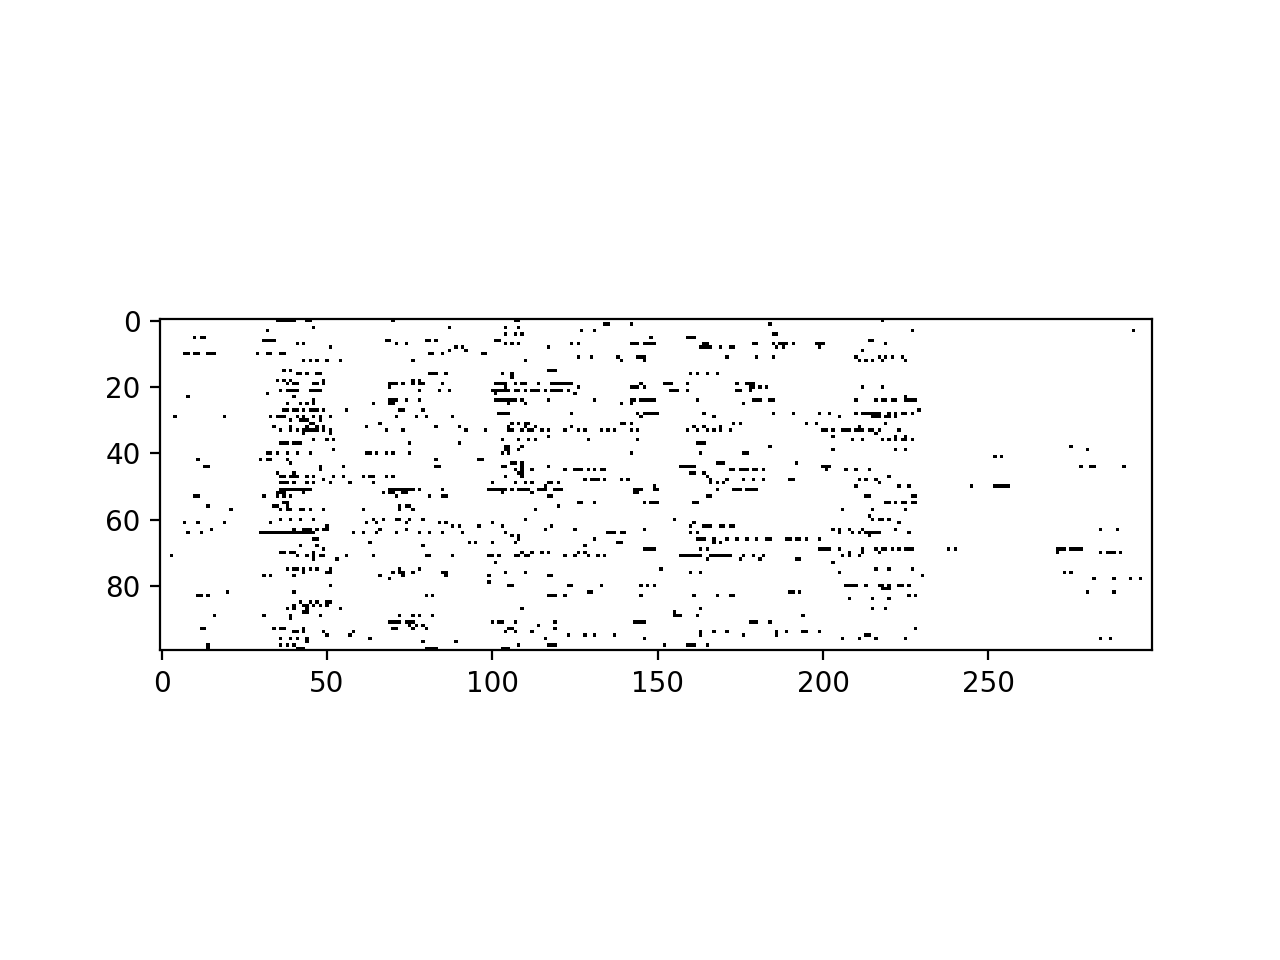

<IPython.core.display.Javascript object>


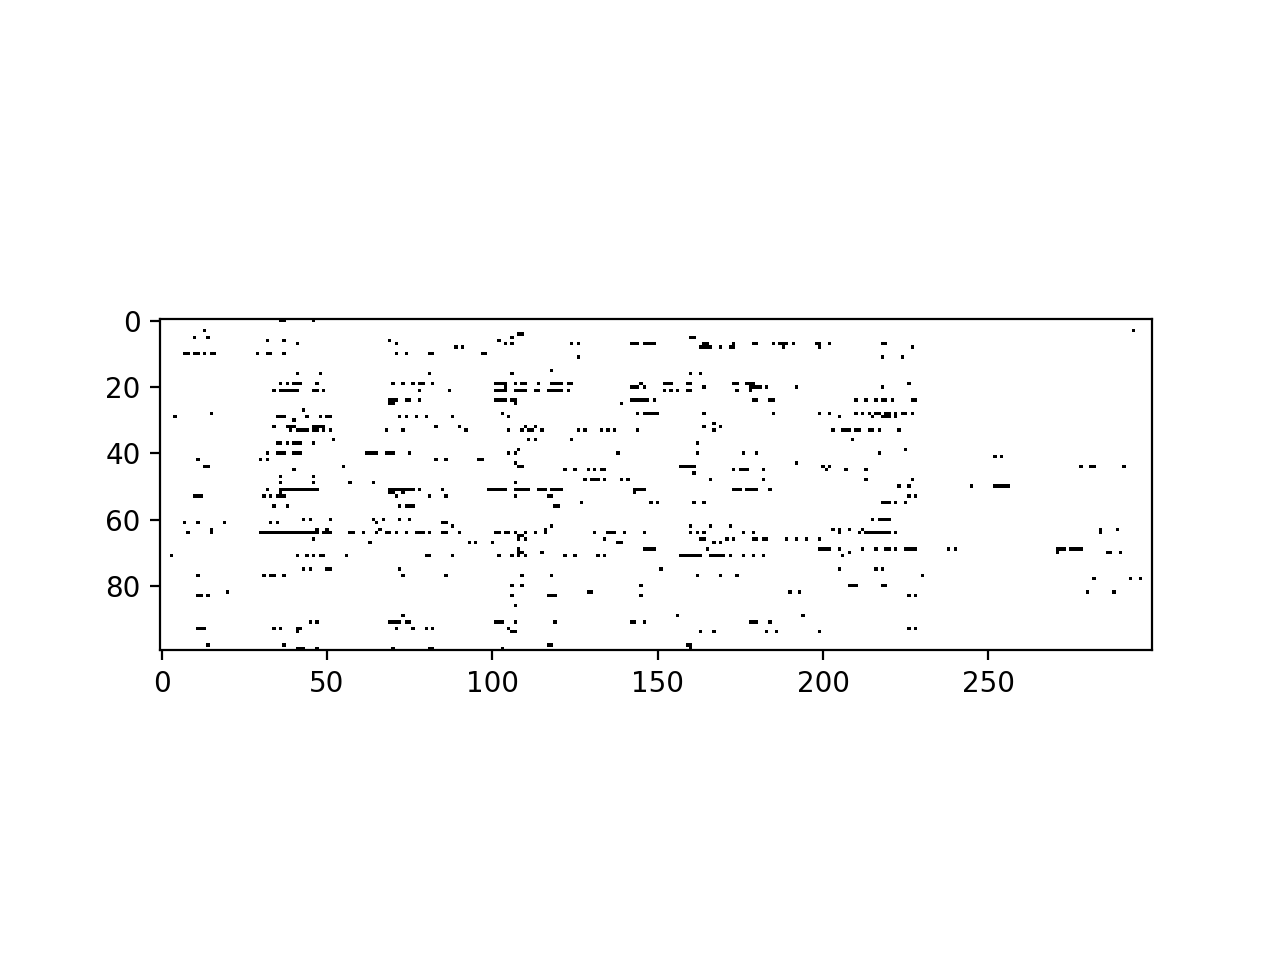

<IPython.core.display.Javascript object>


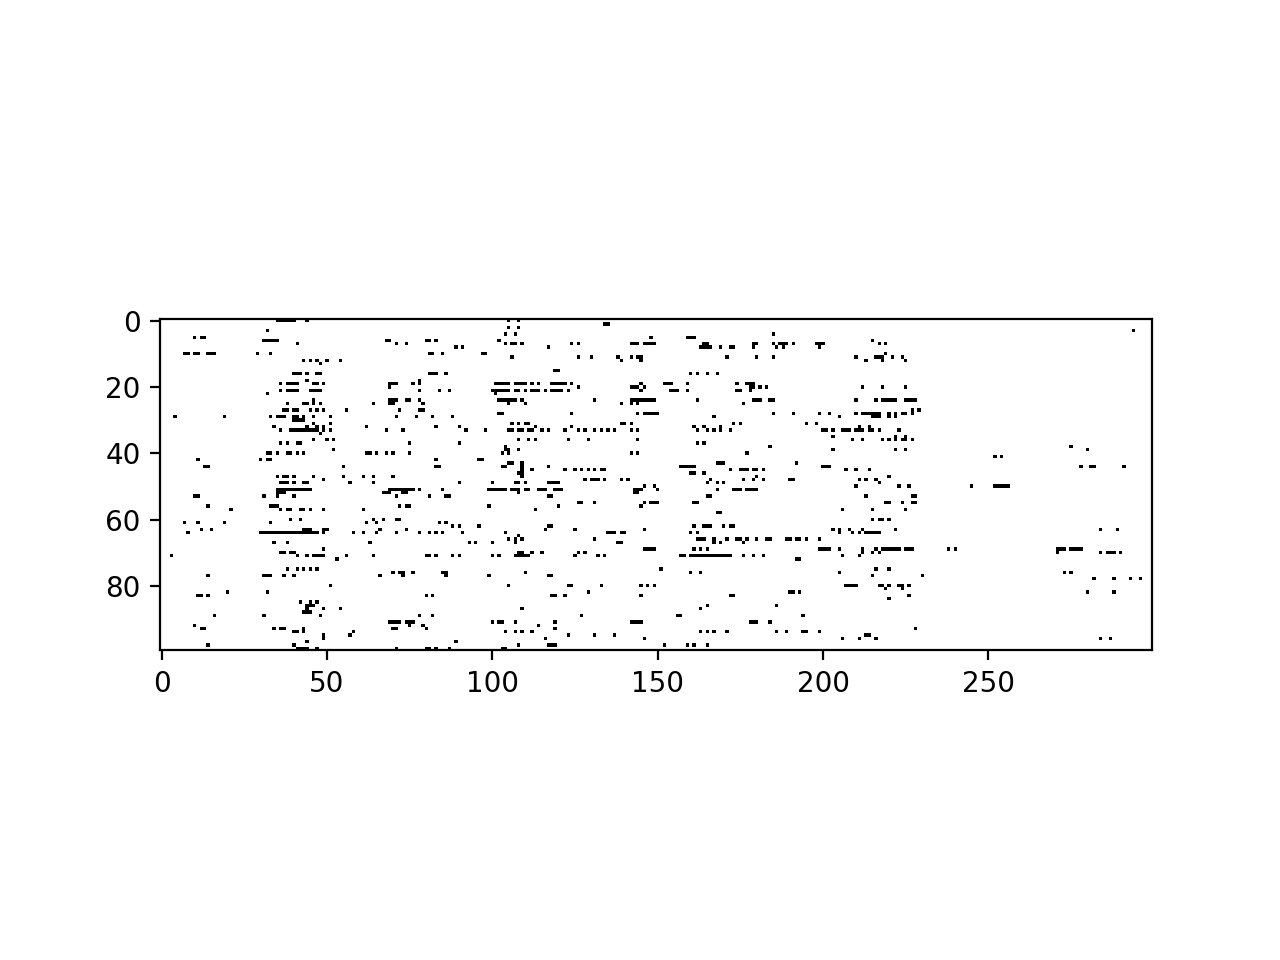

<IPython.core.display.Javascript object>


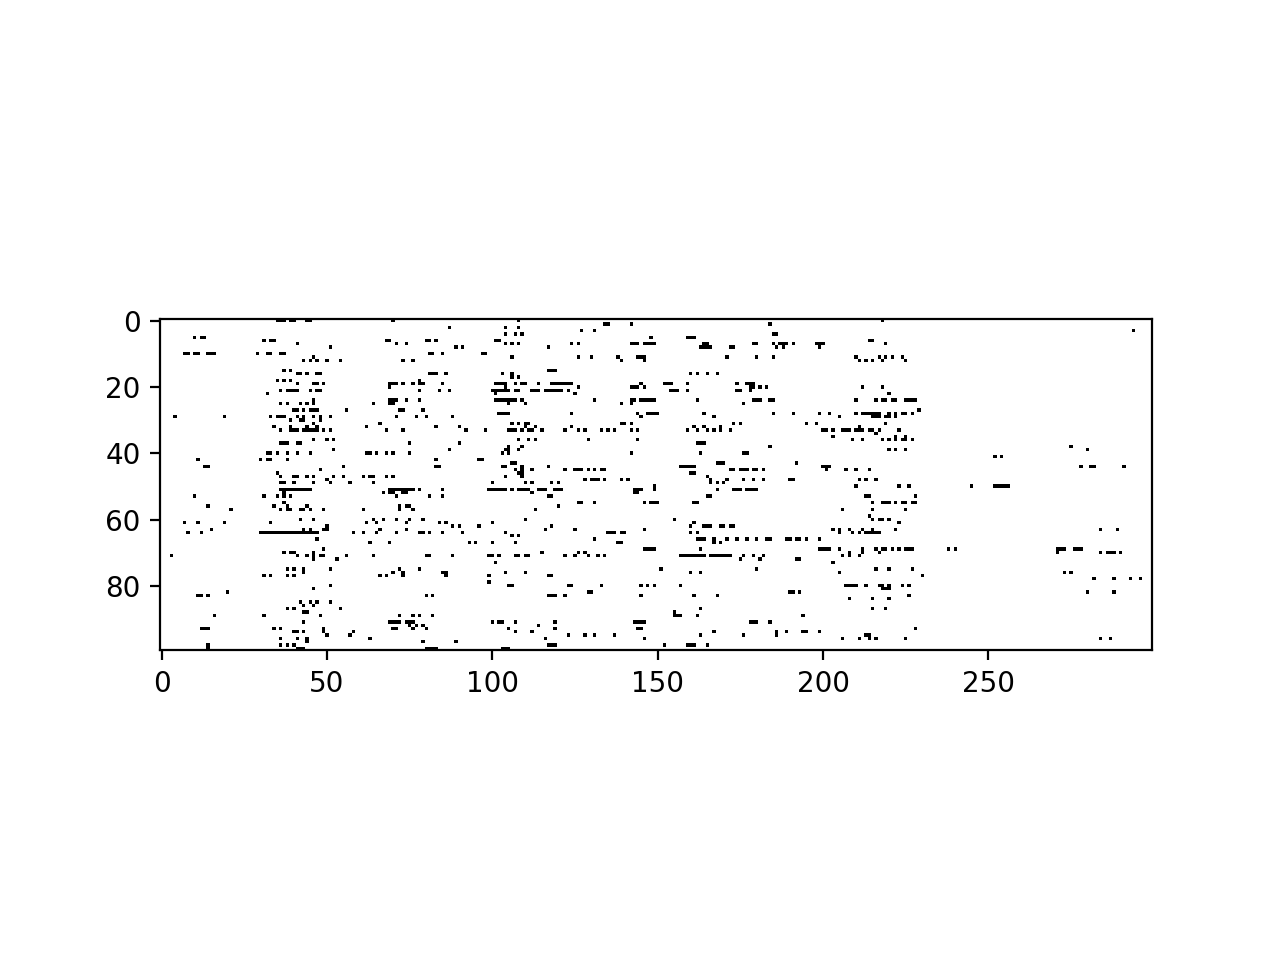

<IPython.core.display.Javascript object>


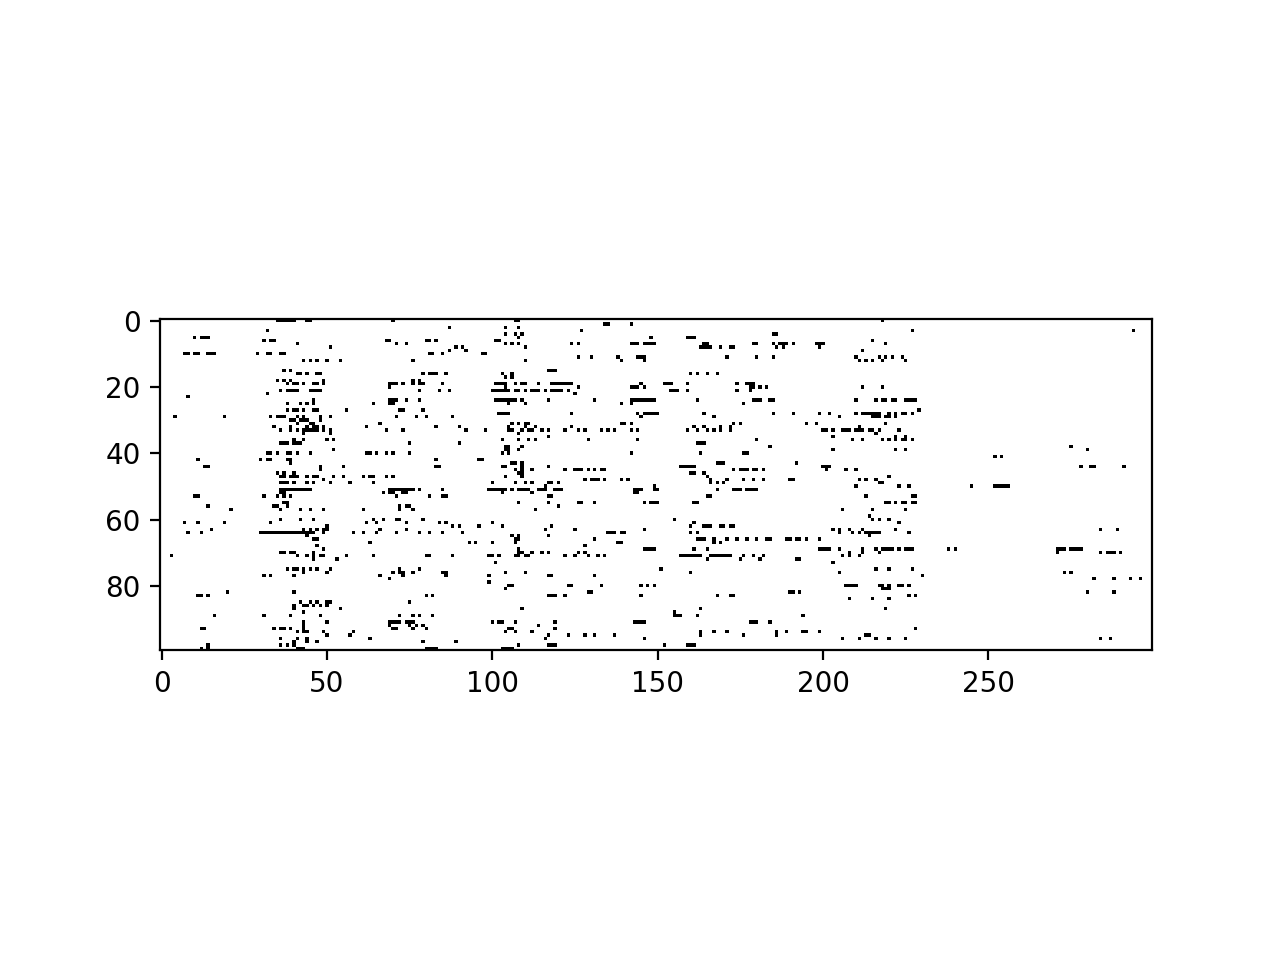

In [177]:
np_extract = extract.T.numpy()
plt.figure()
plt.imshow(np_extract,cmap="binary")
plt.show()
# absolute
for recon in recons:
    plt.figure()
    plt.imshow(recon.T.detach().numpy(),cmap="binary") # blue is predicted by 
    plt.show()

<IPython.core.display.Javascript object>


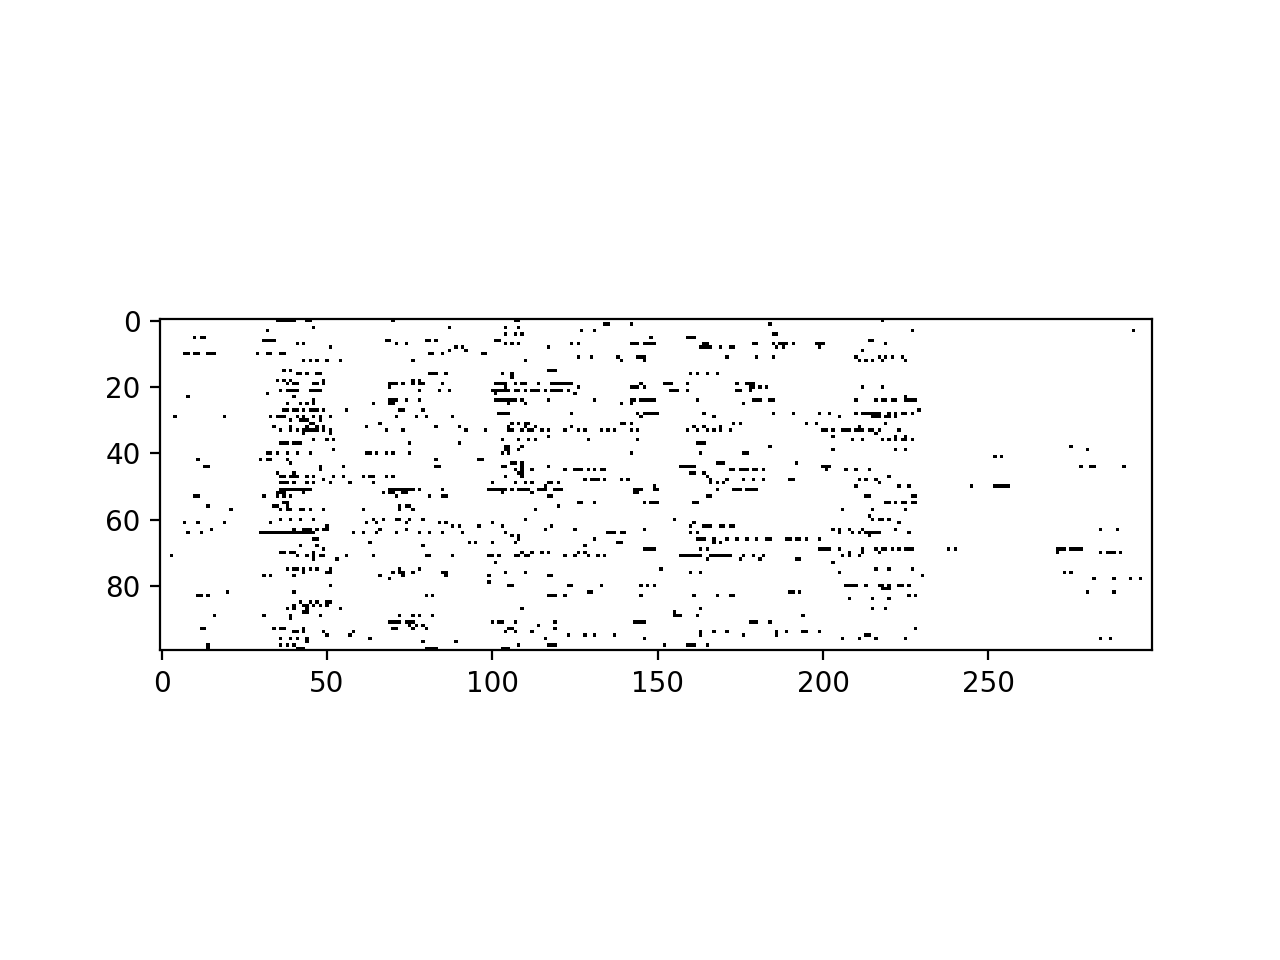

<IPython.core.display.Javascript object>


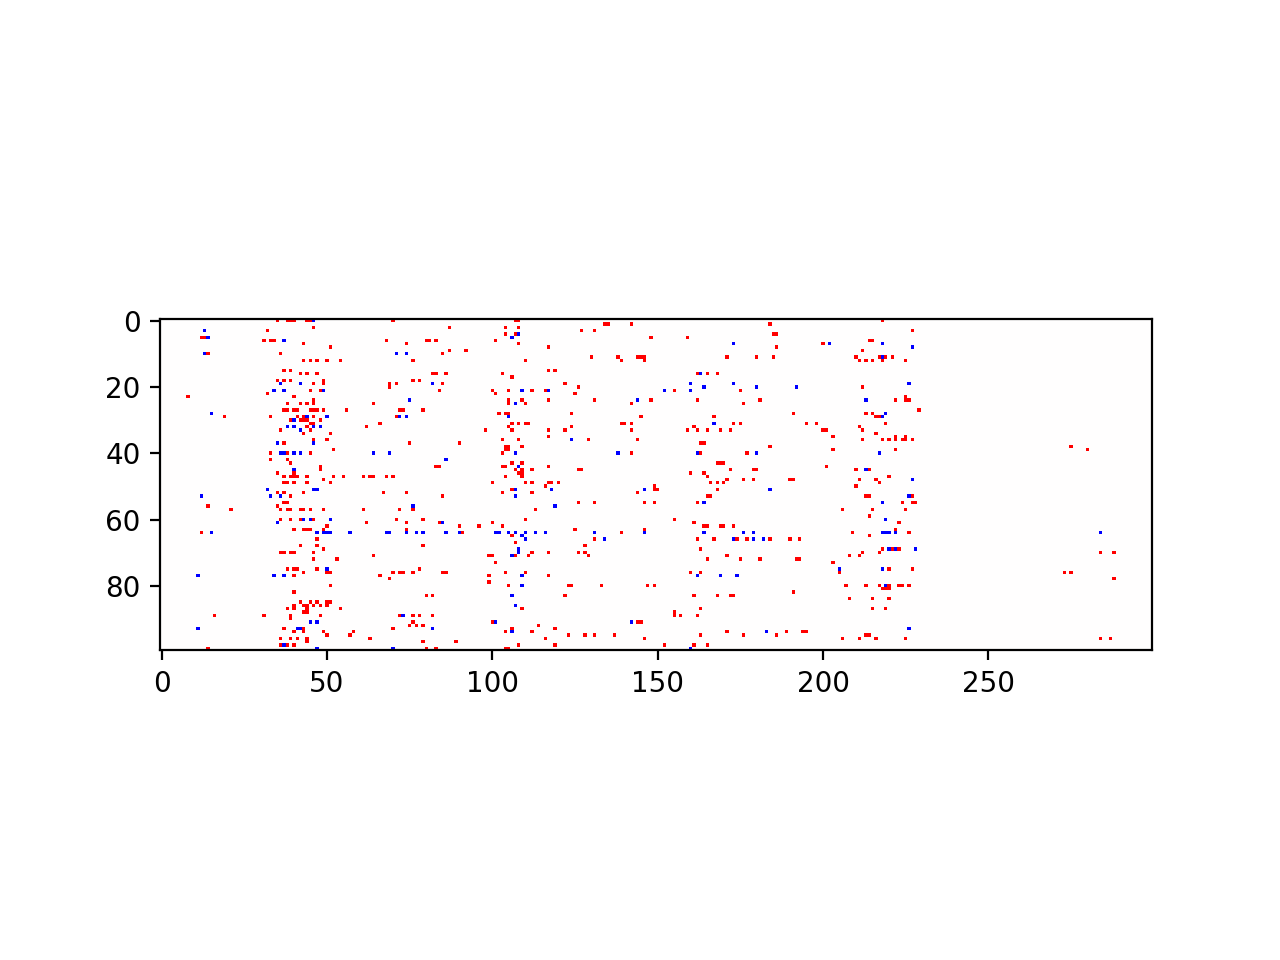

<IPython.core.display.Javascript object>


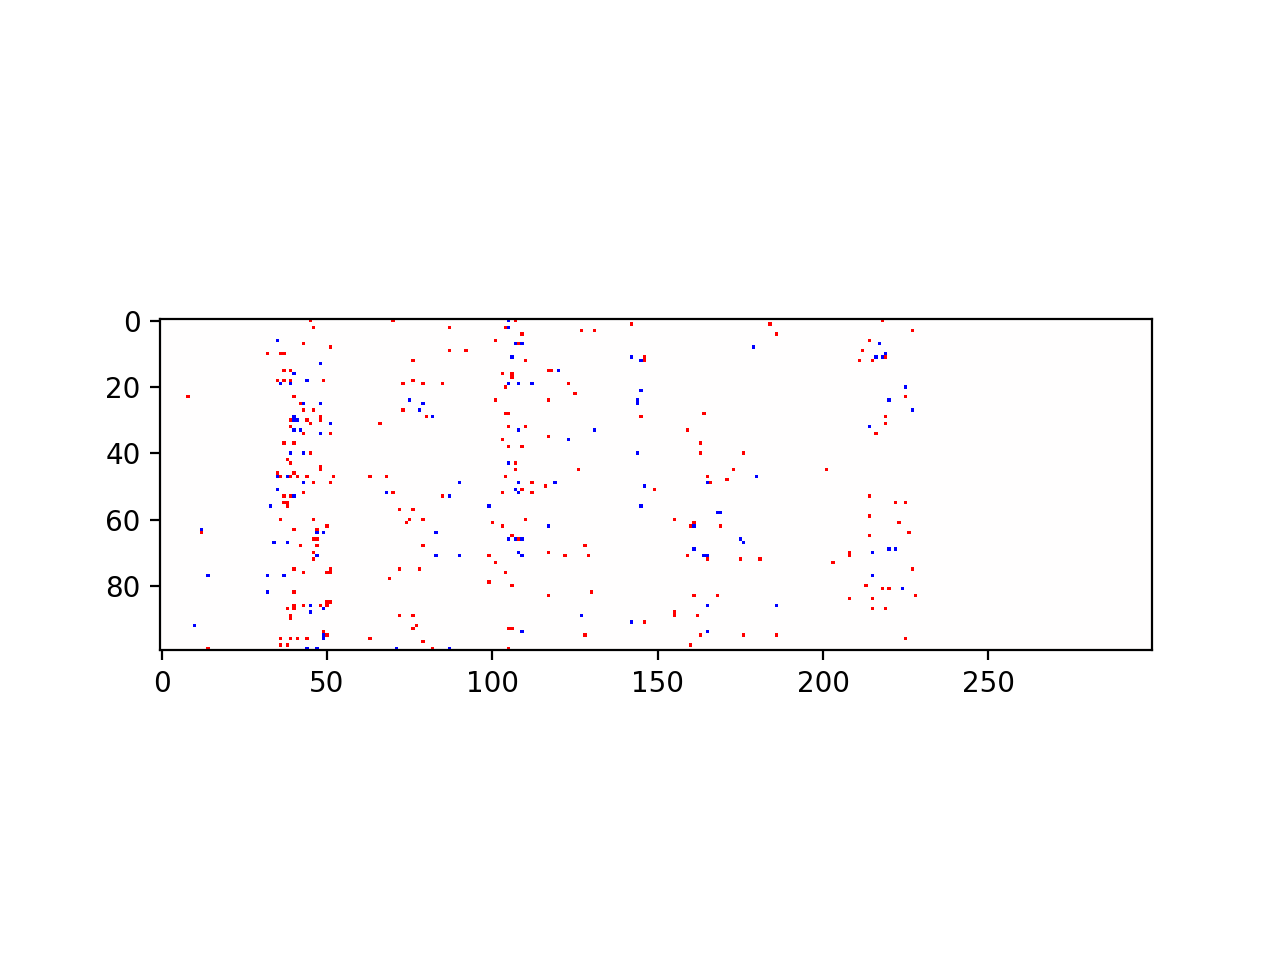

<IPython.core.display.Javascript object>


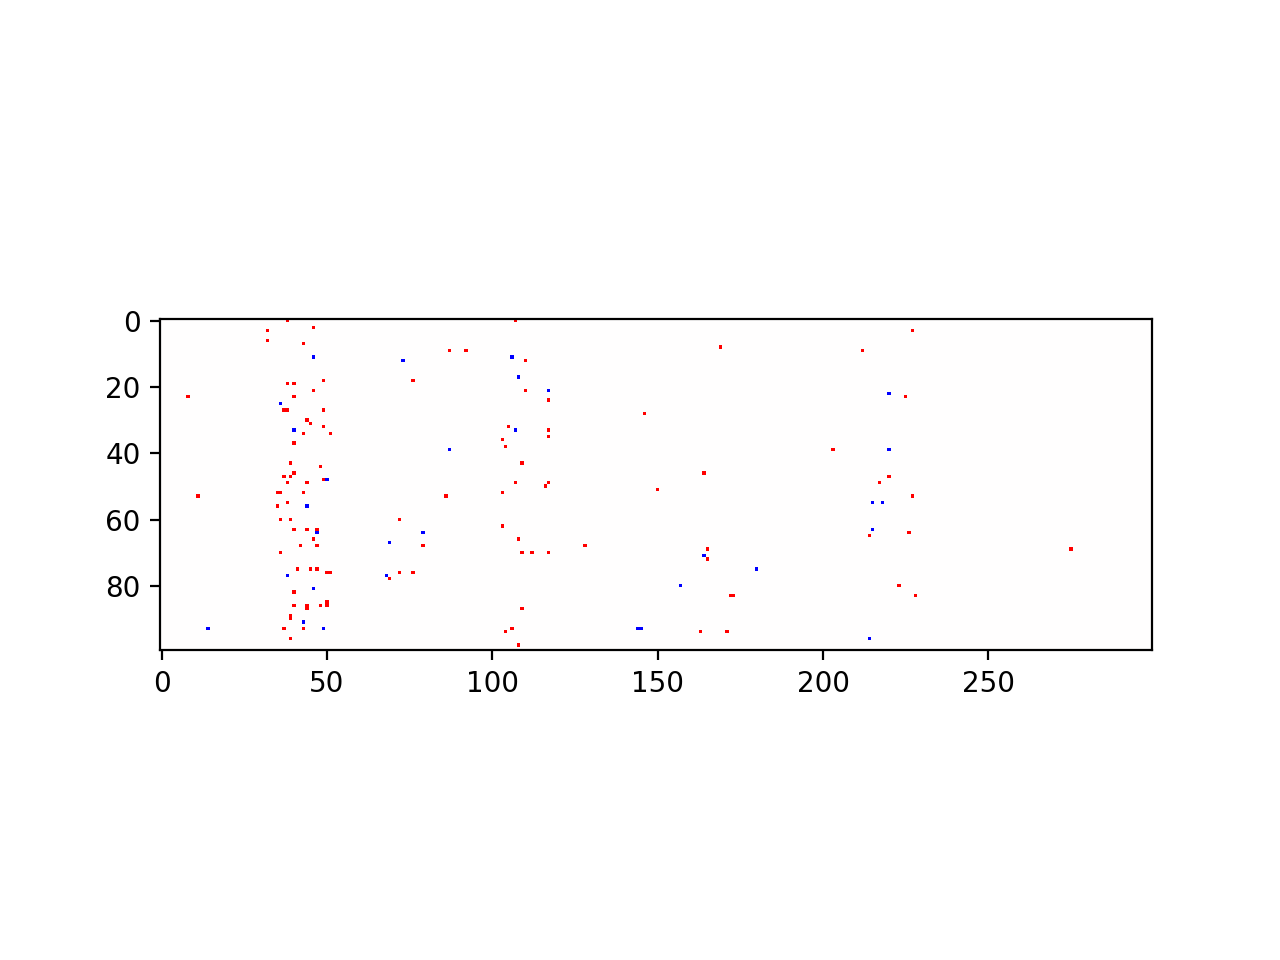

<IPython.core.display.Javascript object>


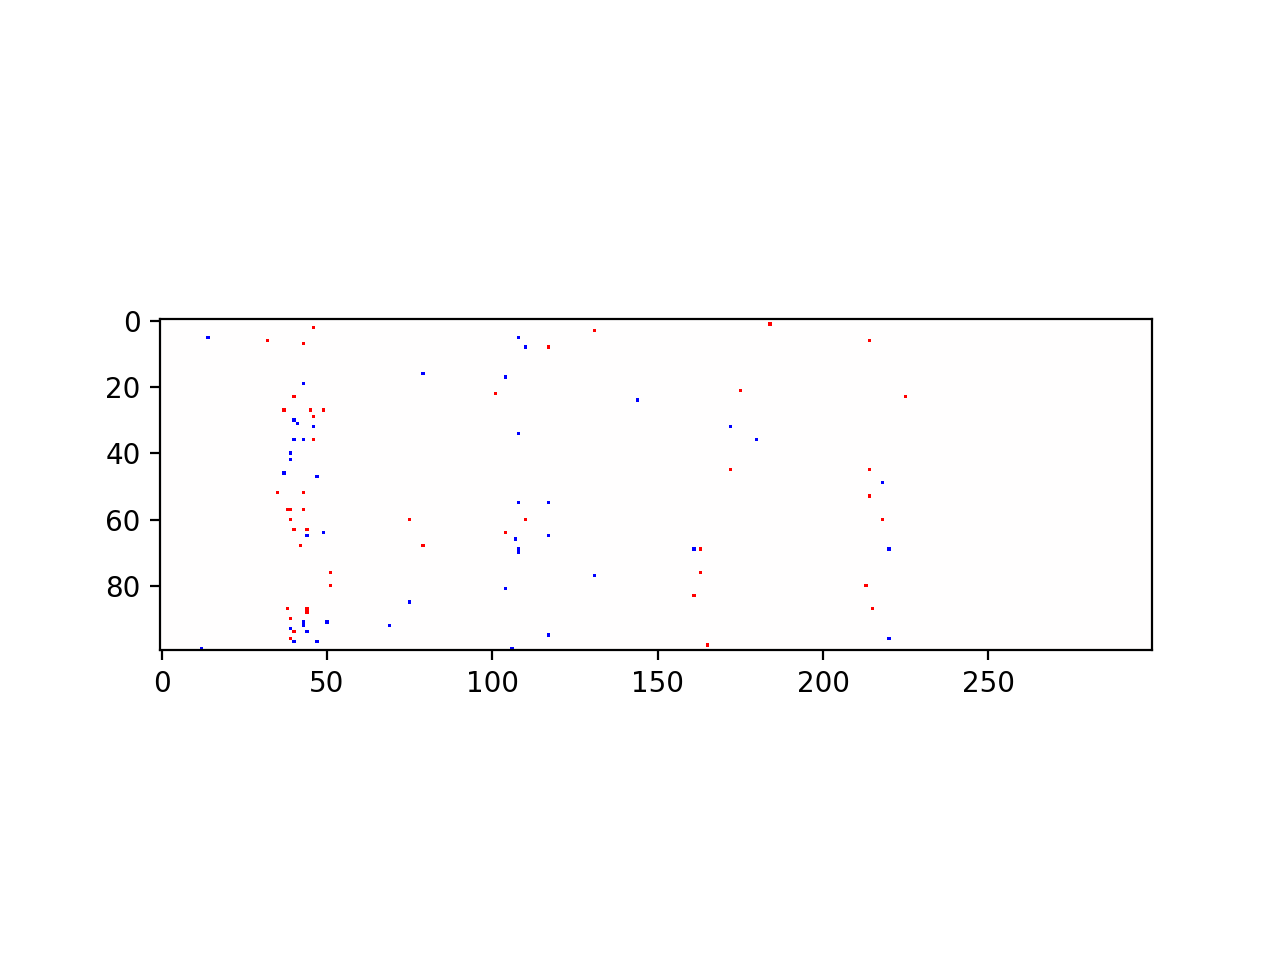

In [179]:
np_extract = extract.T.numpy()
plt.figure()
plt.imshow(np_extract,cmap="binary")
plt.show()
# differences
for recon in recons:
    np_recon = recon.T.detach().numpy()
    diffs =  np_extract * (1-np_recon) - (1-np_extract) * np_recon 
    plt.figure()
    plt.imshow(diffs,cmap="bwr") # blue is predicted by 
    plt.show()

Compare model expectations to reconstructed expectations

In [69]:
data_means = val_data.mean(0)
print(data_means)

tensor([0.0274, 0.0084, 0.0150, 0.0163, 0.0221, 0.0217, 0.0242, 0.0800, 0.0411,
        0.0056, 0.0564, 0.0277, 0.0309, 0.0096, 0.0036, 0.0153, 0.0446, 0.0121,
        0.0211, 0.1168, 0.0500, 0.1125, 0.0163, 0.0045, 0.0967, 0.0470, 0.0076,
        0.0281, 0.0682, 0.0622, 0.0194, 0.0373, 0.0457, 0.1341, 0.0226, 0.0186,
        0.0482, 0.0412, 0.0280, 0.0500])


In [73]:
train_data.mean(0) 

tensor([0.0279, 0.0080, 0.0140, 0.0167, 0.0213, 0.0212, 0.0245, 0.0804, 0.0416,
        0.0061, 0.0550, 0.0267, 0.0323, 0.0094, 0.0035, 0.0155, 0.0456, 0.0120,
        0.0201, 0.1178, 0.0494, 0.1120, 0.0162, 0.0046, 0.0947, 0.0454, 0.0074,
        0.0273, 0.0695, 0.0620, 0.0196, 0.0375, 0.0462, 0.1347, 0.0222, 0.0184,
        0.0479, 0.0420, 0.0279, 0.0504])

In [72]:
for ae in models:
    recon = ae(val_data)
    recon_means = recon.mean(0)
    print(recon_means)
    print(torch.mean( torch.abs(recon_means - data_means) ))

tensor([0.0171, 0.0047, 0.0106, 0.0117, 0.0202, 0.0216, 0.0178, 0.0790, 0.0294,
        0.0085, 0.0528, 0.0266, 0.0257, 0.0097, 0.0052, 0.0132, 0.0357, 0.0120,
        0.0171, 0.1338, 0.0401, 0.1244, 0.0092, 0.0040, 0.0994, 0.0364, 0.0064,
        0.0266, 0.0690, 0.0534, 0.0138, 0.0329, 0.0411, 0.0950, 0.0186, 0.0131,
        0.0558, 0.0259, 0.0297, 0.0432], grad_fn=<MeanBackward1>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor([0.0211, 0.0022, 0.0122, 0.0086, 0.0249, 0.0109, 0.0177, 0.0723, 0.0380,
        0.0035, 0.0590, 0.0198, 0.0305, 0.0145, 0.0024, 0.0090, 0.0551, 0.0122,
        0.0113, 0.1170, 0.0446, 0.1122, 0.0102, 0.0032, 0.0839, 0.0529, 0.0053,
        0.0272, 0.0583, 0.0519, 0.0185, 0.0394, 0.0371, 0.1209, 0.0173, 0.0110,
        0.0495, 0.0473, 0.0143, 0.0473], grad_fn=<MeanBackward1>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor([0.0266, 0.0084, 0.0216, 0.0155, 0.0199, 0.0250, 0.0252, 0.0809, 0.0447,
        0.0047, 0.0577, 0.0334, 0.0319, 0.0093, 0.0026, 0.0152, 0.04